# Project: Comprehensive DistilBERT Fine-Tuning for Amazon Review Sentiment Analysis

**Objective:** Conduct an exhaustive investigation and comparison of various fine-tuning strategies for DistilBERT on the Amazon Reviews dataset, prioritizing resource efficiency while maximizing performance. This notebook utilizes **PyTorch** for precise control and incorporates extensive hyperparameter tuning, detailed analysis, and comparison between raw and preprocessed data.

**Dataset:** Pre-processed Amazon Reviews dataset containing 'content' (raw text) and 'clean' (spaCy processed text) columns, along with 'label' (0/1).

**Techniques Explored (Exhaustively):**
1.  **Data Impact:** Compare performance using raw ('content') vs. preprocessed ('clean') text across all strategies.
2.  **Full Fine-tuning:** Standard approach training all DistilBERT layers with hyperparameter search.
3.  **Layer Freezing Strategies (with Hyperparameter Search):**
    *   **Classifier Only:** Freeze the entire DistilBERT base, tune only the classification head.
    *   **Top-N Layers:** Freeze lower layers, fine-tune the top N encoder layers (N=2, N=4) and the classifier.
4.  **LoRA (Low-Rank Adaptation) (with Hyperparameter Search):** Implement parameter-efficient fine-tuning using LoRA, exploring different ranks and learning rates.
5.  **CLS Embedding Extraction:** Extract and save [CLS] token embeddings after training for every evaluated configuration to enable evaluation with external classifiers (SVM, Logistic Regression).

**Methodology:**
*   Define extensive hyperparameter grids for relevant training parameters (LR, Batch Size, Dropout, WD, LoRA Rank).
*   Programmatically generate all experiment configurations based on strategies and grids.
*   Run each configuration systematically using a master training function.
*   Employ PyTorch with Automatic Mixed Precision (AMP) for efficiency.
*   Utilize early stopping based on validation loss.
*   Track and log detailed metrics (batch/epoch loss, accuracy, F1, precision, recall).
*   Generate comprehensive plots (Loss/Acc vs. Steps, Loss vs. LR) for each run.
*   Produce detailed text reports and a final summary table comparing all runs.

In [1]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

### Imports

In [15]:
import subprocess
import sys
import importlib
import time
import re
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from torch.amp import autocast, GradScaler
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path
import gc
import json
import time
# --- Transformers & PEFT ---
from transformers import (
    AutoTokenizer, DistilBertForSequenceClassification, DistilBertConfig,
    DataCollatorWithPadding, logging as hf_logging
)
from peft import get_peft_model, LoraConfig, TaskType


# --- Datasets ---
from datasets import load_from_disk, DatasetDict

# --- Metrics & Utilities ---
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress excessive Hugging Face logging
hf_logging.set_verbosity_error()

print("Libraries imported.")


Libraries imported.


### Configuration & Initialization  
- Centralizes all paths, model specs, training hyper‑parameters, and LoRA options in a single `CONFIG` dictionary.  
- Organizes outputs by pre‑creating artifact, CLS‑embedding, and plots directories under the chosen base path.  
- Guarantees reproducibility via a `seed_everything()` helper that seeds Python, NumPy, and PyTorch (CPU + CUDA) RNGs and locks down cuDNN determinism.  
- Auto‑detects the best compute backend (CUDA GPU → MPS → CPU), clears GPU cache, and conditionally disables AMP when needed.  
- Prints concise status messages so you immediately know the seed, device in use, and where artifacts will be written.


In [16]:
CONFIG = {
    # Paths
    "SAVED_DATASET_PATH": "/content/amazon_reviews_data/arrow_clean",

    "BASE_ARTIFACT_DIR": "/content/distilbert_amazon_artifacts_focused", # New base dir

    # Model & Tokenizer
    "MODEL_NAME": "distilbert-base-uncased",
    "MAX_LENGTH": 256,

    # Fixed Training Params
    "EPOCHS": 4, # Not too many epochs for the code to run faster
    "AMP_ENABLED": True,
    "GRADIENT_CLIP_VAL": 1.0,
    "EARLY_STOPPING_PATIENCE": 2, # Keep patience reasonable
    "EARLY_STOPPING_THRESHOLD": 0.001,
    "SEED": 42,
    "NUM_LABELS": 2,

    # Default Hyperparameters
    "DEFAULT_BATCH_SIZE": 32,
    "DEFAULT_LEARNING_RATE": 3e-5,
    "DEFAULT_CLASSIFIER_LR": 1e-4,
    "DEFAULT_WEIGHT_DECAY": 0.01,
    "DEFAULT_WARMUP_RATIO": 0.1,
    "DEFAULT_LR_SCHEDULER_TYPE": "linear",
    "DEFAULT_DROPOUT": 0.1,

    # Default LoRA Config
    "DEFAULT_LORA_R": 8,
    "DEFAULT_LORA_ALPHA": 16,
    "DEFAULT_LORA_DROPOUT": 0.1,
    "DEFAULT_LORA_TARGET_MODULES": ["q_lin", "v_lin"],
}

# Create Derived Paths
CONFIG["ARTIFACT_DIR"] = Path(CONFIG["BASE_ARTIFACT_DIR"]) / "models_reports"
CONFIG["CLS_EMBEDDING_DIR"] = Path(CONFIG["BASE_ARTIFACT_DIR"]) / "cls_embeddings"
CONFIG["PLOTS_DIR"] = Path(CONFIG["BASE_ARTIFACT_DIR"]) / "plots"

CONFIG["ARTIFACT_DIR"].mkdir(parents=True, exist_ok=True)
CONFIG["CLS_EMBEDDING_DIR"].mkdir(parents=True, exist_ok=True)
CONFIG["PLOTS_DIR"].mkdir(parents=True, exist_ok=True)

# Seed Everything
def seed_everything(seed: int) -> None:
    """Seed all relevant RNGs for reproducibility."""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# Reproducibility
seed_everything(CONFIG["SEED"])
print(f"Reproducibility ensured with seed: {CONFIG['SEED']}")

# Device setup
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()

elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS")
    CONFIG["AMP_ENABLED"] = False

else:
    device = torch.device("cpu")
    print("Using CPU")
    CONFIG["AMP_ENABLED"] = False


Reproducibility ensured with seed: 42
Using GPU: NVIDIA A100-SXM4-40GB


### Load Preprocessed Data
- unzip the amazon_reviews data if you must
- Then load your data

In [18]:
!unzip -q /content/amazon_reviews_data.zip -d /content

In [19]:
print("Load Dataset")
# (Same code as previous Cell 4 - loading and validating the dataset)
print(f"\n Loading dataset from disk: {CONFIG['SAVED_DATASET_PATH']}")
DATASET_PATH = Path(CONFIG["SAVED_DATASET_PATH"])
dataset_loaded = False # Default status
if not DATASET_PATH.exists() or not (DATASET_PATH / "dataset_dict.json").exists():
    print(f"ERROR: Dataset path does not exist or is invalid: {DATASET_PATH}")
else:
    try:
        loaded_ds = load_from_disk(str(DATASET_PATH))
        required_splits = ['train', 'validation', 'test']; required_cols = ['label', 'content', 'clean']
        if not isinstance(loaded_ds, DatasetDict) or \
           not all(s in loaded_ds for s in required_splits) or \
           not all(c in loaded_ds['train'].column_names for c in required_cols):
            print(" ERROR: Loaded dataset is invalid."); print(f" Splits: {list(loaded_ds.keys())}, Cols: {loaded_ds['train'].column_names}")
        else:
            print("Dataset loaded successfully!"); print(loaded_ds); dataset_loaded = True
    except Exception as e: print(f"ERROR: Failed to load dataset. Error: {e}")
if not dataset_loaded: print("\nHalting execution: Dataset could not be loaded.")

Load Dataset

 Loading dataset from disk: /content/amazon_reviews_data/arrow_clean
Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['label', 'content', 'clean'],
        num_rows: 51000
    })
    validation: Dataset({
        features: ['label', 'content', 'clean'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['label', 'content', 'clean'],
        num_rows: 10000
    })
})


### Tokenizer, Data Collator, Dataset Class  
- Instantiates a fast Hugging Face tokenizer (`distilbert-base-uncased`), catching and surfacing any load errors.  
- Provides `tokenize_batch()` for batched, truncation‑aware tokenization capped at `MAX_LENGTH`.  
- Sets up a `DataCollatorWithPadding` that pads each batch to its longest sequence on‑the‑fly.  
- Defines `PreTokenizedSentimentDataset`, wrapping pre‑tokenized dicts into PyTorch‑friendly items with tensor‑converted features and labels.  
- Adds helpers: `prep_tok_ds()` for multiprocessing tokenization of a `DatasetDict` split, and `create_loader()` for CUDA‑aware `DataLoader` construction with dynamic padding.

In [20]:
print("Tokenizer & Data Handling")

# Load tokenizer
print(f"\nLoading tokenizer: {CONFIG['MODEL_NAME']}")
try:
    tokenizer = AutoTokenizer.from_pretrained(CONFIG["MODEL_NAME"], use_fast=True)
    print("Tokenizer loaded.")
except Exception as e:
    print(f"ERROR loading tokenizer: {e}")
    raise

# tokenize a batch of examples
def tokenize_batch(examples, column):
    """Tokenize a list of texts under `column`."""
    texts = [str(t) if t else "" for t in examples[column]]
    return tokenizer(
        texts,
        max_length=CONFIG["MAX_LENGTH"],
        truncation=True,
        padding=False,
    )

# Data‑collator for dynamic padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding="longest",
)
print("Data collator initialized.")


class PreTokenizedSentimentDataset(Dataset):
    def __init__(self, encodings):
        self.enc = encodings

    def __len__(self):
        return len(self.enc)

    def __getitem__(self, idx):
        item = self.enc[idx]
        # Convert all features except label to tensors, keep label separate
        features = {
            k: torch.tensor(v, dtype=torch.long)
            for k, v in item.items()
            if k != "label"
        }
        features["labels"] = torch.tensor(item["label"], dtype=torch.long)
        return features

# Tokenize an entire DatasetDict split
def prep_tok_ds(ds: DatasetDict, column: str):
    """Return a tokenized copy of `ds` using text column `column`."""
    print(f"\nTokenizing '{column}'...")
    try:
        tokenized_ds = (
            ds.select_columns(["label", column])
              .map(
                  lambda ex: tokenize_batch(ex, column),
                  batched=True,
                  remove_columns=[column],
                  num_proc=max(1, os.cpu_count() // 2),
              )
        )
        print("Tokenization complete.")
        return tokenized_ds
    except Exception as e:
        print(f"ERROR tokenizing '{column}': {e}")
        return None

# Convenience wrapper for DataLoader creation
def create_loader(split, batch_size: int, shuffle: bool = False):
    """Return a PyTorch DataLoader with pin‑memory when CUDA is available."""
    dataset = PreTokenizedSentimentDataset(split)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=data_collator,
        num_workers=2,
        pin_memory=torch.cuda.is_available(),
    )

print("Data‑processing components defined.")


Tokenizer & Data Handling

Loading tokenizer: distilbert-base-uncased
Tokenizer loaded.
Data collator initialized.
Data‑processing components defined.


### Helper Functions ‑ Evaluation, Reporting, Plotting, Freezing, CLS  
- **`evaluate_model()`** – Runs the model in `torch.no_grad()` mode with optional AMP, tracks batch‑level loss and logits, then aggregates accuracy, precision, recall, F1 and loss, plus a confusion matrix & classification report. Handles edge cases (e.g. empty label lists) without crashing.  
- **`format_experiment_report()`** – Converts one training run into a human‑readable, multi‑line text summary that embeds key hyper‑params, best‑validation metrics, final‑test metrics, confusion matrix, classification report and optional notes—ready to log or save.  
- **Plot helpers** –  
  * `plot_training_progress()` draws epoch‑level loss/accuracy curves.  
  * `plot_detailed_metrics()` overlays smoothed step‑level loss/accuracy with learning‑rate history and epoch markers.  
  * `plot_loss_vs_lr()` averages loss in log‑spaced LR bins to reveal LR‑sensitivity.  
  All three auto‑save PNGs, use defensive checks, and skip gracefully if data is missing.  
- **Model‑freezing utilities** – `freeze_model_layers()` supports strategies `"none"`, `"classifier"`, and `"top_layers_N"` (train only the last *N* encoder layers). Paired with `print_trainable_parameters()` to log the exact count and percentage of trainable parameters.  
- **`extract_cls_embeddings()`** – Iterates over a dataloader, pulls `[CLS]` vectors from the base DistilBERT (works with PEFT adapters), and returns NumPy arrays of embeddings and labels for downstream classical models.  
- Throughout, extensive try/except blocks and tqdm progress bars keep runs fault‑tolerant and transparent.

In [24]:
print("\n---  Helper Functions  ---")

# ------------------------------------------------------------------
# Evaluation on validation / test split
# ------------------------------------------------------------------
def evaluate_model(model, dataloader, device, use_amp: bool = False):
    """Return metrics, confusion‑matrix, classification‑report, preds, labels."""
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch["labels"]

            try:
                with autocast(device_type=device.type, enabled=use_amp):
                    outputs = model(**batch)
                    loss = outputs.loss
                    logits = outputs.logits

                total_loss += loss.item()
                all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            except Exception as e:
                print(f"\nError during eval batch: {e}")
                continue

    # handle edge‑case where no labels were collected
    if not all_labels:
        dummy_metrics = {
            "loss": float("nan"),
            "accuracy": 0.0,
            "f1": 0.0,
            "precision": 0.0,
            "recall": 0.0,
        }
        return dummy_metrics, np.array([]), "Evaluation failed", [], []

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="binary", zero_division=0
    )

    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(
        all_labels,
        all_preds,
        target_names=["Neg(0)", "Pos(1)"],
        digits=4,
        zero_division=0,
        output_dict=False,
    )

    metrics = {
        "loss": avg_loss,
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

    return metrics, cm, cr, all_labels, all_preds


# ------------------------------------------------------------------
# Nicely‑formatted plain‑text experiment report
# ------------------------------------------------------------------
def format_experiment_report(
    exp_name,
    cfg,
    best_val,
    test,
    cm,
    cr,
    notes: str = "",
):
    """Build a multi‑line string summary for one experiment run."""
    lr_val = cfg.get("learning_rate", "N/A")
    lr_str = f"{lr_val:.1E}" if isinstance(lr_val, float) else str(lr_val)

    report_lines = [
        f"Report for DistilBERT -> {exp_name}",
        "Config: "
        f"Data={cfg.get('text_column', 'N/A')}, "
        f"Freeze={cfg.get('layers_frozen', 'N/A')}, "
        f"LoRA={cfg.get('use_lora', False)}, "
        f"LR={lr_str}, "
        f"BS={cfg.get('batch_size', 'N/A')}, "
        f"DO={cfg.get('dropout', 'N/A')}, "
        f"WD={cfg.get('weight_decay', 'N/A')}",
        f"Best Validation Accuracy: {best_val.get('accuracy', -1):.4f}",
        f"Best Validation Loss: {best_val.get('loss', float('inf')):.4f}",
        "=" * 60,
        f"Test Performance -> {exp_name}",
        f"Test Loss: {test.get('loss', -1):.4f}, "
        f"Accuracy: {test.get('accuracy', -1):.4f}, "
        f"F1 Score: {test.get('f1', -1):.4f}",
        "\nConfusion Matrix:\n" + str(cm),
        "\nClassification Report:\n" + str(cr),
    ]

    if notes:
        report_lines.append("\nNotes: " + notes)

    report_lines.append("=" * 60 + "\n")
    return "\n".join(report_lines)


# ------------------------------------------------------------------
# Plot helpers
# ------------------------------------------------------------------
def plot_training_progress(hist, title, save_path):
    """Epoch‑level loss/accuracy figure (train vs. val)."""
    if not hist["train_loss"]:
        print(f"Skipping plot {title}: No history.")
        return

    epochs = range(1, len(hist["train_loss"]) + 1)
    plt.figure(figsize=(14, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["train_loss"], "bo-", label="Train")
    plt.plot(epochs, hist["val_loss"], "ro-", label="Val")
    plt.title(f"{title} – Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist["train_acc"], "bo-", label="Train")
    plt.plot(epochs, hist["val_acc"], "ro-", label="Val")
    plt.title(f"{title} – Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.ylim(
        max(0.0, min(hist["val_acc"]) * 0.95 if hist["val_acc"] else 0.0),
        1.02,
    )

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"  Plot saved: {save_path}")
    plt.show()


def plot_detailed_metrics(
    batch_hist,
    epoch_marks,
    best_mark,
    title,
    save_path,
    avg_w: int = 20,
):
    """Step‑level smoothed loss / acc + learning‑rate curve."""
    if not batch_hist["batch_train_loss"]:
        print(f"Skipping plot {title}: No batch history.")
        return

    def mvavg(seq, window):
        return (
            pd.Series(seq)
            .rolling(window=window, min_periods=1)
            .mean()
            .tolist()
        )

    steps = np.arange(1, len(batch_hist["batch_train_loss"]) + 1)
    avg_loss = mvavg(batch_hist["batch_train_loss"], avg_w)
    avg_acc = mvavg(batch_hist["batch_train_acc"], avg_w)
    lrs = batch_hist["learning_rate"]

    fig, ax1 = plt.subplots(figsize=(18, 7))
    loss_color, acc_color, lr_color = "tab:red", "tab:blue", "tab:green"

    ax1.set_xlabel(f"Step (moving‑avg={avg_w})")
    ax1.set_ylabel("Loss / Accuracy")

    l1, = ax1.plot(steps, avg_loss, label="Avg Loss", color=loss_color)
    l2, = ax1.plot(steps, avg_acc, label="Avg Acc", color=acc_color)
    ax1.tick_params(axis="y")
    ax1.set_ylim(0.0, max(1.05, max(avg_acc) * 1.1))

    # epoch vertical lines
    for i, s in enumerate(epoch_marks):
        ax1.axvline(x=s, color="grey", ls="--", alpha=0.6,
                    label="Epoch End" if i == 0 else "")

    # best step marker
    if best_mark:
        ax1.axvline(x=best_mark, color="limegreen", ls="-", lw=2,
                    label="Best Step")

    # second axis for LR
    ax2 = ax1.twinx()
    ax2.set_ylabel("LR", color=lr_color)
    l3, = ax2.plot(steps, lrs, label="LR", color=lr_color, ls=":")
    ax2.tick_params(axis="y", labelcolor=lr_color)
    ax2.set_yscale("log")

    ax1.legend(
        [l1, l2, l3],
        [l.get_label() for l in (l1, l2, l3)],
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
    )

    plt.title(f"{title} – Detailed Metrics")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(save_path)
    print(f"  Detailed plot saved: {save_path}")
    plt.show()


def plot_loss_vs_lr(batch_hist, title, save_path, num_bins: int = 100):
    """Average training loss vs. learning‑rate (log‑binned)."""
    lrs = np.array(batch_hist["learning_rate"])
    losses = np.array(batch_hist["batch_train_loss"])

    mask = lrs > 1e-9
    lrs, losses = lrs[mask], losses[mask]

    if len(lrs) < 2 or lrs.min() == lrs.max():
        print(f"Skipping plot {title}: Insufficient LR variation.")
        return

    try:
        bins = np.logspace(np.log10(lrs.min()), np.log10(lrs.max()), num_bins)
    except ValueError:
        print(f"Skipping plot {title}: Error creating log bins.")
        return

    bin_ids = np.digitize(lrs, bins)
    avg_losses, bin_centers = [], []

    for i in range(1, len(bins)):
        m = bin_ids == i
        if np.any(m):
            avg_losses.append(losses[m].mean())
            bin_centers.append((bins[i - 1] + bins[i]) / 2)

    if not bin_centers:
        print(f"Skipping plot {title}: No data in bins.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(bin_centers, avg_losses, marker=".", ls="-")
    plt.xscale("log")
    plt.xlabel("Learning Rate (log scale)")
    plt.ylabel("Average Train Loss")
    plt.title(f"{title} – Loss vs. LR")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"  Loss‑vs‑LR plot saved: {save_path}")
    plt.show()


# ------------------------------------------------------------------
# Model‑freezing utilities
# ------------------------------------------------------------------
def freeze_model_layers(model, freeze_level: str = "none"):
    """
    Freeze layers of DistilBERT according to strategy:
        - 'none'         : train everything
        - 'classifier'   : freeze base, train classifier only
        - 'top_layers_N' : unfreeze the top‑N encoder layers + classifier
    """
    n_layers = model.config.num_hidden_layers

    # start by unfreezing everything
    for p in model.parameters():
        p.requires_grad_(True)

    if freeze_level == "none":
        print("Freeze: none")
        return

    if freeze_level == "classifier":
        print("Freeze: classifier")
        for p in model.distilbert.parameters():
            p.requires_grad_(False)
        return

    if freeze_level.startswith("top_layers_"):
        try:
            n = int(freeze_level.split("_")[-1])
            assert 0 < n <= n_layers
        except Exception:
            print(f"Invalid freeze level '{freeze_level}'. Training all.")
            return

        print(f"Freeze: {freeze_level}")
        # freeze whole base
        for p in model.distilbert.parameters():
            p.requires_grad_(False)
        # unfreeze last‑N layers
        for i in range(n_layers - n, n_layers):
            for p in model.distilbert.transformer.layer[i].parameters():
                p.requires_grad_(True)
        return

    print(f"Unknown freeze level '{freeze_level}'. Training all.")


def print_trainable_parameters(model):
    """Log how many parameters are trainable vs. total."""
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    pct = 100 * trainable / total
    print(f"  Trainable: {trainable:,} / {total:,}  ({pct:.2f} %)")


# ------------------------------------------------------------------
# CLS embedding extraction (for SVM / LR later)
# ------------------------------------------------------------------
def extract_cls_embeddings(model, dataloader, device, desc: str = "Extracting CLS"):
    """Return numpy arrays: embeddings (N, hidden) and labels (N,)."""
    model.eval()
    embeddings, labels_out = [], []

    # works for vanilla model or PEFT adapter
    base = model.get_base_model() if hasattr(model, "get_base_model") else model
    transf = base.distilbert if hasattr(base, "distilbert") else base

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc, leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            lbls = batch["labels"].cpu().numpy()

            try:
                outputs = transf(**inputs)
                cls_vecs = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            except Exception as e:
                print(f"Error extracting CLS: {e}")
                continue

            embeddings.append(cls_vecs)
            labels_out.append(lbls)

    if not embeddings:
        return None, None

    return np.concatenate(embeddings, axis=0), np.concatenate(labels_out, axis=0)


print("Core helper functions ready.")


---  Helper Functions  ---
Core helper functions ready.


### Master Training Function  
- **Run‑orchestrator `run_training_experiment()`** – wraps an entire DistilBERT fine‑tuning cycle (optionally LoRA‑adapted) into one call: it accepts small dicts describing *model*, *training*, and *data* knobs plus a `DatasetDict`, tokenizer, device, and a shared `results_list` to which it appends a self‑contained run record.  

- **Experiment bookkeeping & paths** – immediately prints a JSON snapshot of every knob, then creates experiment‑specific sub‑folders for weights, plots, and CLS‑embeddings (`models_reports/`, `plots/`, `cls_embeddings/`) under the supplied base artifact dir.  

- **Pre‑processing & loaders** – tokenizes the chosen text column via `prep_tok_ds()`, instantiates train/val/test loaders (dynamic padding, CUDA pin‑memory), and aborts early if any step fails.  

- **Model provisioning** –  
  * Builds a fresh `DistilBertConfig` with custom dropout and num‑labels.  
  * Loads pretrained weights, freezes layers according to `freeze_level` *or* inserts a PEFT LoRA adapter (configurable `r`, `alpha`, targets).  
  * Reports the exact trainable parameter count.  

- **Optimization stack** – selects AdamW over *trainable* params only, derives total/ warm‑up steps for a Hugging Face scheduler, enables mixed‑precision with `GradScaler` when CUDA+AMP are allowed, and logs the chosen LR / WD.  

- **Training loop** – for each epoch:  
  1. Batches are cast to device; forward pass is optionally autocast.  
  2. Loss backward, gradient‑clip (if set), scaler‑step, scheduler‑step.  
  3. Tracks per‑batch loss/acc & LR into `batch_hist`; per‑epoch aggregates into `hist`.  
  4. Evaluates on the validation split, prints metrics, performs patience‑based early‑stopping, and checkpoints the best weights (LoRA adapter or `.pt`).  

- **Post‑training evaluation** – reloads the *best* checkpoint (PEFT‑aware) onto the same device, runs full‑test evaluation via `evaluate_model()`, prints metrics, and writes a plain‑text `experiment_report.txt` capturing config + val/test scores + confusion matrix + classification report.  

- **Down‑stream features** – extracts `[CLS]` embeddings for train/val/test with `extract_cls_embeddings()` and persists them as `.npy`, enabling classical models or visualization later.  

- **Visualization** – auto‑plots (1) epoch‑level loss/acc, (2) step‑level smoothed metrics with LR curve and epoch/best markers, and (3) loss‑vs‑LR log plot; PNGs land in the experiment’s plot folder.  

- **Result object & cleanup** – appends a dict summarizing status, timings, best epoch, and metrics to the shared `results_list`, aggressively garbage‑collects GPU/CPU memory, and returns the same dict for immediate use.

In [25]:
print("\n---  Master Training Function  ---")

def run_training_experiment(
    exp_name: str,
    model_config: dict,
    training_config: dict,
    data_config: dict,
    dataset: DatasetDict,
    tokenizer: AutoTokenizer,
    device: torch.device,
    base_artifact_dir: Path,
    results_list: list,
    freeze_level: str = "none",
    use_lora: bool = False,
    lora_config_params: dict | None = None,
):
    start_time = time.time()

    print(f"\n================  Starting Experiment: {exp_name}  ================")
    print(
        "Full Config:\n"
        + json.dumps(
            {
                "model": model_config,
                "train": training_config,
                "data": data_config,
                "freeze": freeze_level,
                "lora": use_lora,
            },
            indent=2,
            default=str,
        )
    )

    # ------------------------------------------------------------------
    # Paths for artifacts, plots, embeddings
    # ------------------------------------------------------------------
    exp_artifact_dir = base_artifact_dir / "models_reports" / exp_name
    exp_plot_dir = base_artifact_dir / "plots" / exp_name
    exp_embed_dir = base_artifact_dir / "cls_embeddings"

    exp_artifact_dir.mkdir(parents=True, exist_ok=True)
    exp_plot_dir.mkdir(parents=True, exist_ok=True)

    # ------------------------------------------------------------------
    # Tokenize chosen text column
    # ------------------------------------------------------------------
    text_column = data_config["text_column"]
    tokenized_ds = prep_tok_ds(dataset, text_column)

    if not tokenized_ds:
        print(f"Halting {exp_name}: tokenization failed.")
        return None

    # ------------------------------------------------------------------
    # DataLoaders
    # ------------------------------------------------------------------
    print("\nCreating DataLoaders...")
    bs = training_config["batch_size"]

    try:
        train_loader = create_loader(tokenized_ds["train"], bs, shuffle=True)
        val_loader = create_loader(tokenized_ds["validation"], bs * 2)
        test_loader = create_loader(tokenized_ds["test"], bs * 2)
        print(f"DataLoaders created (train batch size = {bs}).")
    except Exception as e:
        print(f"ERROR creating DataLoaders: {e}")
        return None

    # ------------------------------------------------------------------
    # Model setup  (DistilBERT + optional LoRA)
    # ------------------------------------------------------------------
    print(f"\nLoading model: {CONFIG['MODEL_NAME']} ...")
    model_start = time.time()

    try:
        distil_cfg = DistilBertConfig.from_pretrained(
            CONFIG["MODEL_NAME"],
            num_labels=CONFIG["NUM_LABELS"],
            dropout=model_config["dropout"],
            attention_dropout=model_config["dropout"],
            seq_classif_dropout=model_config["dropout"],  # head‑specific
        )

        model = DistilBertForSequenceClassification.from_pretrained(
            CONFIG["MODEL_NAME"], config=distil_cfg
        )
        print(f"  Model loaded in {time.time() - model_start:.2f}s.")

        if not use_lora:
            freeze_model_layers(model, freeze_level)
        else:
            print("\nConfiguring LoRA ...")
            lora_conf = LoraConfig(
                **lora_config_params,
                task_type=TaskType.SEQ_CLS,
                bias="none",
            )
            model = get_peft_model(model, lora_conf)
            print("LoRA configured.")

        model.to(device)
        print("\nTrainable parameters:")
        print_trainable_parameters(model)

    except Exception as e:
        print(f"ERROR initializing model: {e}")
        return None

    # ------------------------------------------------------------------
    # Optimizer & scheduler
    # ------------------------------------------------------------------
    print("\nConfiguring optimizer & scheduler ...")
    lr = training_config["learning_rate"]
    wd = training_config["weight_decay"]

    if freeze_level == "classifier" and not use_lora:
        lr = training_config.get("classifier_lr", lr)

    optimizer = AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        weight_decay=wd,
    )

    n_steps = len(train_loader) * training_config["epochs"]
    n_warmup = int(training_config["warmup_ratio"] * n_steps)

    sched = get_scheduler(
        name=training_config["scheduler_type"],
        optimizer=optimizer,
        num_warmup_steps=n_warmup,
        num_training_steps=n_steps,
    )

    print(
        f"Opt: AdamW (LR={lr:.1E}, WD={wd}), "
        f"Sched: {training_config['scheduler_type']} (warm‑up steps = {n_warmup})"
    )

    # ------------------------------------------------------------------
    # AMP scaler
    # ------------------------------------------------------------------
    use_amp = CONFIG["AMP_ENABLED"] and device.type == "cuda"
    scaler = GradScaler(enabled=use_amp)
    print(f"AMP: {'Enabled' if use_amp else 'Disabled'}")

    # ------------------------------------------------------------------
    # Tracking structures
    # ------------------------------------------------------------------
    hist = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
    }
    batch_hist = {
        "batch_train_loss": [],
        "batch_train_acc": [],
        "learning_rate": [],
    }
    epoch_marks = []

    best_val_loss = float("inf")
    pat_count = 0
    best_epoch = -1
    best_val_metrics = {}

    best_model_path = exp_artifact_dir / "best_model_weights"

    # ------------------------------------------------------------------
    # Training loop
    # ------------------------------------------------------------------
    print("\nStarting training ...")
    train_start = time.time()
    status = "Failed"

    try:
        for epoch in range(training_config["epochs"]):
            model.train()
            ep_loss = 0.0
            ep_preds, ep_labels = [], []

            pbar = tqdm(
                train_loader,
                desc=f"Epoch {epoch + 1}  Train",
                leave=False,
            )
            step0 = epoch * len(train_loader)

            for i, batch in enumerate(pbar):
                batch = {k: v.to(device) for k, v in batch.items()}
                labels = batch["labels"]

                with autocast(
                    device_type=device.type,
                    dtype=torch.float16,
                    enabled=use_amp,
                ):
                    outputs = model(**batch)
                    loss = outputs.loss

                scaler.scale(loss).backward()

                if training_config.get("gradient_clip_val"):
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(
                        model.parameters(),
                        training_config["gradient_clip_val"],
                    )

                scaler.step(optimizer)
                scaler.update()
                sched.step()
                optimizer.zero_grad(set_to_none=True)

                # metrics for this batch
                bloss = loss.item()
                preds = torch.argmax(outputs.logits, dim=-1)
                bacc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

                ep_loss += bloss
                ep_preds.extend(preds.cpu().numpy())
                ep_labels.extend(labels.cpu().numpy())

                batch_hist["batch_train_loss"].append(bloss)
                batch_hist["batch_train_acc"].append(bacc)
                batch_hist["learning_rate"].append(optimizer.param_groups[0]["lr"])

                if i % 20 == 0:
                    pbar.set_postfix({"loss": f"{bloss:.3f}"}, refresh=True)

            # epoch summary
            avg_ep_loss = ep_loss / len(train_loader)
            ep_acc = accuracy_score(ep_labels, ep_preds)

            hist["train_loss"].append(avg_ep_loss)
            hist["train_acc"].append(ep_acc)
            epoch_marks.append(step0 + len(train_loader))

            print(
                f"  Epoch {epoch + 1}  Train  --  "
                f"Loss: {avg_ep_loss:.4f},  Acc: {ep_acc:.4f}"
            )

            # validation
            val_mets, _, _, _, _ = evaluate_model(
                model, val_loader, device, use_amp
            )

            hist["val_loss"].append(val_mets["loss"])
            hist["val_acc"].append(val_mets["accuracy"])
            hist["val_f1"].append(val_mets["f1"])

            print(
                f"  Epoch {epoch + 1}  Valid  --  "
                f"Loss: {val_mets['loss']:.4f},  "
                f"Acc: {val_mets['accuracy']:.4f},  "
                f"F1: {val_mets['f1']:.4f}"
            )

            # early‑stopping bookkeeping
            curr_val_loss = val_mets["loss"]

            if curr_val_loss < best_val_loss - training_config["early_stopping_threshold"]:
                best_val_loss = curr_val_loss
                best_val_metrics = val_mets
                best_epoch = epoch + 1
                pat_count = 0

                print(
                    f"  Saving best model (epoch {best_epoch}, "
                    f"val loss: {best_val_loss:.4f})"
                )

                if use_lora:
                    model.save_pretrained(best_model_path)
                else:
                    torch.save(model.state_dict(), f"{best_model_path}.pt")
            else:
                pat_count += 1
                print(
                    f"  Patience: {pat_count} / "
                    f"{training_config['early_stopping_patience']}"
                )
                if pat_count >= training_config["early_stopping_patience"]:
                    print("Early stopping.")
                    break

        status = "Completed"

    except Exception as e:
        print(f"\nERROR during training loop: {e}")

    finally:
        train_time = time.time() - train_start
        print(f"\n🏁  Training finished.  Duration: {train_time:.2f}s.")

    # ------------------------------------------------------------------
    # Load best model (or last) for evaluation
    # ------------------------------------------------------------------
    print("\nLoading best model for evaluation ...")
    eval_model = None
    loaded_ok = False

    try:
        if best_epoch != -1:
            if use_lora:
                base = DistilBertForSequenceClassification.from_pretrained(
                    CONFIG["MODEL_NAME"],
                    num_labels=CONFIG["NUM_LABELS"],
                )
                lora_conf = LoraConfig(
                    **lora_config_params,
                    task_type=TaskType.SEQ_CLS,
                    bias="none",
                )
                eval_model = get_peft_model(base, lora_conf)
                eval_model.load_adapter(best_model_path, adapter_name="default")
            else:
                distil_cfg = DistilBertConfig.from_pretrained(
                    CONFIG["MODEL_NAME"],
                    num_labels=CONFIG["NUM_LABELS"],
                    dropout=model_config["dropout"],
                    attention_dropout=model_config["dropout"],
                    seq_classif_dropout=model_config["dropout"],  # head‑specific
                )

                eval_model = DistilBertForSequenceClassification.from_pretrained(
                    CONFIG["MODEL_NAME"], config=distil_cfg
                )

                if Path(f"{best_model_path}.pt").exists():
                    eval_model.load_state_dict(
                        torch.load(f"{best_model_path}.pt", map_location=device)
                    )
                else:
                    raise FileNotFoundError("Best .pt not found.")

            eval_model.to(device)
            loaded_ok = True
            print("Best model loaded.")

        else:
            print("No best model saved. Using final state.")
            eval_model = model
            loaded_ok = True

    except Exception as e:
        print(f"ERROR loading best model: {e}")

    # ------------------------------------------------------------------
    # Final evaluation on test split
    # ------------------------------------------------------------------
    test_metrics = test_cm = test_cr = None

    if loaded_ok:
        print("\nEvaluating on test set ...")
        (
            test_metrics,
            test_cm,
            test_cr,
            _,
            _,
        ) = evaluate_model(eval_model, test_loader, device, use_amp)

        print("\n---  Test Set Results  ---")
        for k, v in test_metrics.items():
            print(f"  {k}: {v:.4f}")
    else:
        print("Skipping test evaluation.")

    # ------------------------------------------------------------------
    # Store run metadata
    # ------------------------------------------------------------------
    cfg_summary = {
        **model_config,
        **training_config,
        **data_config,
        "layers_frozen": freeze_level,
        "use_lora": use_lora,
    }
    if use_lora and lora_config_params:
        cfg_summary.update({f"lora_{k}": v for k, v in lora_config_params.items()})

    result_to_store = {
        "name": exp_name,
        "config": cfg_summary,
        "status": status,
        "training_time_seconds": train_time,
        "best_epoch": best_epoch,
        "best_val_metrics": best_val_metrics or {},
        "test_metrics": test_metrics or {},
    }

    if test_metrics:
        report_str = format_experiment_report(
            exp_name,
            cfg_summary,
            best_val_metrics or {},
            test_metrics,
            test_cm,
            test_cr,
        )
        print("\n---  Experiment Report  ---")
        print(report_str)

        report_file = exp_artifact_dir / "experiment_report.txt"
        report_file.write_text(report_str)
        print(f"Report saved: {report_file}")

        result_to_store["report_text"] = report_str

    results_list.append(result_to_store)

    # ------------------------------------------------------------------
    # Extract CLS embeddings
    # ------------------------------------------------------------------
    print("\nExtracting CLS embeddings (Train, Val, Test)...")
    safe_exp_name = re.sub(r"[^\w\-.]+", "_", exp_name)  # file‑safe name

    if loaded_ok:
        eval_model.eval()                     # inference mode
        splits = [
            ("train", train_loader),
            ("validation", val_loader),
            ("test", test_loader),
        ]

        for split_name, loader in splits:
            print(f"  Extracting for: {split_name} …")
            try:
                cls_embeds, cls_labels = extract_cls_embeddings(
                    eval_model,
                    loader,
                    device,
                    desc=f"Extracting {split_name} CLS"
                )
            except Exception as e:
                print(f" ERROR during extraction: {e}")
                continue

            if cls_embeds is None:
                print(f"No embeddings returned – skipping.")
                continue

            print(
                f"Done. Shape: {cls_embeds.shape}, "
                f"labels: {cls_labels.shape}"
            )

            emb_path = exp_embed_dir / f"{safe_exp_name}_{split_name}_embeddings.npy"
            lbl_path = exp_embed_dir / f"{safe_exp_name}_{split_name}_labels.npy"
            try:
                np.save(emb_path, cls_embeds)
                np.save(lbl_path, cls_labels)
                print(f"    ↳ Saved → {emb_path.name}, {lbl_path.name}")
            except Exception as e:
                print(f"ERROR saving: {e}")

            # free memory aggressively
            del cls_embeds, cls_labels
            gc.collect()
    else:
        print("Skipping CLS extraction because the best model was not loaded correctly.")

    # ------------------------------------------------------------------
    # Plots
    # ------------------------------------------------------------------
    print("\nGenerating plots ...")
    best_step = (
        epoch_marks[best_epoch - 1]
        if best_epoch > 0 and best_epoch <= len(epoch_marks)
        else None
    )

    plot_training_progress(
        hist,
        exp_name,
        exp_plot_dir / f"{safe_exp_name}_train_val.png",
    )
    plot_detailed_metrics(
        batch_hist,
        epoch_marks,
        best_step,
        exp_name,
        exp_plot_dir / f"{safe_exp_name}_detailed.png",
    )
    plot_loss_vs_lr(
        batch_hist,
        exp_name,
        exp_plot_dir / f"{safe_exp_name}_loss_vs_lr.png",
    )

    # ------------------------------------------------------------------
    # Cleanup
    # ------------------------------------------------------------------
    print("\nCleaning up ...")
    del model, optimizer, sched, train_loader, val_loader, test_loader, tokenized_ds
    if "eval_model" in locals():
        del eval_model
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()
    print("Cleanup complete.")

    print(
        f"\n✔️  Experiment {exp_name} finished  ({status})"
    )
    return result_to_store


print("Master training function defined.")



---  Master Training Function  ---
Master training function defined.


### Define Expanded Hyperparameter Grid  
- Declares **two Phase‑1 search grids**:  
  * **`grid_search_full`** explores vanilla end‑to‑end fine‑tuning over LR {2e‑5, 4e‑5} × batch {16, 32}.  
  * **`grid_search_lora`** explores LoRA fine‑tuning, pairing each *r* {8, 16} with its matching *alpha* {16, 32}, alongside higher LRs {5e‑5, 1e‑4}.  
- Uses `sklearn.model_selection.ParameterGrid` to **count the exact number of trial combinations** (full‑tune combos + LoRA combos) and prints a succinct Phase‑1 total.  
- **Resets results containers** (`phase1_experiment_results`, `phase2_experiment_results`) to guarantee a clean slate before the new sweeps run.  
- Provides `create_safe_exp_name()`—a helper that **concisely encodes key hyper‑params into an experiment name** (e.g., `LR-2E-5_BS-32_R-8`) while stripping unsafe filesystem characters and trimming to ≤ 200 chars.

In [26]:
# ============================================================
# Define Expanded Hyperparameter Grids
# ============================================================

print("\n--- Defining SEARCH Hyperparameter Grids (Phase 1) ---")

# ------------------------------------------------------------------
# Grid for initial search on Full Fine-tuning (Raw Content)
# ------------------------------------------------------------------
grid_search_full = {
    "learning_rate": [2e-5, 4e-5],
    "batch_size":   [16, 32],
    "weight_decay": [0.01],
    "dropout":      [0.1],
    "warmup_ratio": [0.1],
    "scheduler_type": ["linear"],
}


# ------------------------------------------------------------------
# Grid for initial search on LoRA Fine-tuning (Raw Content)
# ------------------------------------------------------------------
grid_search_lora = {
    "learning_rate": [5e-5, 1e-4],
    "batch_size":   [16, 32],
    "weight_decay": [0.01],
    "dropout":      [0.1],
    "warmup_ratio": [0.1],
    "scheduler_type": ["linear"],
    "lora_r":       [8, 16],
    "lora_alpha":   [16, 32],
    "lora_dropout": [0.1],
    "lora_target_modules": [["q_lin", "v_lin"]],
}


# ------------------------------------------------------------------
# Quick stats for Phase 1
# ------------------------------------------------------------------
full_search_combos = len(list(ParameterGrid(grid_search_full)))
# Calculate LoRA combos correctly (alpha tied to r)
lora_search_combos_calc = len(list(ParameterGrid({k: v for k, v in grid_search_lora.items() if k not in ['lora_alpha']})))

print(f"Search grid for Full Tune : {full_search_combos} combos")
print(f"Search grid for LoRA      : {lora_search_combos_calc} combos")

total_search_combos = full_search_combos + lora_search_combos_calc
print(
    f"\nTotal PHASE 1 experiments: {total_search_combos}."
)

# Clear previous results list because we are re-running phases
phase1_experiment_results = []
phase2_experiment_results = []


def create_safe_exp_name(base_name: str, params: dict) -> str:
    """Return base_name plus key hyper‑params, sanitized for filesystem."""
    key_params = {
        "LR":   params.get("learning_rate"),
        "BS":   params.get("batch_size"),
        "WD":   params.get("weight_decay"),
        "DO":   params.get("dropout"),
        "Sched": params.get("scheduler_type", "lin")[:3],
    }
    if "lora_r"     in params: key_params["R"] = params["lora_r"]
    if "lora_alpha" in params: key_params["A"] = params["lora_alpha"]
    if "CLR" in params: key_params["CLR"] = params.get("classifier_lr")


    def fmt(v):
        if isinstance(v, float):
            return f"{v:.1E}" if abs(v) < 0.001 or abs(v) > 99 else f"{v:.4f}".rstrip("0").rstrip(".")
        return str(v)

    param_str = "_".join(f"{k}-{fmt(v)}" for k, v in key_params.items() if v is not None)
    safe_name = re.sub(r"[^\w.\-]+", "_", f"{base_name}_{param_str}").strip("_")[:200]
    return safe_name


--- Defining SEARCH Hyperparameter Grids (Phase 1) ---
Search grid for Full Tune : 4 combos
Search grid for LoRA      : 8 combos

Total PHASE 1 experiments: 12.


### Generate Experiment Configurations  
- Iterates over the **previously‑defined parameter grids** to build a concrete list of experiments for Phase 1: full fine‑tuning (`01_FullSearch_Raw`) and LoRA fine‑tuning (`02_LoRASearch_Raw`).  
- For each combo it separates **model settings** (just dropout) from **training settings** (LR, BS, WD, warm‑up, scheduler, epochs, gradient‑clip, early‑stopping) and stores them in their own dicts.  
- Creates **filesystem‑safe, human‑readable experiment names**—prefixed with a zero‑padded counter—using `create_safe_exp_name()`.  
- In the LoRA loop it enforces the rule **α = 2 × r** on‑the‑fly and packages LoRA‑specific arguments (`r`, `alpha`, `dropout`, target modules) into `lora_config_params`.  
- Appends each fully‑specified run (incl. text column, freeze level, LoRA flag) to a master list `search_experiments_to_run`, finally printing the total count of Phase‑1 search configurations ready to launch.

In [27]:
# ============================================================
# Generate Specific Experiment Configurations (Focused)
# ============================================================

print("\n--- Generating SEARCH Experiment Configurations (Phase 1) ---")

search_experiments_to_run = []
exp_counter = 0

# Generate Full Fine-tuning Search Runs
print(f"\nGenerating search configs for: FullTune_Raw_Search ({len(list(ParameterGrid(grid_search_full)))} combos)")
for params in ParameterGrid(grid_search_full):
    exp_counter += 1
    model_config = {"dropout": params["dropout"]}
    # Separate training params from model params
    training_config_keys = ["learning_rate", "batch_size", "weight_decay", "warmup_ratio", "scheduler_type"]
    training_config = {k: params[k] for k in training_config_keys}
    training_config["epochs"] = CONFIG["EPOCHS"]
    training_config["gradient_clip_val"] = CONFIG["GRADIENT_CLIP_VAL"]
    training_config["early_stopping_patience"] = CONFIG["EARLY_STOPPING_PATIENCE"]
    training_config["early_stopping_threshold"] = CONFIG["EARLY_STOPPING_THRESHOLD"]

    exp_name_clean = create_safe_exp_name("01_FullSearch_Raw", params)
    exp_name_unique = f"{exp_counter:03d}_{exp_name_clean}"

    search_experiments_to_run.append({
        "exp_name": exp_name_unique,
        "model_config": model_config,
        "training_config": training_config,
        "data_config": {"text_column": "content"},
        "freeze_level": "none",
        "use_lora": False,
        "lora_config_params": None,
    })

# Generate LoRA Search Runs
print(f"\nGenerating search configs for: LoRA_Raw_Search")
# Need to handle alpha = 2*r manually
lora_base_grid_keys = [k for k in grid_search_lora if k not in ["lora_alpha", "lora_target_modules"]]
lora_param_grid = list(ParameterGrid({k: grid_search_lora[k] for k in lora_base_grid_keys}))
print(f"  (Iterating through {len(lora_param_grid)} base LoRA combos)")

for params in lora_param_grid:
    exp_counter += 1
    # Set alpha = 2 * r for this run
    current_r = params["lora_r"]
    current_alpha = current_r * 2
    params_with_alpha = {**params, "lora_alpha": current_alpha} # Store for naming/logging

    model_config = {"dropout": params["dropout"]}
    # Separate training params from model/lora params
    training_config_keys = ["learning_rate", "batch_size", "weight_decay", "warmup_ratio", "scheduler_type"]
    training_config = {k: params[k] for k in training_config_keys}
    training_config["epochs"] = CONFIG["EPOCHS"]
    training_config["gradient_clip_val"] = CONFIG["GRADIENT_CLIP_VAL"]
    training_config["early_stopping_patience"] = CONFIG["EARLY_STOPPING_PATIENCE"]
    training_config["early_stopping_threshold"] = CONFIG["EARLY_STOPPING_THRESHOLD"]


    lora_params = {
        "r": current_r,
        "lora_alpha": current_alpha,
        "lora_dropout": params["lora_dropout"],
        "target_modules": grid_search_lora["lora_target_modules"][0]
    }

    exp_name_clean = create_safe_exp_name("02_LoRASearch_Raw", params_with_alpha)
    exp_name_unique = f"{exp_counter:03d}_{exp_name_clean}"

    search_experiments_to_run.append({
        "exp_name": exp_name_unique,
        "model_config": model_config,
        "training_config": training_config,
        "data_config": {"text_column": "content"},
        "freeze_level": "none", # LoRA handles freezing via PEFT
        "use_lora": True,
        "lora_config_params": lora_params,
    })

print(f"\nGenerated a total of {len(search_experiments_to_run)} SEARCH configurations for Phase 1.")


--- Generating SEARCH Experiment Configurations (Phase 1) ---

Generating search configs for: FullTune_Raw_Search (4 combos)

Generating search configs for: LoRA_Raw_Search
  (Iterating through 8 base LoRA combos)

Generated a total of 12 SEARCH configurations for Phase 1.


### Execute Search Experiments


################################################################################
################## Starting Phase 1: Search (12 Experiments) ###################
################################################################################

------------------------------------------------------------
Running Phase 1 Experiment 1/12 : 001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
------------------------------------------------------------

================  Starting Experiment: 001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 2e-05,
    "batch_size": 16,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "data": {
    "text_column": "content"
  },
  "freeze": "none",
  "lora": false
}

Tokeni

Map (num_proc=6):   0%|          | 0/51000 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/9000 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenization complete.

Creating DataLoaders...
DataLoaders created (train batch size = 16).

Loading model: distilbert-base-uncased ...
  Model loaded in 0.12s.
Freeze: none

Trainable parameters:
  Trainable: 66,955,010 / 66,955,010  (100.00 %)

Configuring optimizer & scheduler ...
Opt: AdamW (LR=2.0E-05, WD=0.01), Sched: linear (warm‑up steps = 1275)
AMP: Enabled

Starting training ...


  Epoch 1  Train  --  Loss: 0.2380,  Acc: 0.9036


  Epoch 1  Valid  --  Loss: 0.2156,  Acc: 0.9397,  F1: 0.9418
  Saving best model (epoch 1, val loss: 0.2156)


  Epoch 2  Train  --  Loss: 0.1282,  Acc: 0.9608


  Epoch 2  Valid  --  Loss: 0.1955,  Acc: 0.9447,  F1: 0.9452
  Saving best model (epoch 2, val loss: 0.1955)


  Epoch 3  Train  --  Loss: 0.0748,  Acc: 0.9807


  Epoch 3  Valid  --  Loss: 0.2327,  Acc: 0.9478,  F1: 0.9487
  Patience: 1 / 2


  Epoch 4  Train  --  Loss: 0.0413,  Acc: 0.9911


  Epoch 4  Valid  --  Loss: 0.2626,  Acc: 0.9472,  F1: 0.9486
  Patience: 2 / 2
Early stopping.

🏁  Training finished.  Duration: 388.98s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1969
  accuracy: 0.9446
  f1: 0.9451
  precision: 0.9594
  recall: 0.9313

---  Experiment Report  ---
Report for DistilBERT -> 001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
Config: Data=content, Freeze=none, LoRA=False, LR=2.0E-05, BS=16, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9447
Best Validation Loss: 0.1955
Test Performance -> 001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
Test Loss: 0.1969, Accuracy: 0.9446, F1 Score: 0.9451

Confusion Matrix:
[[4674  202]
 [ 352 4772]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9300    0.9586    0.9441      4876
      Pos(1)     0.9594    0.9313    0.9451      5124

    accuracy                         0.9446     10000
   macro avg     0.9447    0.9449    0.9446     10000
weighted avg     0.9450    0.9446    0.9446     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_reports/001_01_FullSearc

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_embeddings.npy, 001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_validation_embeddings.npy, 001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_test_embeddings.npy, 001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_val.png


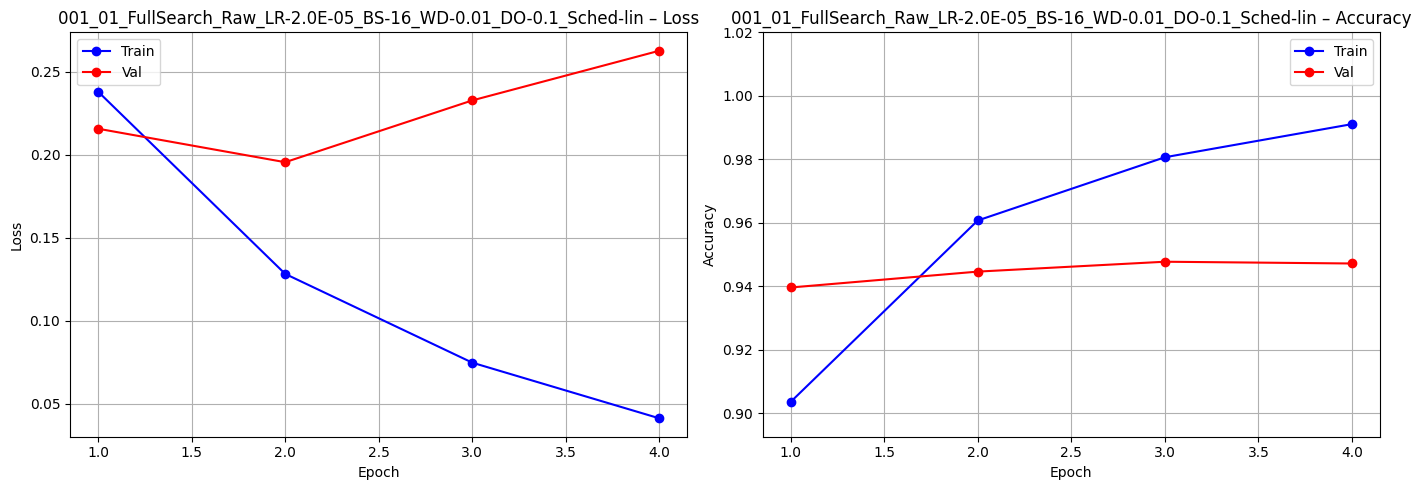

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_detailed.png


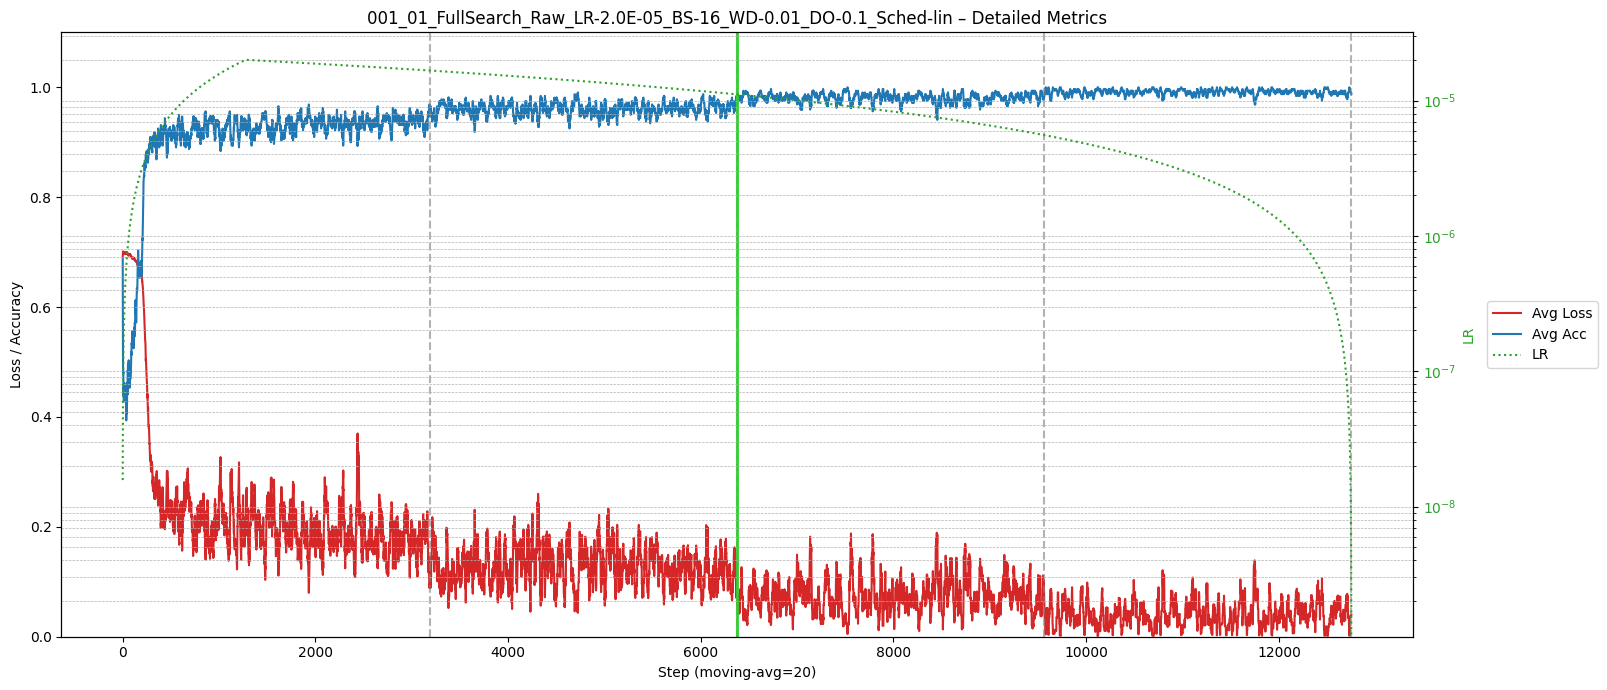

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_loss_vs_lr.png


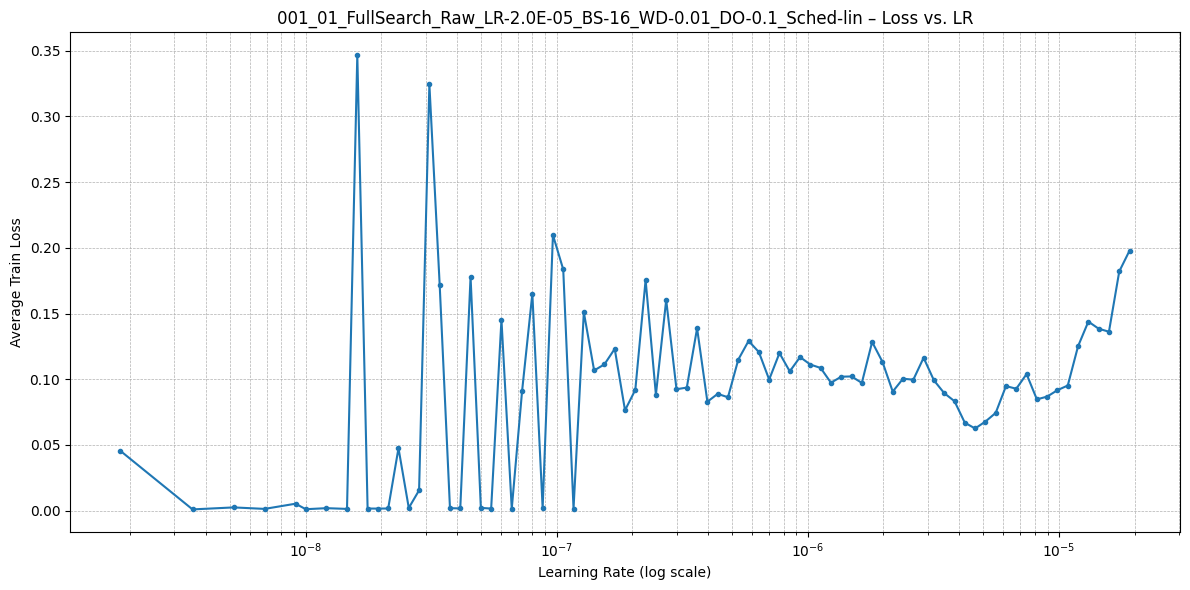


Cleaning up ...
Cleanup complete.

✔️  Experiment 001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin finished  (Completed)
--- Phase 1 Experiment '001_01_FullSearch_Raw_LR-2.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin' finished with status: Completed ---
Sleeping 5s before next run...

------------------------------------------------------------
Running Phase 1 Experiment 2/12 : 002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
------------------------------------------------------------

================  Starting Experiment: 002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 4e-05,
    "batch_size": 16,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "data": {
    "text_column": "content"
 

  Epoch 1  Train  --  Loss: 0.2337,  Acc: 0.9118


  Epoch 1  Valid  --  Loss: 0.2308,  Acc: 0.9332,  F1: 0.9329
  Saving best model (epoch 1, val loss: 0.2308)


  Epoch 2  Train  --  Loss: 0.1272,  Acc: 0.9614


  Epoch 2  Valid  --  Loss: 0.1914,  Acc: 0.9467,  F1: 0.9479
  Saving best model (epoch 2, val loss: 0.1914)


  Epoch 3  Train  --  Loss: 0.0627,  Acc: 0.9845


  Epoch 3  Valid  --  Loss: 0.2407,  Acc: 0.9474,  F1: 0.9489
  Patience: 1 / 2


  Epoch 4  Train  --  Loss: 0.0259,  Acc: 0.9948


  Epoch 4  Valid  --  Loss: 0.2926,  Acc: 0.9471,  F1: 0.9484
  Patience: 2 / 2
Early stopping.

🏁  Training finished.  Duration: 388.79s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1937
  accuracy: 0.9465
  f1: 0.9477
  precision: 0.9493
  recall: 0.9461

---  Experiment Report  ---
Report for DistilBERT -> 002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
Config: Data=content, Freeze=none, LoRA=False, LR=4.0E-05, BS=16, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9467
Best Validation Loss: 0.1914
Test Performance -> 002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
Test Loss: 0.1937, Accuracy: 0.9465, F1 Score: 0.9477

Confusion Matrix:
[[4617  259]
 [ 276 4848]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9436    0.9469    0.9452      4876
      Pos(1)     0.9493    0.9461    0.9477      5124

    accuracy                         0.9465     10000
   macro avg     0.9464    0.9465    0.9465     10000
weighted avg     0.9465    0.9465    0.9465     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_reports/002_01_FullSearc

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_embeddings.npy, 002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_validation_embeddings.npy, 002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_test_embeddings.npy, 002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_val.png


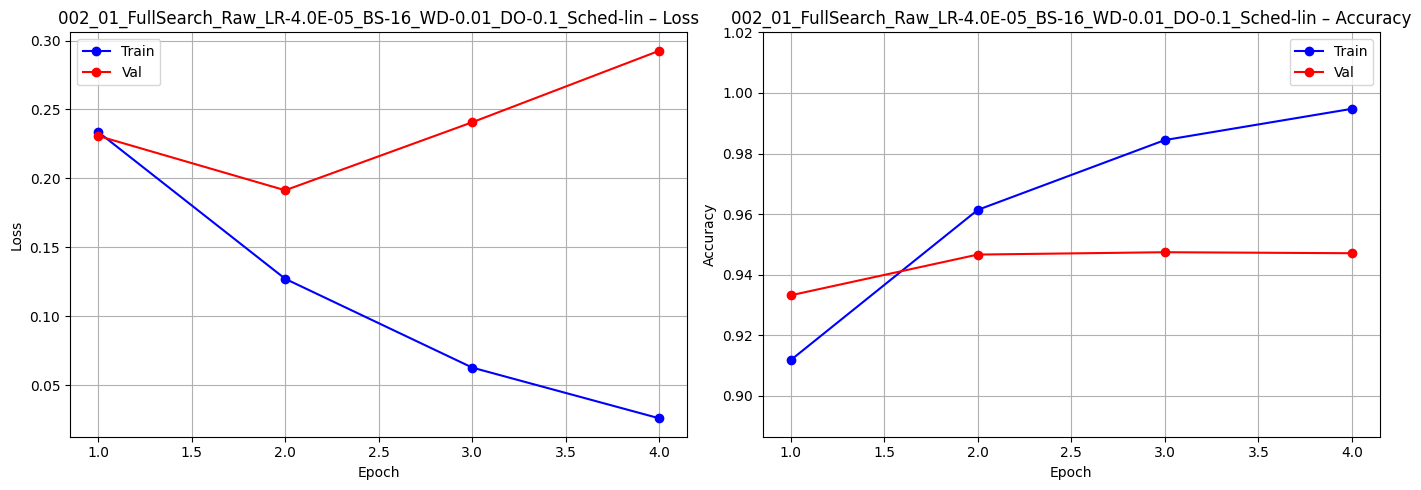

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_detailed.png


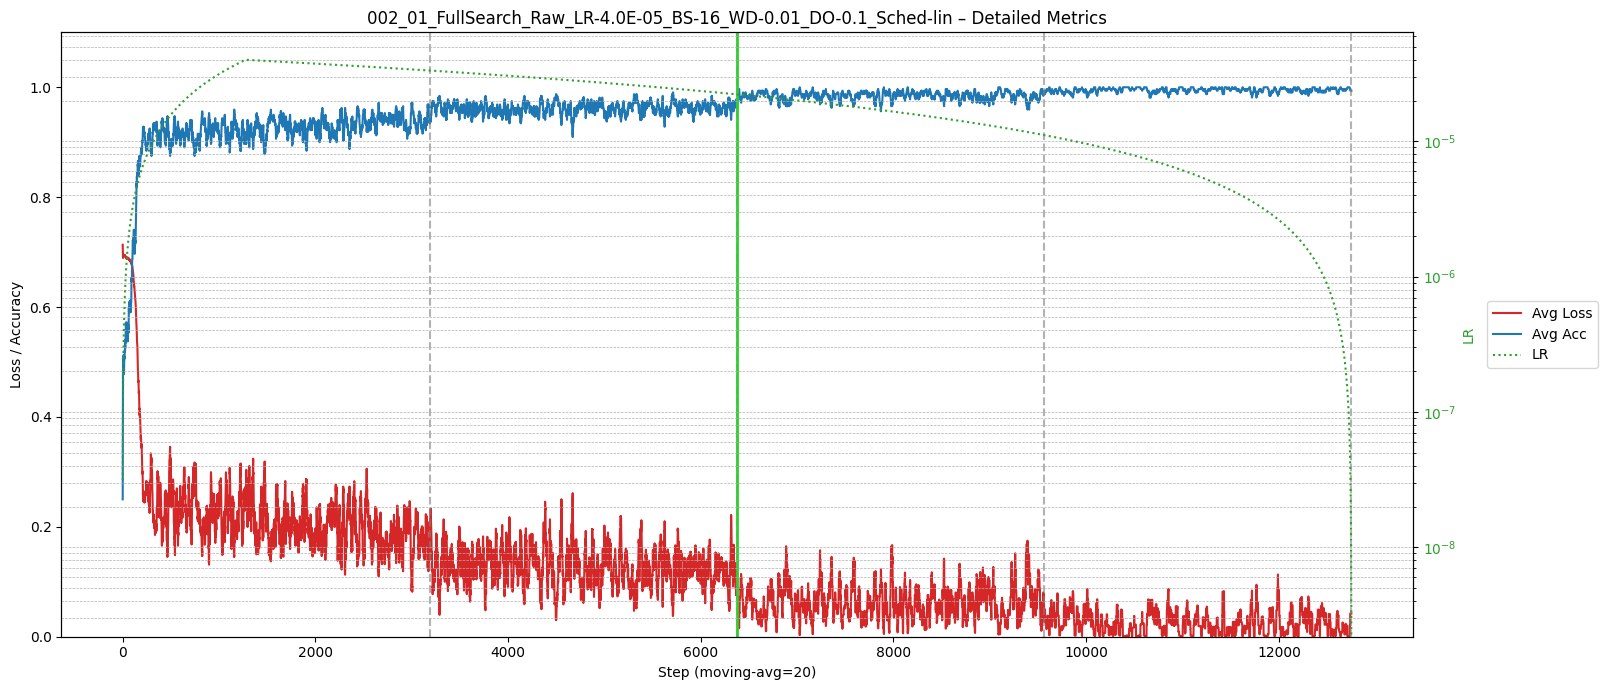

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_loss_vs_lr.png


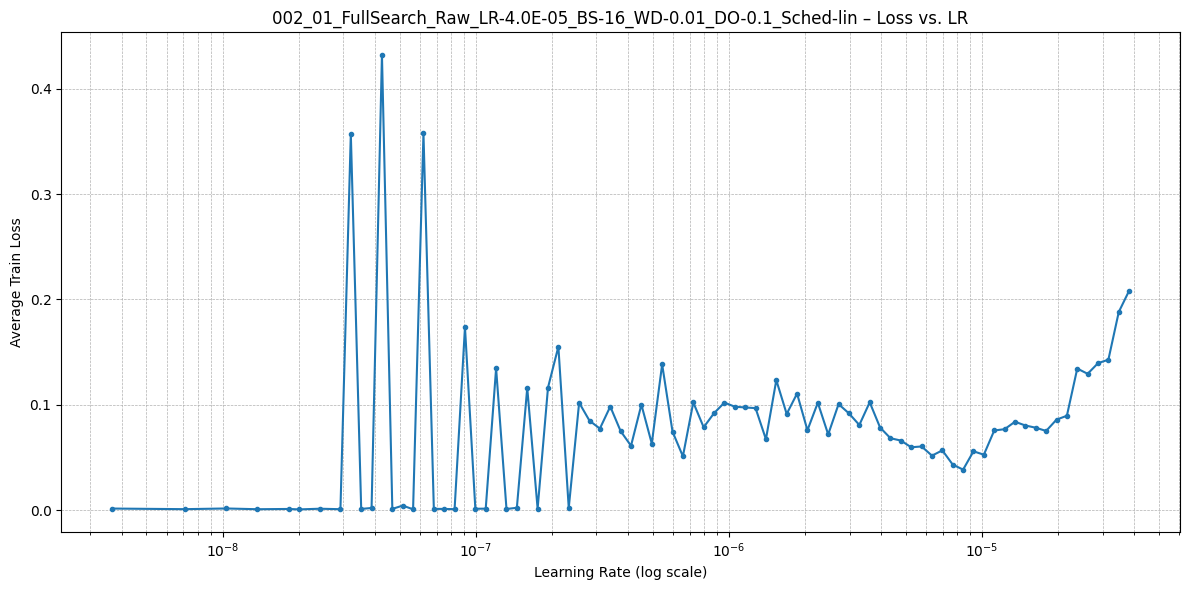


Cleaning up ...
Cleanup complete.

✔️  Experiment 002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin finished  (Completed)
--- Phase 1 Experiment '002_01_FullSearch_Raw_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin' finished with status: Completed ---
Sleeping 5s before next run...

------------------------------------------------------------
Running Phase 1 Experiment 3/12 : 003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin
------------------------------------------------------------

================  Starting Experiment: 003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 2e-05,
    "batch_size": 32,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "data": {
    "text_column": "content"
 

  Epoch 1  Train  --  Loss: 0.2353,  Acc: 0.9048


  Epoch 1  Valid  --  Loss: 0.1561,  Acc: 0.9443,  F1: 0.9453
  Saving best model (epoch 1, val loss: 0.1561)


  Epoch 2  Train  --  Loss: 0.1187,  Acc: 0.9596


  Epoch 2  Valid  --  Loss: 0.1699,  Acc: 0.9470,  F1: 0.9490
  Patience: 1 / 2


  Epoch 3  Train  --  Loss: 0.0717,  Acc: 0.9797


  Epoch 3  Valid  --  Loss: 0.1969,  Acc: 0.9480,  F1: 0.9492
  Patience: 2 / 2
Early stopping.

🏁  Training finished.  Duration: 163.66s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1586
  accuracy: 0.9425
  f1: 0.9435
  precision: 0.9500
  recall: 0.9372

---  Experiment Report  ---
Report for DistilBERT -> 003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin
Config: Data=content, Freeze=none, LoRA=False, LR=2.0E-05, BS=32, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9443
Best Validation Loss: 0.1561
Test Performance -> 003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin
Test Loss: 0.1586, Accuracy: 0.9425, F1 Score: 0.9435

Confusion Matrix:
[[4623  253]
 [ 322 4802]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9349    0.9481    0.9415      4876
      Pos(1)     0.9500    0.9372    0.9435      5124

    accuracy                         0.9425     10000
   macro avg     0.9424    0.9426    0.9425     10000
weighted avg     0.9426    0.9425    0.9425     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_reports/003_01_FullSearc

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_train_embeddings.npy, 003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_validation_embeddings.npy, 003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_test_embeddings.npy, 003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin/003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_train_val.png


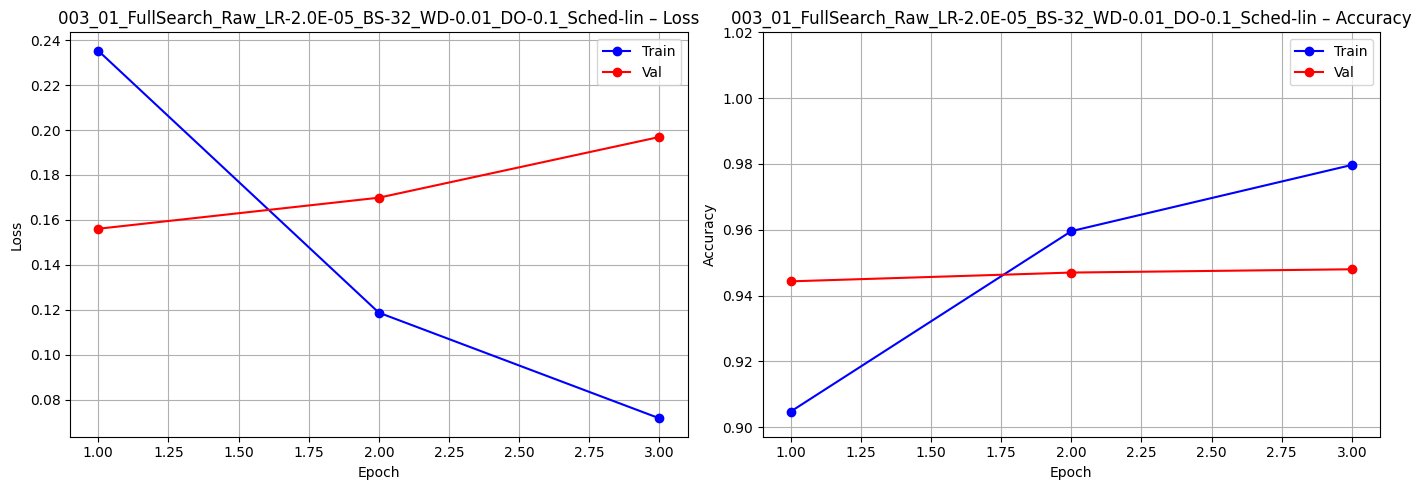

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin/003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_detailed.png


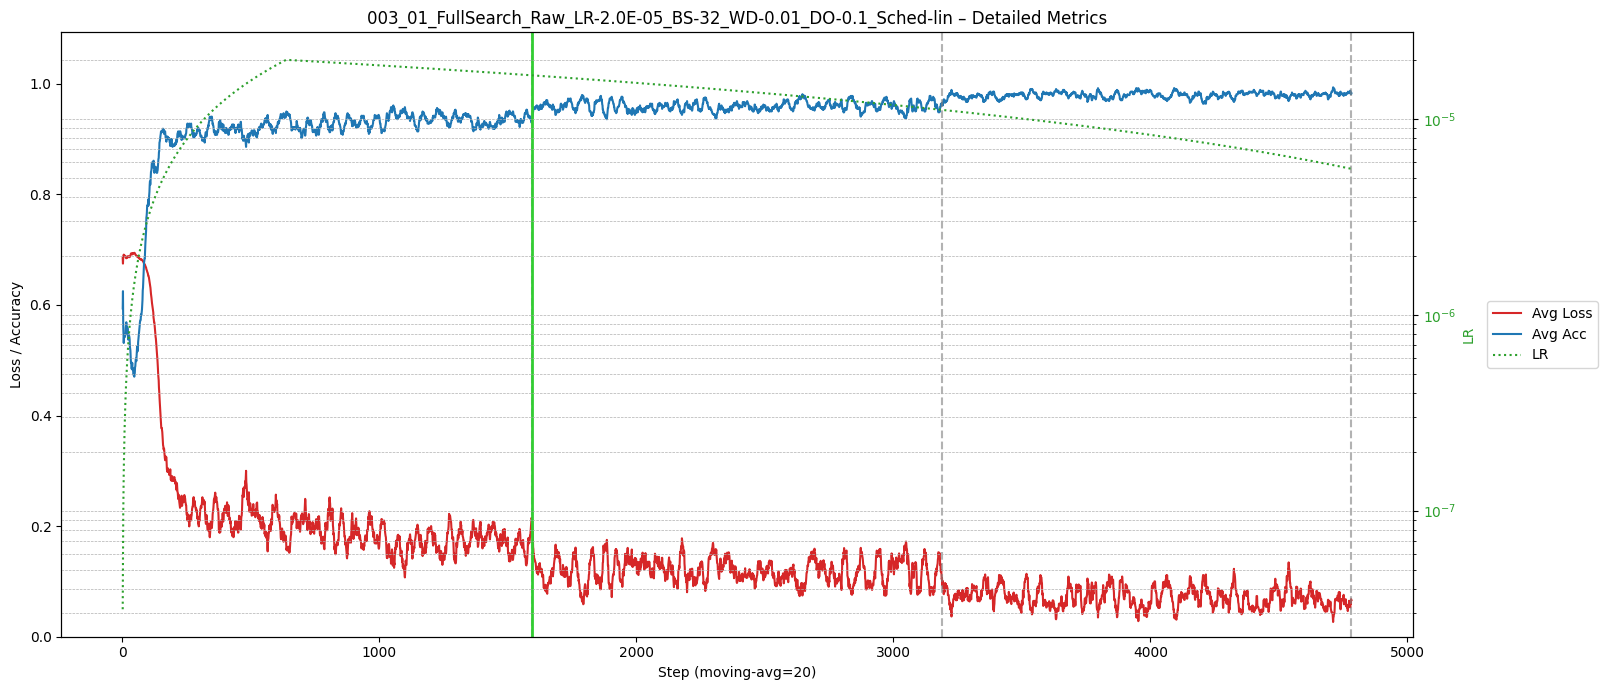

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin/003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_loss_vs_lr.png


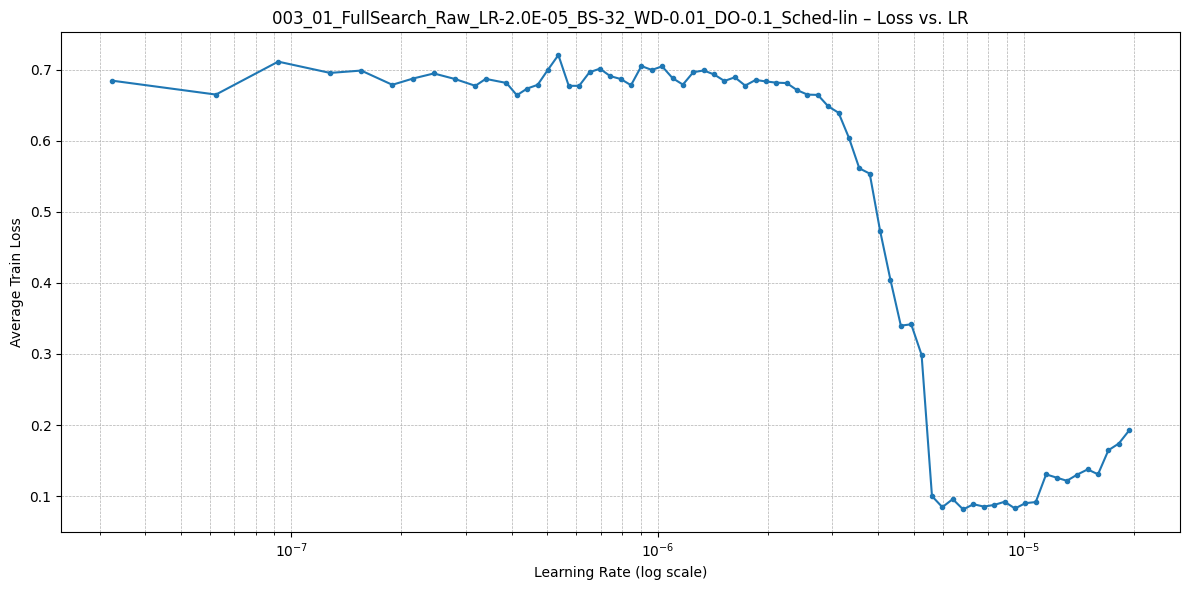


Cleaning up ...
Cleanup complete.

✔️  Experiment 003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin finished  (Completed)
--- Phase 1 Experiment '003_01_FullSearch_Raw_LR-2.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin' finished with status: Completed ---
Sleeping 5s before next run...

------------------------------------------------------------
Running Phase 1 Experiment 4/12 : 004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin
------------------------------------------------------------

================  Starting Experiment: 004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 4e-05,
    "batch_size": 32,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "data": {
    "text_column": "content"
 

  Epoch 1  Train  --  Loss: 0.2288,  Acc: 0.9051


  Epoch 1  Valid  --  Loss: 0.1647,  Acc: 0.9427,  F1: 0.9434
  Saving best model (epoch 1, val loss: 0.1647)


  Epoch 2  Train  --  Loss: 0.1083,  Acc: 0.9644


  Epoch 2  Valid  --  Loss: 0.1976,  Acc: 0.9464,  F1: 0.9478
  Patience: 1 / 2


  Epoch 3  Train  --  Loss: 0.0540,  Acc: 0.9857


  Epoch 3  Valid  --  Loss: 0.2285,  Acc: 0.9463,  F1: 0.9471
  Patience: 2 / 2
Early stopping.

🏁  Training finished.  Duration: 163.61s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1694
  accuracy: 0.9407
  f1: 0.9414
  precision: 0.9534
  recall: 0.9297

---  Experiment Report  ---
Report for DistilBERT -> 004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin
Config: Data=content, Freeze=none, LoRA=False, LR=4.0E-05, BS=32, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9427
Best Validation Loss: 0.1647
Test Performance -> 004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin
Test Loss: 0.1694, Accuracy: 0.9407, F1 Score: 0.9414

Confusion Matrix:
[[4643  233]
 [ 360 4764]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9280    0.9522    0.9400      4876
      Pos(1)     0.9534    0.9297    0.9414      5124

    accuracy                         0.9407     10000
   macro avg     0.9407    0.9410    0.9407     10000
weighted avg     0.9410    0.9407    0.9407     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_reports/004_01_FullSearc

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_train_embeddings.npy, 004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_validation_embeddings.npy, 004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_test_embeddings.npy, 004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin/004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_train_val.png


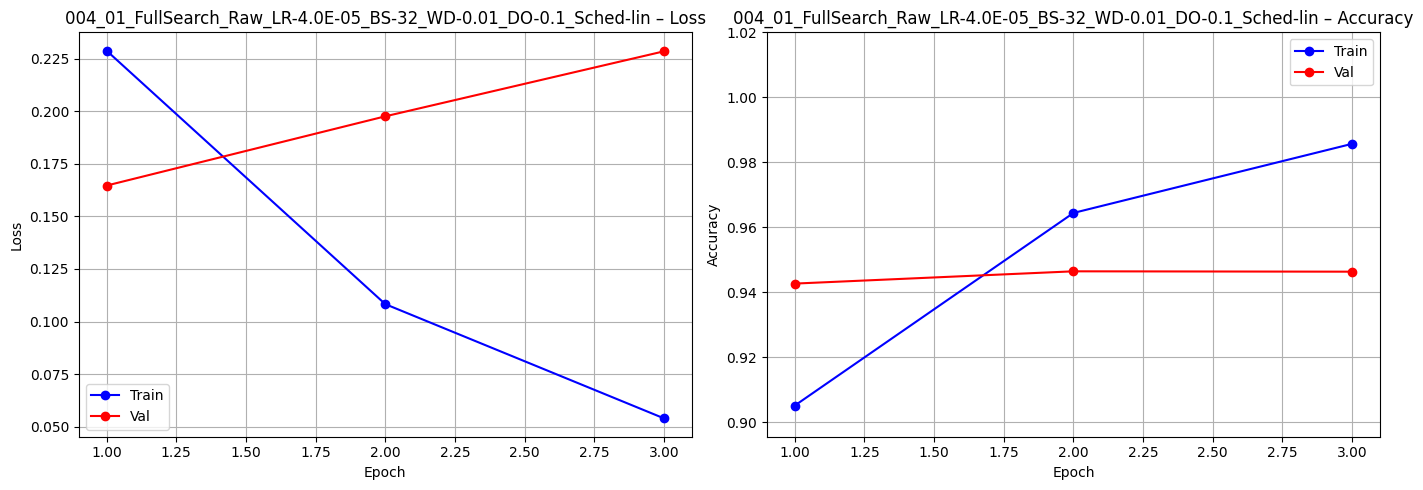

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin/004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_detailed.png


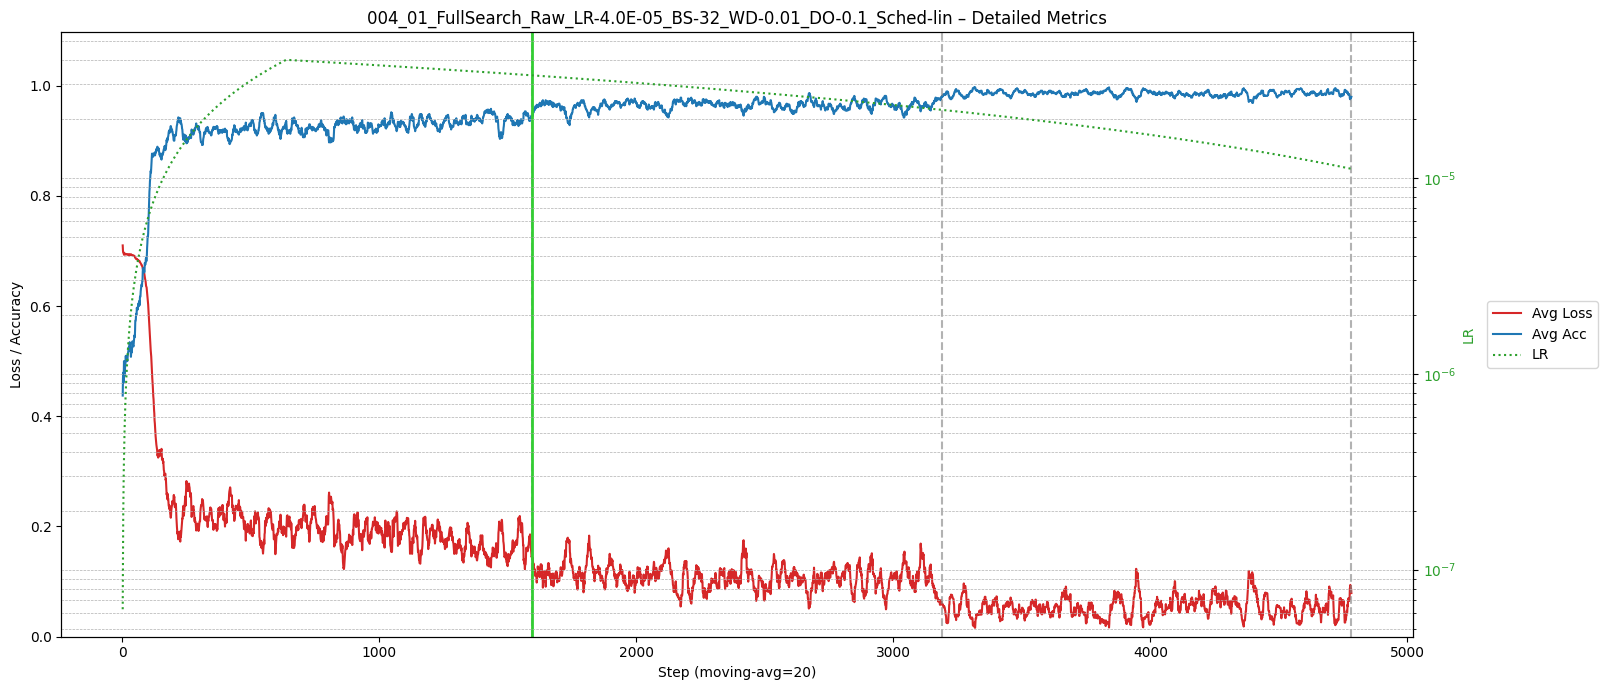

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin/004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_loss_vs_lr.png


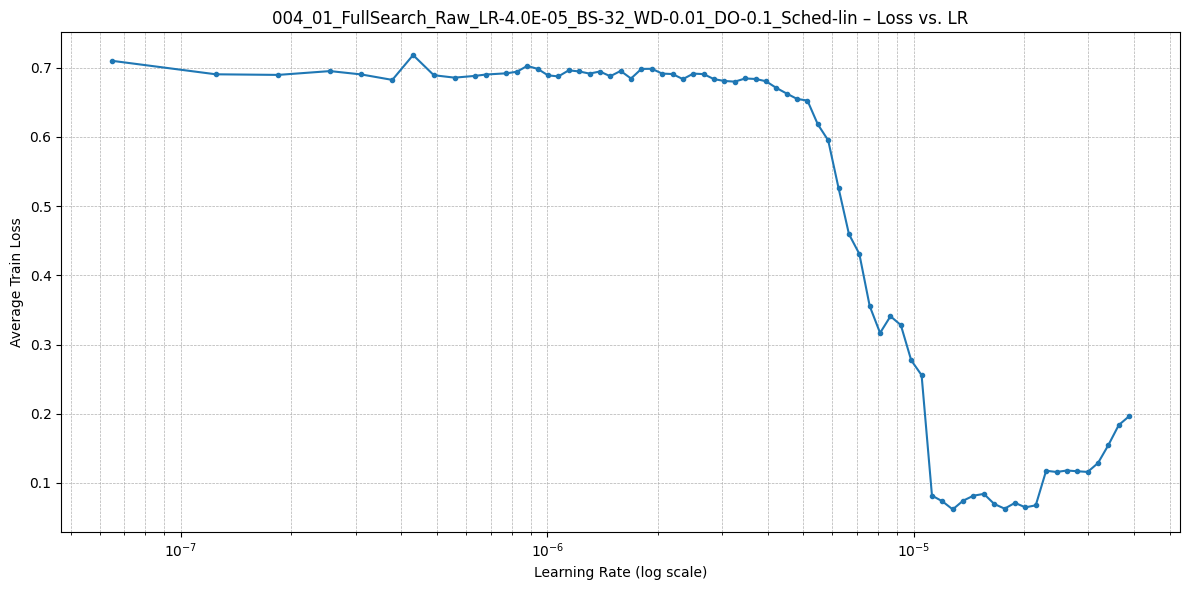


Cleaning up ...
Cleanup complete.

✔️  Experiment 004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin finished  (Completed)
--- Phase 1 Experiment '004_01_FullSearch_Raw_LR-4.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin' finished with status: Completed ---
Sleeping 5s before next run...

------------------------------------------------------------
Running Phase 1 Experiment 5/12 : 005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
------------------------------------------------------------

================  Starting Experiment: 005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 5e-05,
    "batch_size": 16,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "data": {
    "text_co

  Epoch 1  Train  --  Loss: 0.2843,  Acc: 0.8755


  Epoch 1  Valid  --  Loss: 0.1937,  Acc: 0.9260,  F1: 0.9272
  Saving best model (epoch 1, val loss: 0.1937)


  Epoch 2  Train  --  Loss: 0.1919,  Acc: 0.9278


  Epoch 2  Valid  --  Loss: 0.1933,  Acc: 0.9326,  F1: 0.9343
  Patience: 1 / 2


  Epoch 3  Train  --  Loss: 0.1803,  Acc: 0.9333


  Epoch 3  Valid  --  Loss: 0.1902,  Acc: 0.9342,  F1: 0.9360
  Saving best model (epoch 3, val loss: 0.1902)


  Epoch 4  Train  --  Loss: 0.1744,  Acc: 0.9349


  Epoch 4  Valid  --  Loss: 0.1872,  Acc: 0.9347,  F1: 0.9363
  Saving best model (epoch 4, val loss: 0.1872)

🏁  Training finished.  Duration: 355.40s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1873
  accuracy: 0.9322
  f1: 0.9337
  precision: 0.9357
  recall: 0.9317

---  Experiment Report  ---
Report for DistilBERT -> 005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
Config: Data=content, Freeze=none, LoRA=True, LR=5.0E-05, BS=16, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9347
Best Validation Loss: 0.1872
Test Performance -> 005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
Test Loss: 0.1873, Accuracy: 0.9322, F1 Score: 0.9337

Confusion Matrix:
[[4548  328]
 [ 350 4774]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9285    0.9327    0.9306      4876
      Pos(1)     0.9357    0.9317    0.9337      5124

    accuracy                         0.9322     10000
   macro avg     0.9321    0.9322    0.9322     10000
weighted avg     0.9322    0.9322    0.9322     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_reports

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_embeddings.npy, 005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_validation_embeddings.npy, 005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_test_embeddings.npy, 005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_val.png


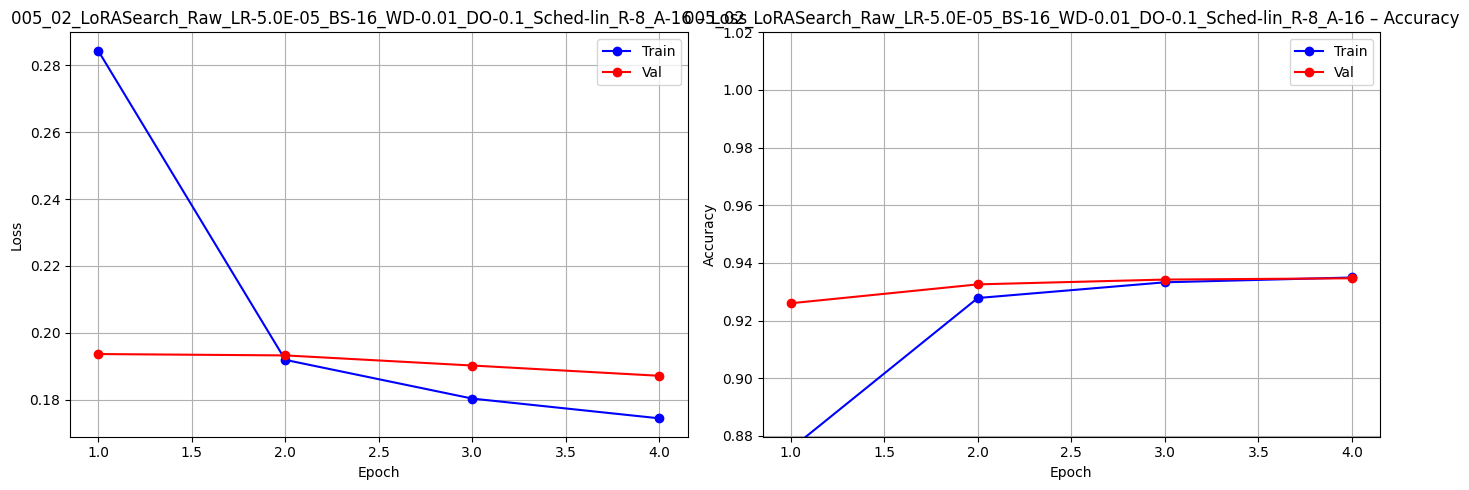

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_detailed.png


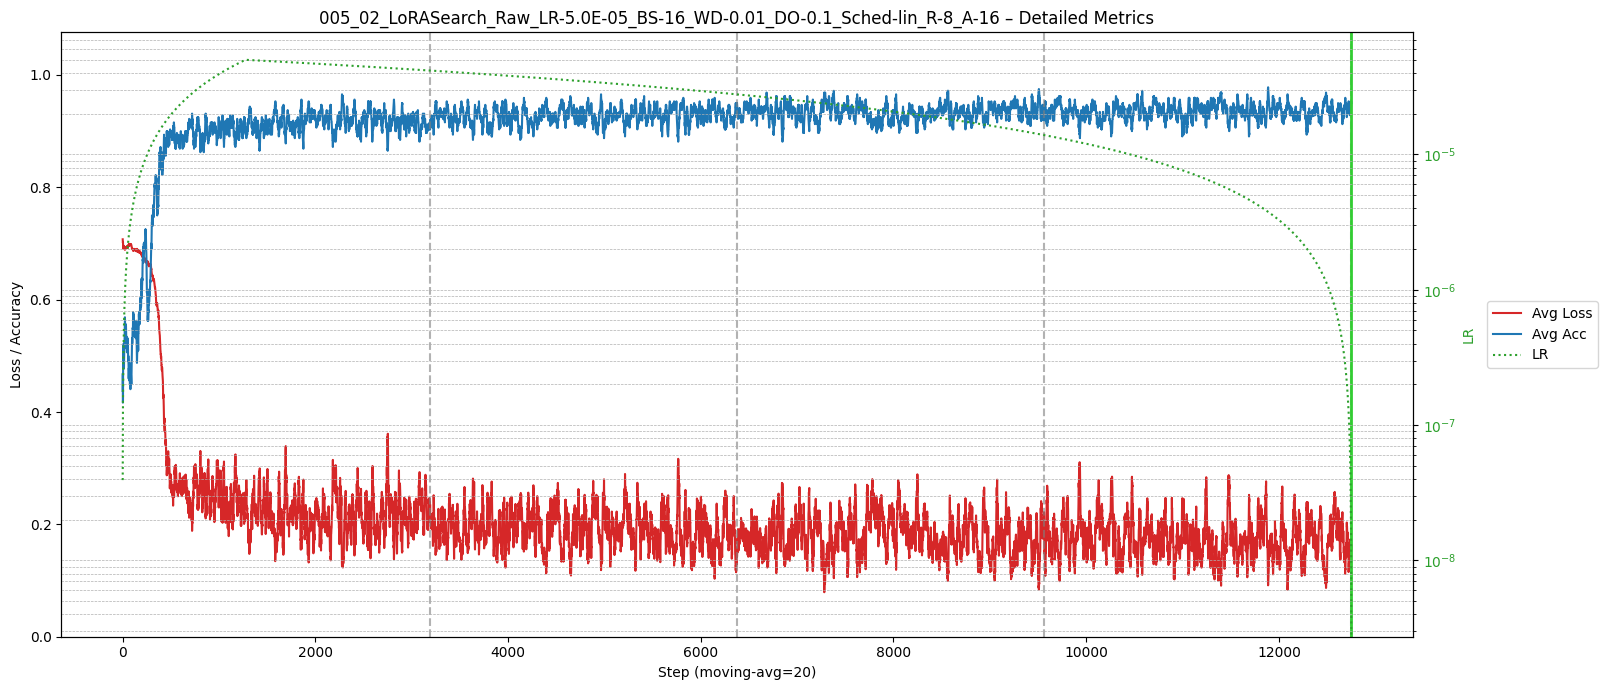

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_loss_vs_lr.png


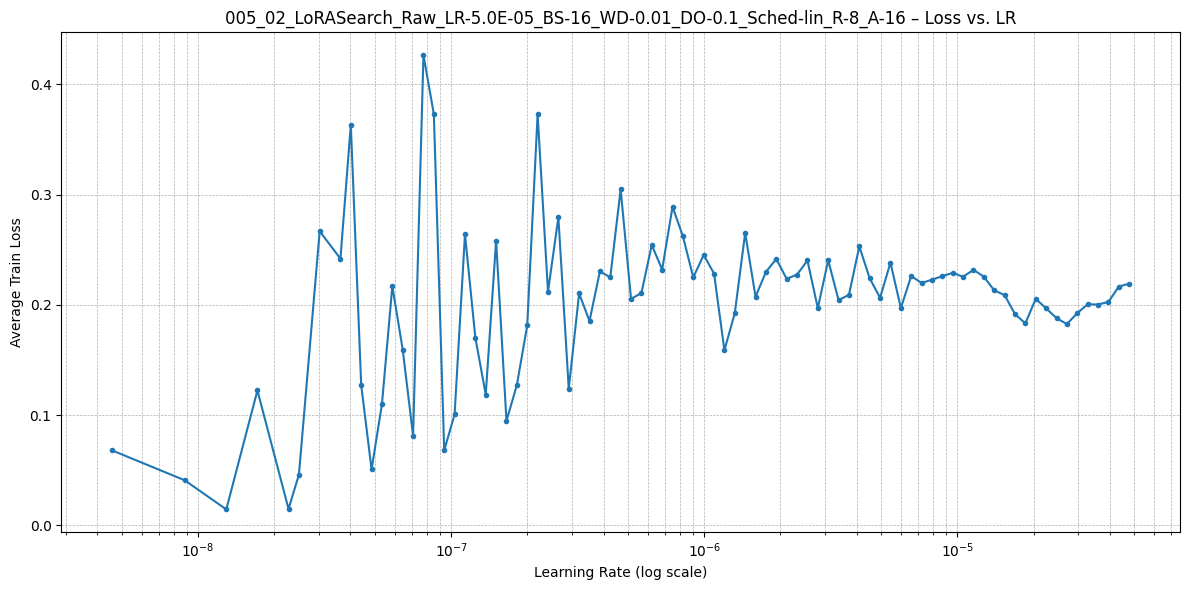


Cleaning up ...
Cleanup complete.

✔️  Experiment 005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16 finished  (Completed)
--- Phase 1 Experiment '005_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16' finished with status: Completed ---
Sleeping 5s before next run...

------------------------------------------------------------
Running Phase 1 Experiment 6/12 : 006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
------------------------------------------------------------

================  Starting Experiment: 006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 5e-05,
    "batch_size": 16,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "d

  Epoch 1  Train  --  Loss: 0.2729,  Acc: 0.8832


  Epoch 1  Valid  --  Loss: 0.1963,  Acc: 0.9280,  F1: 0.9309
  Saving best model (epoch 1, val loss: 0.1963)


  Epoch 2  Train  --  Loss: 0.1879,  Acc: 0.9310


  Epoch 2  Valid  --  Loss: 0.1874,  Acc: 0.9348,  F1: 0.9366
  Saving best model (epoch 2, val loss: 0.1874)


  Epoch 3  Train  --  Loss: 0.1734,  Acc: 0.9365


  Epoch 3  Valid  --  Loss: 0.1805,  Acc: 0.9369,  F1: 0.9383
  Saving best model (epoch 3, val loss: 0.1805)


  Epoch 4  Train  --  Loss: 0.1653,  Acc: 0.9396


  Epoch 4  Valid  --  Loss: 0.1859,  Acc: 0.9378,  F1: 0.9393
  Patience: 1 / 2

🏁  Training finished.  Duration: 357.36s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1802
  accuracy: 0.9350
  f1: 0.9361
  precision: 0.9430
  recall: 0.9294

---  Experiment Report  ---
Report for DistilBERT -> 006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
Config: Data=content, Freeze=none, LoRA=True, LR=5.0E-05, BS=16, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9369
Best Validation Loss: 0.1805
Test Performance -> 006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
Test Loss: 0.1802, Accuracy: 0.9350, F1 Score: 0.9361

Confusion Matrix:
[[4588  288]
 [ 362 4762]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9269    0.9409    0.9338      4876
      Pos(1)     0.9430    0.9294    0.9361      5124

    accuracy                         0.9350     10000
   macro avg     0.9349    0.9351    0.9350     10000
weighted avg     0.9351    0.9350    0.9350     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_repor

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_embeddings.npy, 006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_validation_embeddings.npy, 006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_test_embeddings.npy, 006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_val.png


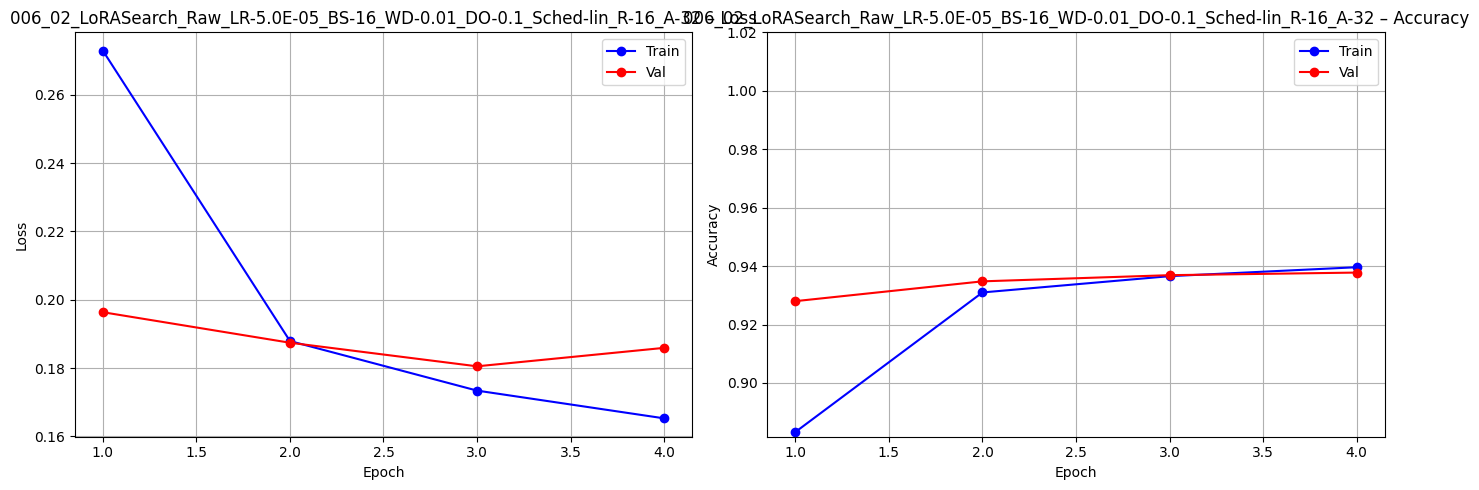

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_detailed.png


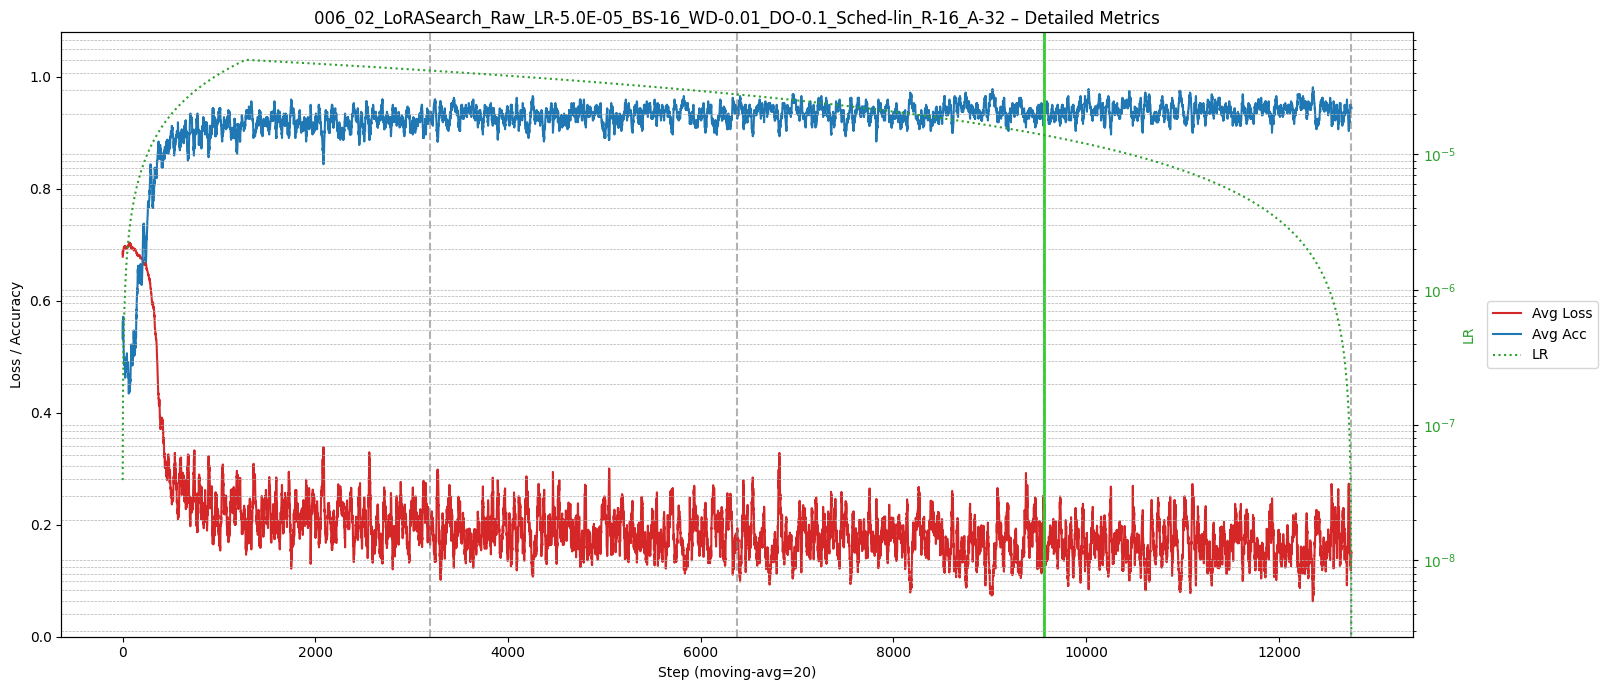

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_loss_vs_lr.png


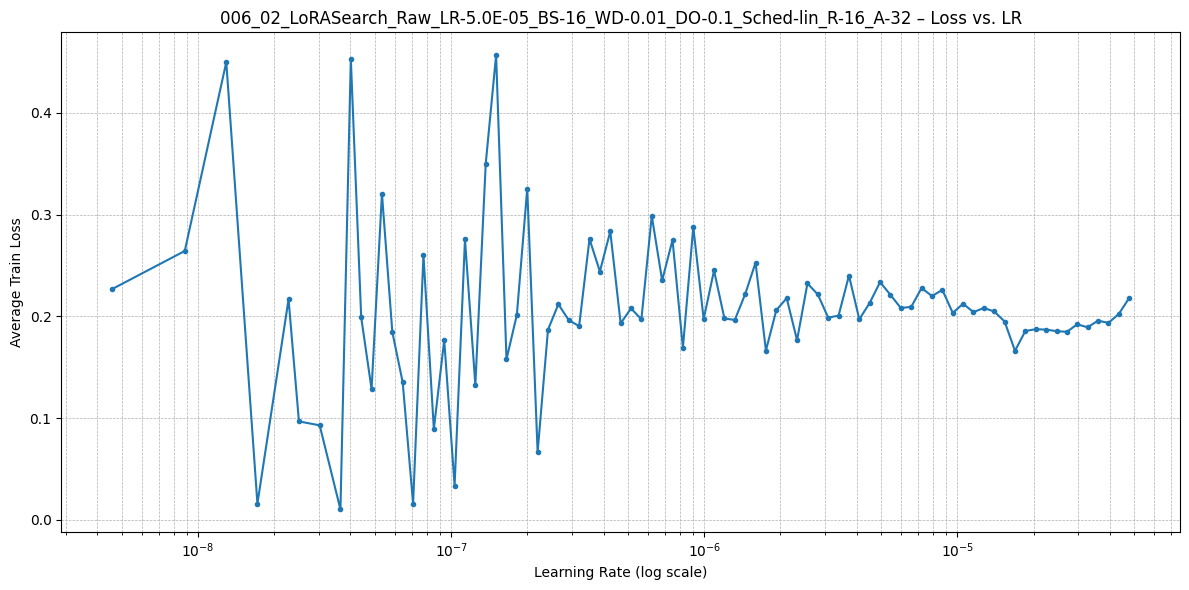


Cleaning up ...
Cleanup complete.

✔️  Experiment 006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32 finished  (Completed)
--- Phase 1 Experiment '006_02_LoRASearch_Raw_LR-5.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32' finished with status: Completed ---
Sleeping 5s before next run...

------------------------------------------------------------
Running Phase 1 Experiment 7/12 : 007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
------------------------------------------------------------

================  Starting Experiment: 007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 0.0001,
    "batch_size": 16,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "

  Epoch 1  Train  --  Loss: 0.2587,  Acc: 0.8947


  Epoch 1  Valid  --  Loss: 0.1866,  Acc: 0.9311,  F1: 0.9324
  Saving best model (epoch 1, val loss: 0.1866)


  Epoch 2  Train  --  Loss: 0.1804,  Acc: 0.9321


  Epoch 2  Valid  --  Loss: 0.1786,  Acc: 0.9366,  F1: 0.9383
  Saving best model (epoch 2, val loss: 0.1786)


  Epoch 3  Train  --  Loss: 0.1638,  Acc: 0.9399


  Epoch 3  Valid  --  Loss: 0.1826,  Acc: 0.9367,  F1: 0.9389
  Patience: 1 / 2


  Epoch 4  Train  --  Loss: 0.1551,  Acc: 0.9442


  Epoch 4  Valid  --  Loss: 0.1787,  Acc: 0.9390,  F1: 0.9407
  Patience: 2 / 2
Early stopping.

🏁  Training finished.  Duration: 358.06s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1781
  accuracy: 0.9367
  f1: 0.9382
  precision: 0.9390
  recall: 0.9374

---  Experiment Report  ---
Report for DistilBERT -> 007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
Config: Data=content, Freeze=none, LoRA=True, LR=1.0E-04, BS=16, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9366
Best Validation Loss: 0.1786
Test Performance -> 007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
Test Loss: 0.1781, Accuracy: 0.9367, F1 Score: 0.9382

Confusion Matrix:
[[4564  312]
 [ 321 4803]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9343    0.9360    0.9352      4876
      Pos(1)     0.9390    0.9374    0.9382      5124

    accuracy                         0.9367     10000
   macro avg     0.9366    0.9367    0.9367     10000
weighted avg     0.9367    0.9367    0.9367     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_reports

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_embeddings.npy, 007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_validation_embeddings.npy, 007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_test_embeddings.npy, 007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_val.png


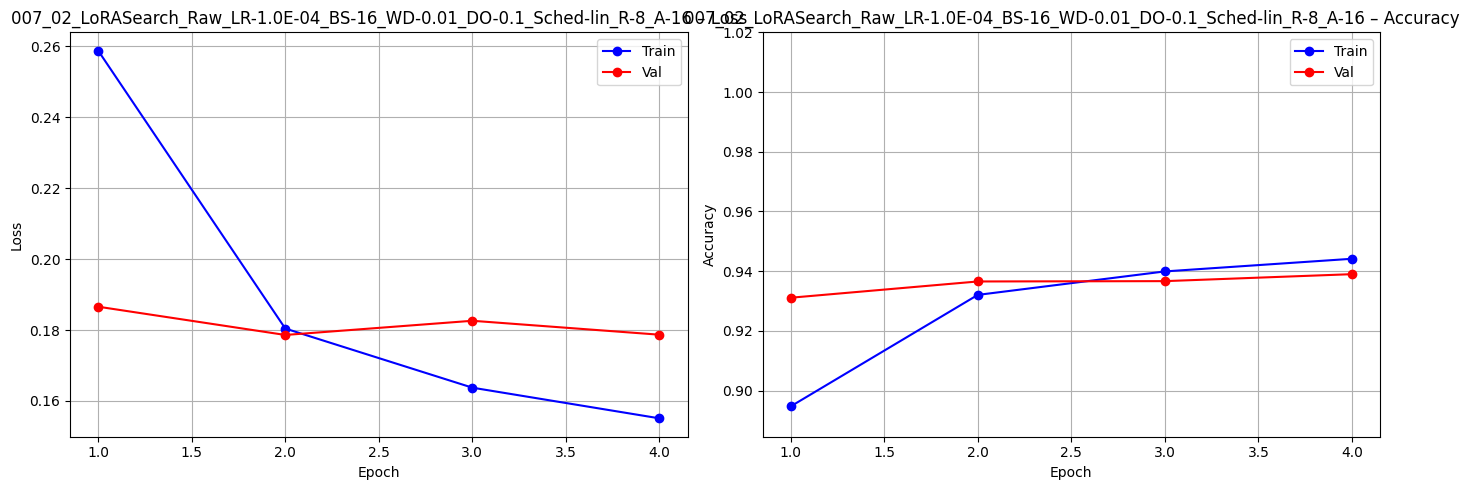

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_detailed.png


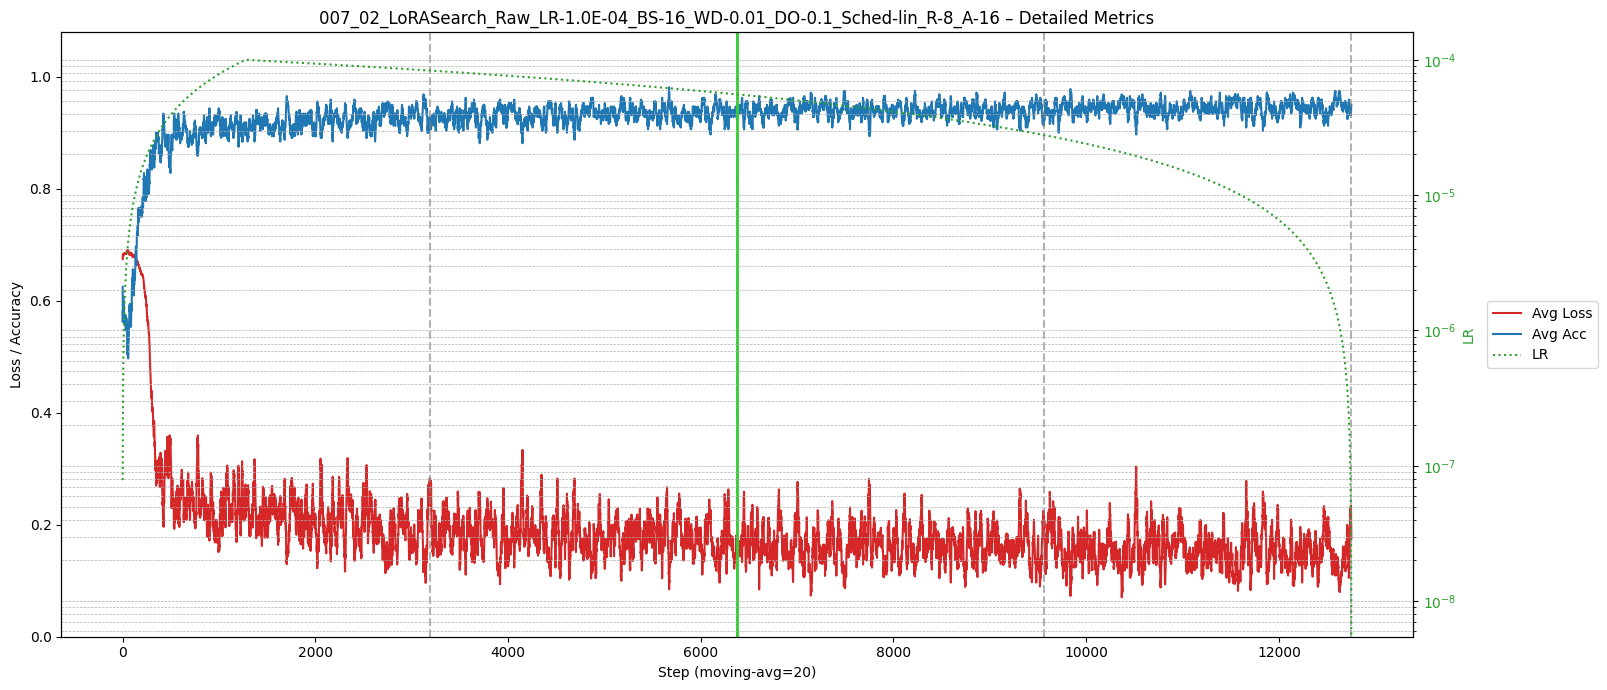

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_loss_vs_lr.png


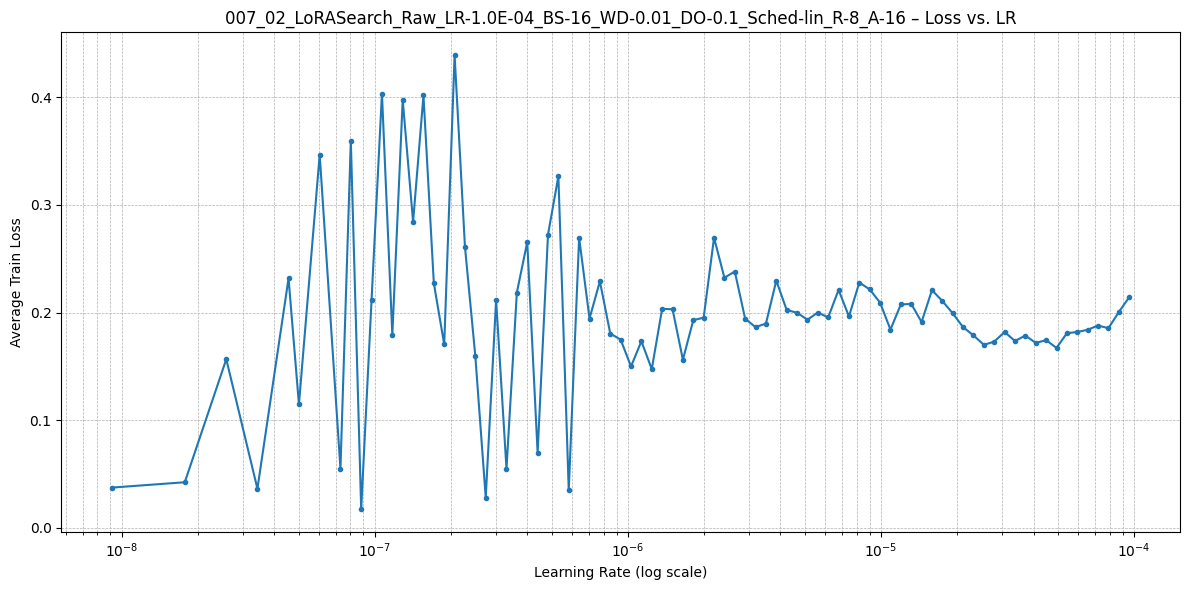


Cleaning up ...
Cleanup complete.

✔️  Experiment 007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16 finished  (Completed)
--- Phase 1 Experiment '007_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-8_A-16' finished with status: Completed ---
Sleeping 5s before next run...

------------------------------------------------------------
Running Phase 1 Experiment 8/12 : 008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
------------------------------------------------------------

================  Starting Experiment: 008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 0.0001,
    "batch_size": 16,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "

  Epoch 1  Train  --  Loss: 0.2568,  Acc: 0.8888


  Epoch 1  Valid  --  Loss: 0.1832,  Acc: 0.9313,  F1: 0.9332
  Saving best model (epoch 1, val loss: 0.1832)


  Epoch 2  Train  --  Loss: 0.1757,  Acc: 0.9346


  Epoch 2  Valid  --  Loss: 0.1680,  Acc: 0.9380,  F1: 0.9396
  Saving best model (epoch 2, val loss: 0.1680)


  Epoch 3  Train  --  Loss: 0.1566,  Acc: 0.9427


  Epoch 3  Valid  --  Loss: 0.1749,  Acc: 0.9389,  F1: 0.9409
  Patience: 1 / 2


  Epoch 4  Train  --  Loss: 0.1461,  Acc: 0.9482


  Epoch 4  Valid  --  Loss: 0.1789,  Acc: 0.9404,  F1: 0.9418
  Patience: 2 / 2
Early stopping.

🏁  Training finished.  Duration: 357.88s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1687
  accuracy: 0.9376
  f1: 0.9391
  precision: 0.9393
  recall: 0.9389

---  Experiment Report  ---
Report for DistilBERT -> 008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
Config: Data=content, Freeze=none, LoRA=True, LR=1.0E-04, BS=16, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9380
Best Validation Loss: 0.1680
Test Performance -> 008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
Test Loss: 0.1687, Accuracy: 0.9376, F1 Score: 0.9391

Confusion Matrix:
[[4565  311]
 [ 313 4811]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9358    0.9362    0.9360      4876
      Pos(1)     0.9393    0.9389    0.9391      5124

    accuracy                         0.9376     10000
   macro avg     0.9376    0.9376    0.9376     10000
weighted avg     0.9376    0.9376    0.9376     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_repor

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_embeddings.npy, 008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_validation_embeddings.npy, 008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_test_embeddings.npy, 008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_val.png


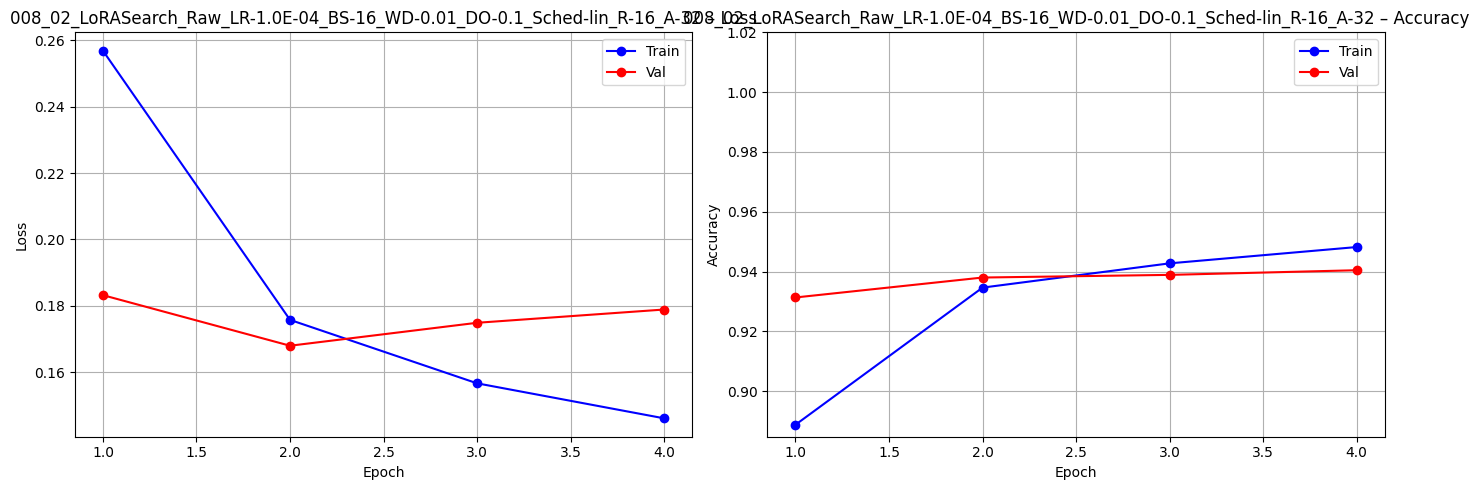

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_detailed.png


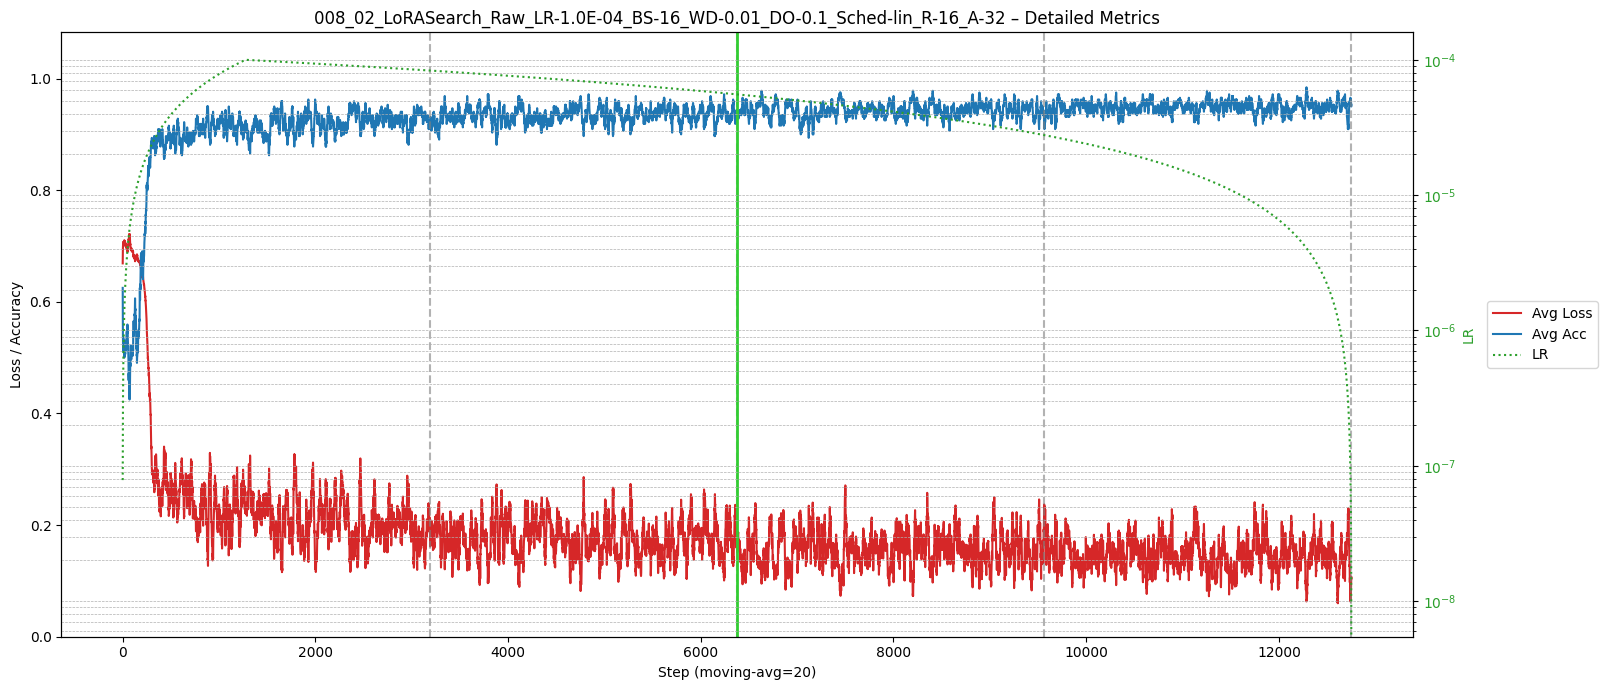

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_loss_vs_lr.png


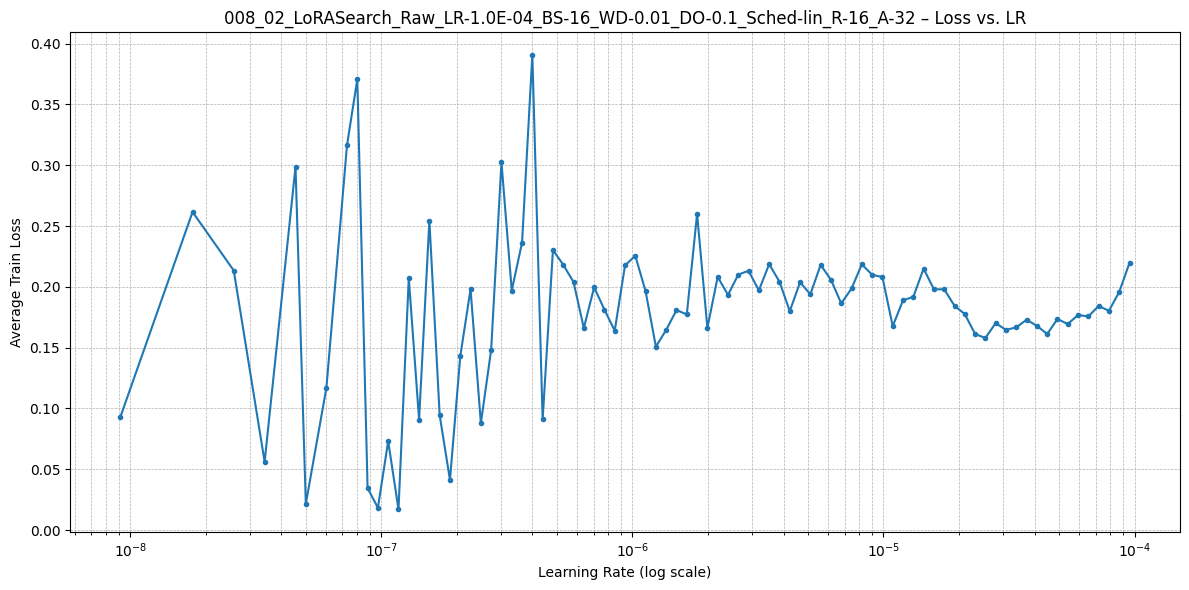


Cleaning up ...
Cleanup complete.

✔️  Experiment 008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32 finished  (Completed)
--- Phase 1 Experiment '008_02_LoRASearch_Raw_LR-1.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_R-16_A-32' finished with status: Completed ---
Sleeping 5s before next run...

------------------------------------------------------------
Running Phase 1 Experiment 9/12 : 009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
------------------------------------------------------------

================  Starting Experiment: 009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 5e-05,
    "batch_size": 32,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "d

  Epoch 1  Train  --  Loss: 0.2996,  Acc: 0.8692


  Epoch 1  Valid  --  Loss: 0.2000,  Acc: 0.9247,  F1: 0.9276
  Saving best model (epoch 1, val loss: 0.2000)


  Epoch 2  Train  --  Loss: 0.1936,  Acc: 0.9252


  Epoch 2  Valid  --  Loss: 0.1877,  Acc: 0.9311,  F1: 0.9333
  Saving best model (epoch 2, val loss: 0.1877)


  Epoch 3  Train  --  Loss: 0.1816,  Acc: 0.9304


  Epoch 3  Valid  --  Loss: 0.1840,  Acc: 0.9323,  F1: 0.9345
  Saving best model (epoch 3, val loss: 0.1840)


  Epoch 4  Train  --  Loss: 0.1763,  Acc: 0.9330


  Epoch 4  Valid  --  Loss: 0.1816,  Acc: 0.9339,  F1: 0.9355
  Saving best model (epoch 4, val loss: 0.1816)

🏁  Training finished.  Duration: 192.01s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1831
  accuracy: 0.9324
  f1: 0.9339
  precision: 0.9354
  recall: 0.9325

---  Experiment Report  ---
Report for DistilBERT -> 009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
Config: Data=content, Freeze=none, LoRA=True, LR=5.0E-05, BS=32, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9339
Best Validation Loss: 0.1816
Test Performance -> 009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
Test Loss: 0.1831, Accuracy: 0.9324, F1 Score: 0.9339

Confusion Matrix:
[[4546  330]
 [ 346 4778]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9293    0.9323    0.9308      4876
      Pos(1)     0.9354    0.9325    0.9339      5124

    accuracy                         0.9324     10000
   macro avg     0.9323    0.9324    0.9324     10000
weighted avg     0.9324    0.9324    0.9324     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_reports

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_embeddings.npy, 009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_validation_embeddings.npy, 009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_test_embeddings.npy, 009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_val.png


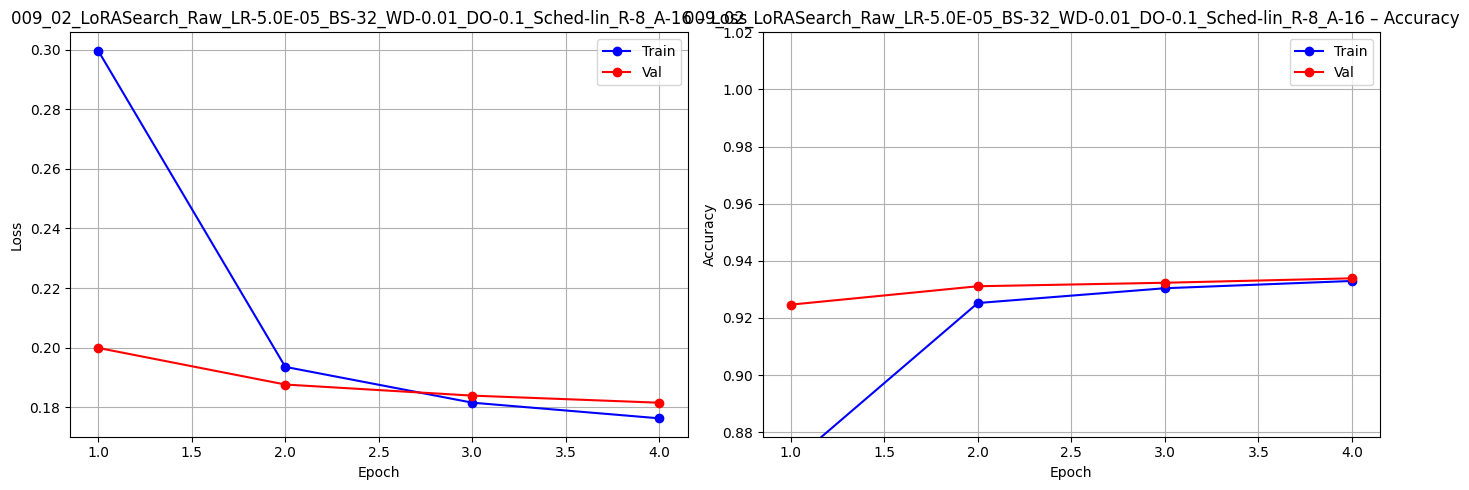

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_detailed.png


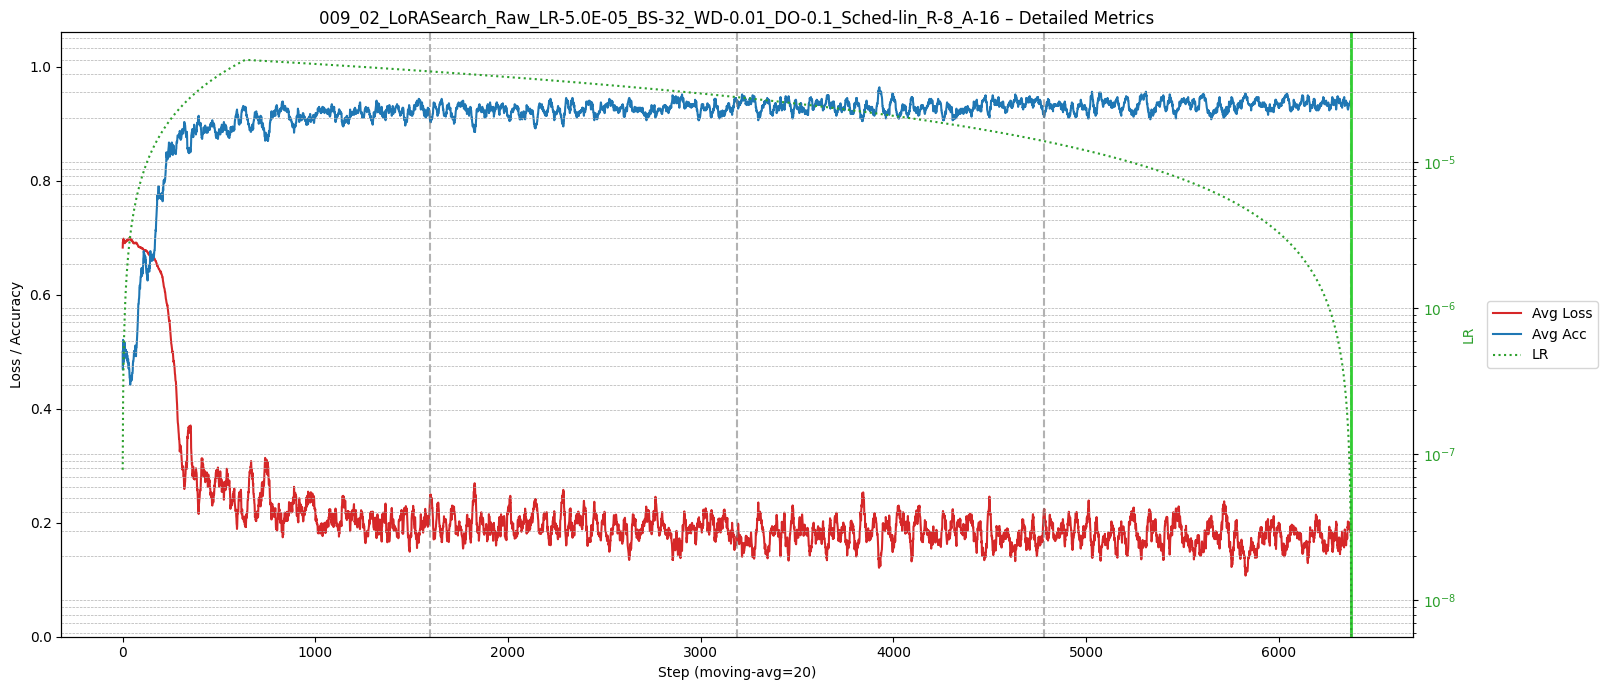

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_loss_vs_lr.png


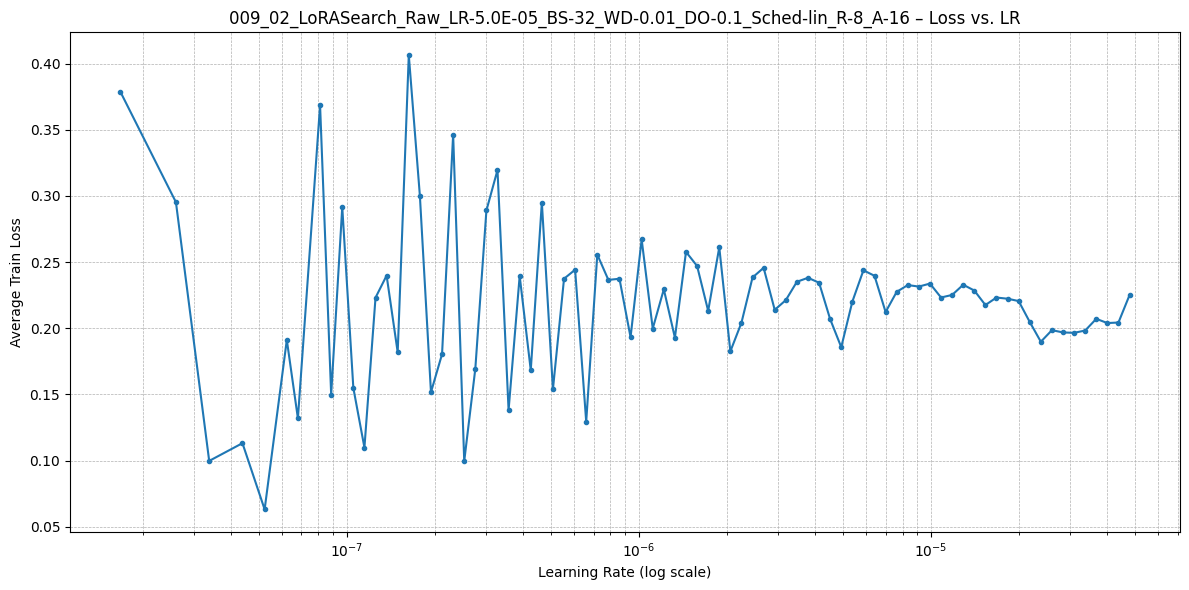


Cleaning up ...
Cleanup complete.

✔️  Experiment 009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16 finished  (Completed)
--- Phase 1 Experiment '009_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16' finished with status: Completed ---
Sleeping 5s before next run...

------------------------------------------------------------
Running Phase 1 Experiment 10/12 : 010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
------------------------------------------------------------

================  Starting Experiment: 010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 5e-05,
    "batch_size": 32,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "

  Epoch 1  Train  --  Loss: 0.2883,  Acc: 0.8736


  Epoch 1  Valid  --  Loss: 0.1953,  Acc: 0.9283,  F1: 0.9310
  Saving best model (epoch 1, val loss: 0.1953)


  Epoch 2  Train  --  Loss: 0.1888,  Acc: 0.9282


  Epoch 2  Valid  --  Loss: 0.1806,  Acc: 0.9332,  F1: 0.9342
  Saving best model (epoch 2, val loss: 0.1806)


  Epoch 3  Train  --  Loss: 0.1754,  Acc: 0.9327


  Epoch 3  Valid  --  Loss: 0.1751,  Acc: 0.9349,  F1: 0.9367
  Saving best model (epoch 3, val loss: 0.1751)


  Epoch 4  Train  --  Loss: 0.1672,  Acc: 0.9371


  Epoch 4  Valid  --  Loss: 0.1759,  Acc: 0.9349,  F1: 0.9368
  Patience: 1 / 2

🏁  Training finished.  Duration: 190.93s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1766
  accuracy: 0.9340
  f1: 0.9356
  precision: 0.9359
  recall: 0.9352

---  Experiment Report  ---
Report for DistilBERT -> 010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
Config: Data=content, Freeze=none, LoRA=True, LR=5.0E-05, BS=32, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9349
Best Validation Loss: 0.1751
Test Performance -> 010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
Test Loss: 0.1766, Accuracy: 0.9340, F1 Score: 0.9356

Confusion Matrix:
[[4548  328]
 [ 332 4792]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9320    0.9327    0.9323      4876
      Pos(1)     0.9359    0.9352    0.9356      5124

    accuracy                         0.9340     10000
   macro avg     0.9340    0.9340    0.9340     10000
weighted avg     0.9340    0.9340    0.9340     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_repor

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_embeddings.npy, 010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_validation_embeddings.npy, 010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_test_embeddings.npy, 010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_val.png


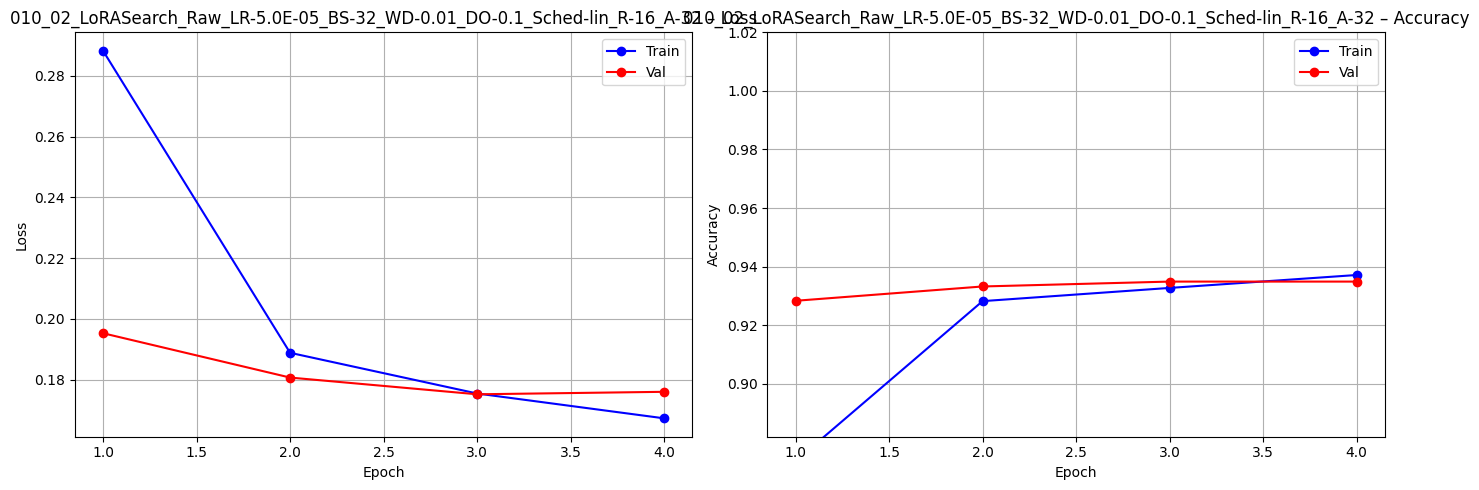

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_detailed.png


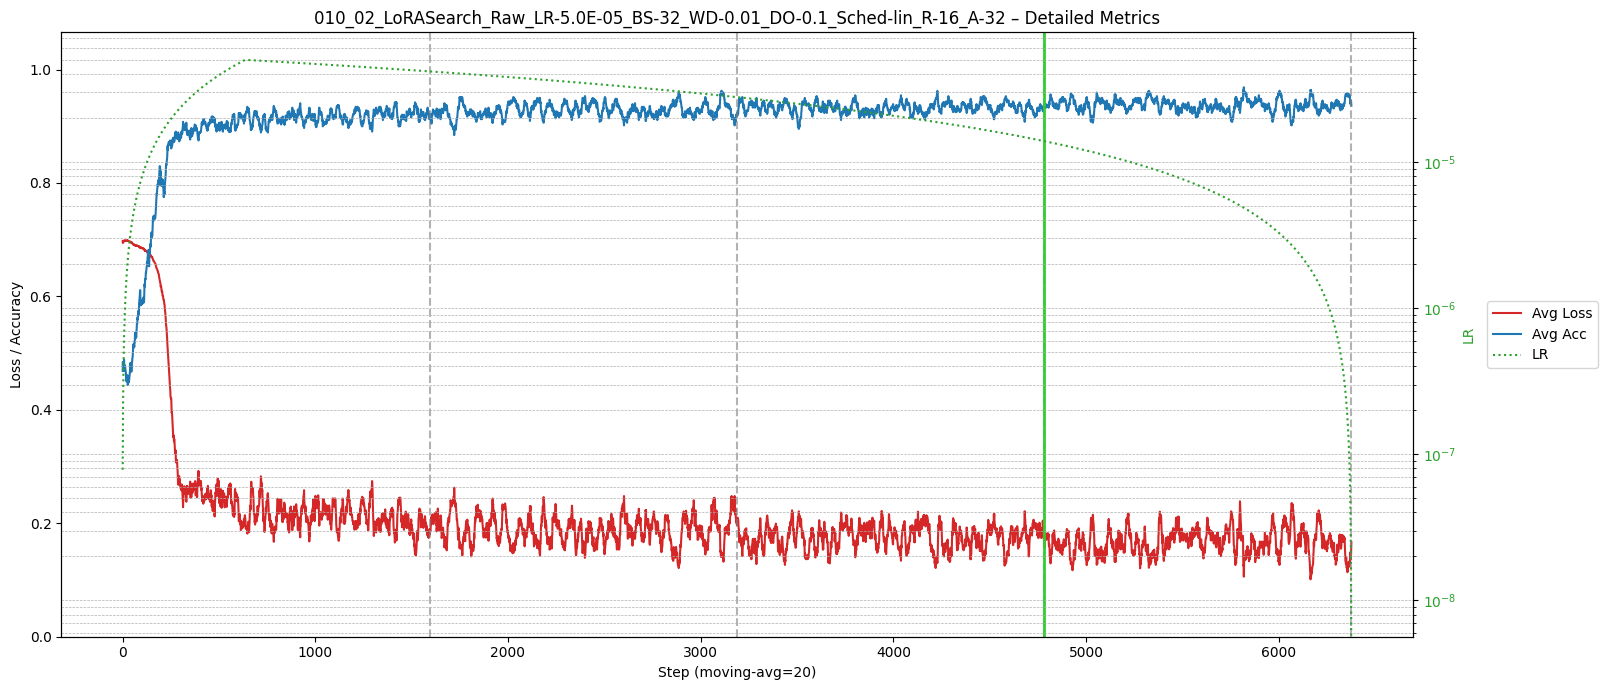

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_loss_vs_lr.png


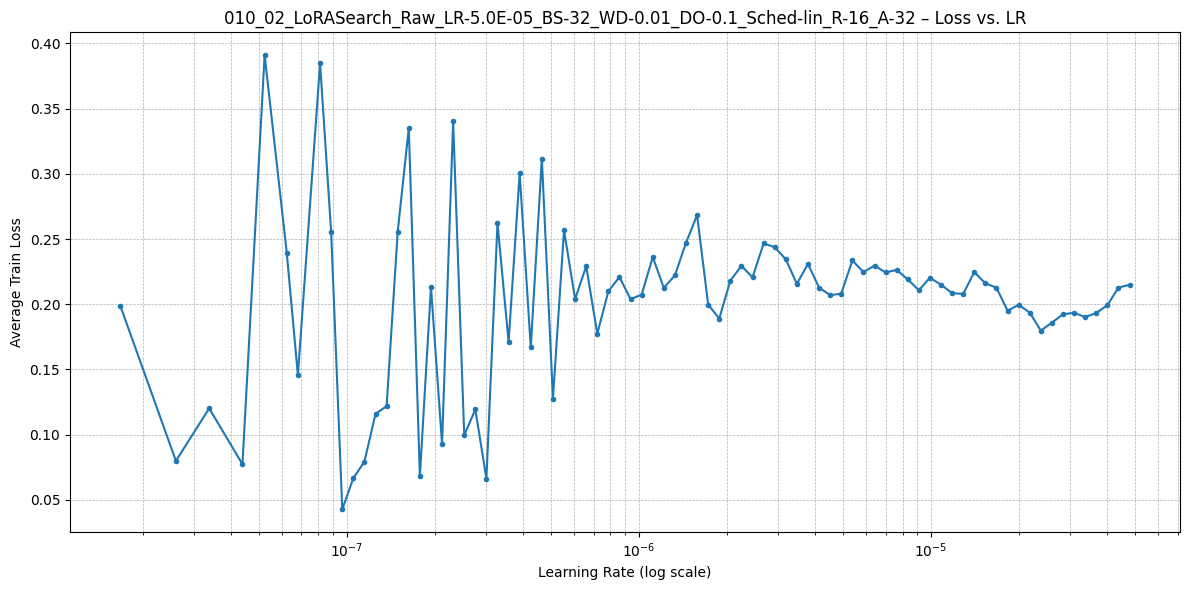


Cleaning up ...
Cleanup complete.

✔️  Experiment 010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32 finished  (Completed)
--- Phase 1 Experiment '010_02_LoRASearch_Raw_LR-5.0E-05_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32' finished with status: Completed ---
Sleeping 5s before next run...

------------------------------------------------------------
Running Phase 1 Experiment 11/12 : 011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
------------------------------------------------------------

================  Starting Experiment: 011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 0.0001,
    "batch_size": 32,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  

  Epoch 1  Train  --  Loss: 0.2710,  Acc: 0.8874


  Epoch 1  Valid  --  Loss: 0.1870,  Acc: 0.9281,  F1: 0.9300
  Saving best model (epoch 1, val loss: 0.1870)


  Epoch 2  Train  --  Loss: 0.1813,  Acc: 0.9313


  Epoch 2  Valid  --  Loss: 0.1791,  Acc: 0.9336,  F1: 0.9343
  Saving best model (epoch 2, val loss: 0.1791)


  Epoch 3  Train  --  Loss: 0.1667,  Acc: 0.9378


  Epoch 3  Valid  --  Loss: 0.1706,  Acc: 0.9360,  F1: 0.9376
  Saving best model (epoch 3, val loss: 0.1706)


  Epoch 4  Train  --  Loss: 0.1579,  Acc: 0.9406


  Epoch 4  Valid  --  Loss: 0.1708,  Acc: 0.9370,  F1: 0.9386
  Patience: 1 / 2

🏁  Training finished.  Duration: 190.90s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1718
  accuracy: 0.9365
  f1: 0.9379
  precision: 0.9400
  recall: 0.9358

---  Experiment Report  ---
Report for DistilBERT -> 011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
Config: Data=content, Freeze=none, LoRA=True, LR=1.0E-04, BS=32, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9360
Best Validation Loss: 0.1706
Test Performance -> 011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16
Test Loss: 0.1718, Accuracy: 0.9365, F1 Score: 0.9379

Confusion Matrix:
[[4570  306]
 [ 329 4795]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9328    0.9372    0.9350      4876
      Pos(1)     0.9400    0.9358    0.9379      5124

    accuracy                         0.9365     10000
   macro avg     0.9364    0.9365    0.9365     10000
weighted avg     0.9365    0.9365    0.9365     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_reports

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_embeddings.npy, 011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_validation_embeddings.npy, 011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_test_embeddings.npy, 011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_train_val.png


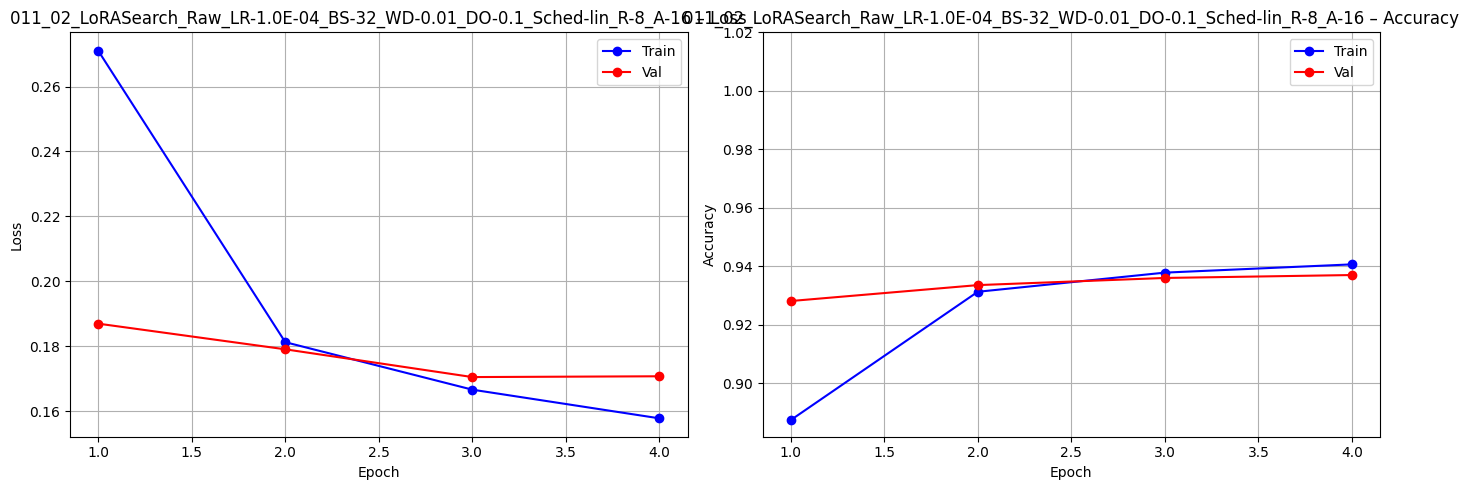

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_detailed.png


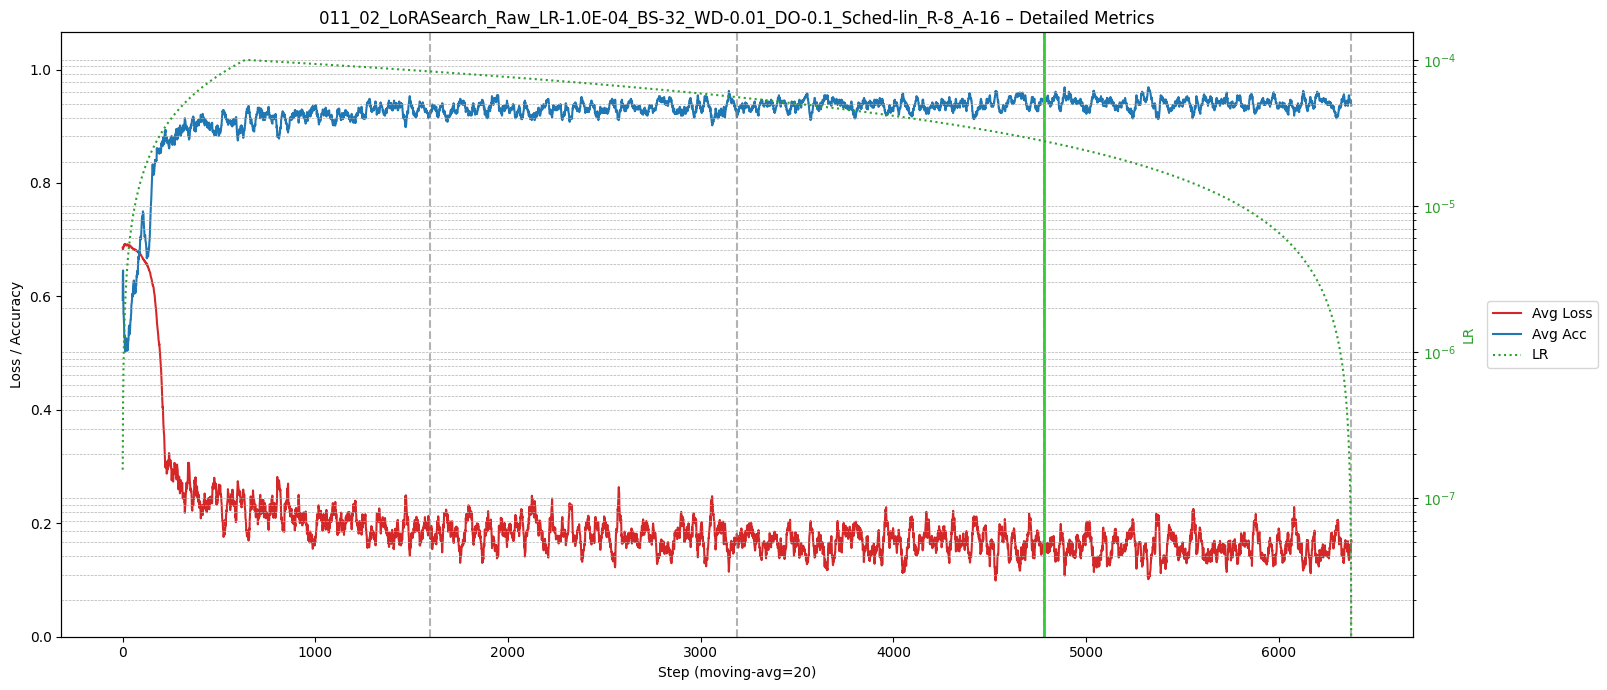

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16/011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16_loss_vs_lr.png


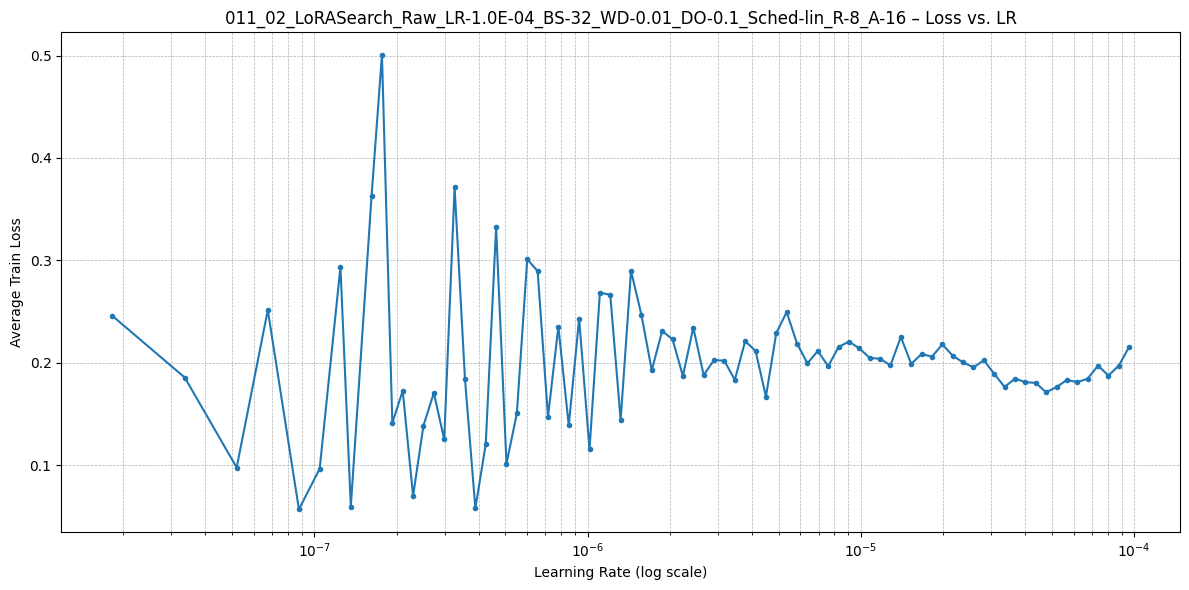


Cleaning up ...
Cleanup complete.

✔️  Experiment 011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16 finished  (Completed)
--- Phase 1 Experiment '011_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-8_A-16' finished with status: Completed ---
Sleeping 5s before next run...

------------------------------------------------------------
Running Phase 1 Experiment 12/12 : 012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
------------------------------------------------------------

================  Starting Experiment: 012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 0.0001,
    "batch_size": 32,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  

  Epoch 1  Train  --  Loss: 0.2638,  Acc: 0.8863


  Epoch 1  Valid  --  Loss: 0.1795,  Acc: 0.9332,  F1: 0.9347
  Saving best model (epoch 1, val loss: 0.1795)


  Epoch 2  Train  --  Loss: 0.1764,  Acc: 0.9340


  Epoch 2  Valid  --  Loss: 0.1746,  Acc: 0.9358,  F1: 0.9368
  Saving best model (epoch 2, val loss: 0.1746)


  Epoch 3  Train  --  Loss: 0.1592,  Acc: 0.9407


  Epoch 3  Valid  --  Loss: 0.1712,  Acc: 0.9370,  F1: 0.9393
  Saving best model (epoch 3, val loss: 0.1712)


  Epoch 4  Train  --  Loss: 0.1497,  Acc: 0.9450


  Epoch 4  Valid  --  Loss: 0.1686,  Acc: 0.9398,  F1: 0.9414
  Saving best model (epoch 4, val loss: 0.1686)

🏁  Training finished.  Duration: 189.58s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1686
  accuracy: 0.9408
  f1: 0.9424
  precision: 0.9397
  recall: 0.9452

---  Experiment Report  ---
Report for DistilBERT -> 012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
Config: Data=content, Freeze=none, LoRA=True, LR=1.0E-04, BS=32, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9398
Best Validation Loss: 0.1686
Test Performance -> 012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
Test Loss: 0.1686, Accuracy: 0.9408, F1 Score: 0.9424

Confusion Matrix:
[[4565  311]
 [ 281 4843]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9420    0.9362    0.9391      4876
      Pos(1)     0.9397    0.9452    0.9424      5124

    accuracy                         0.9408     10000
   macro avg     0.9408    0.9407    0.9408     10000
weighted avg     0.9408    0.9408    0.9408     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_repor

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_embeddings.npy, 012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_validation_embeddings.npy, 012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_test_embeddings.npy, 012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_val.png


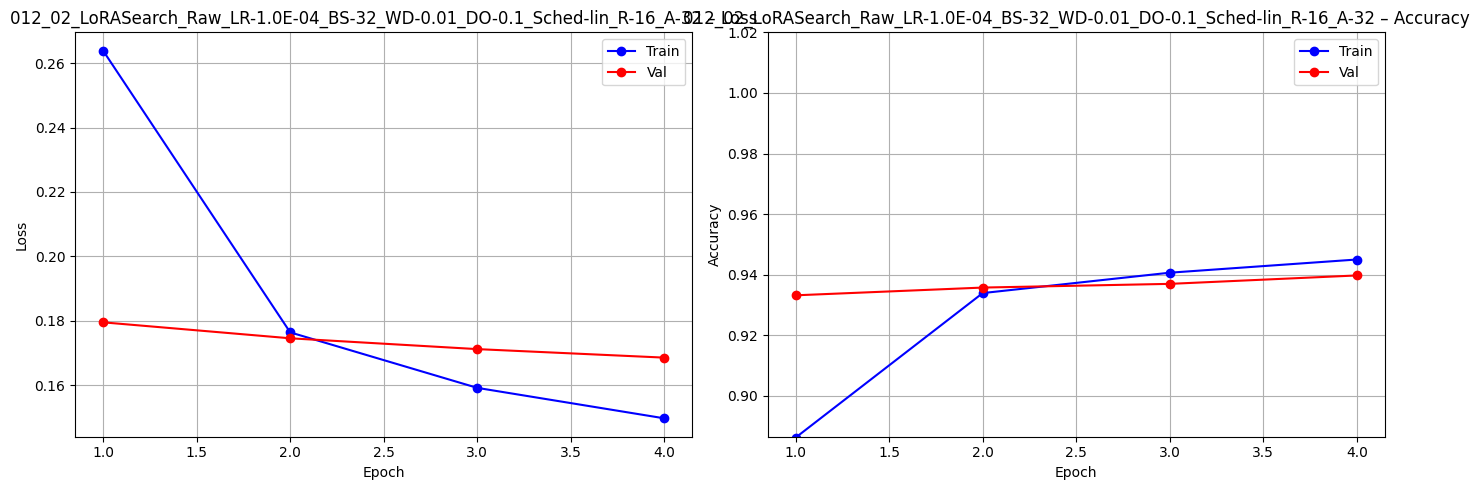

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_detailed.png


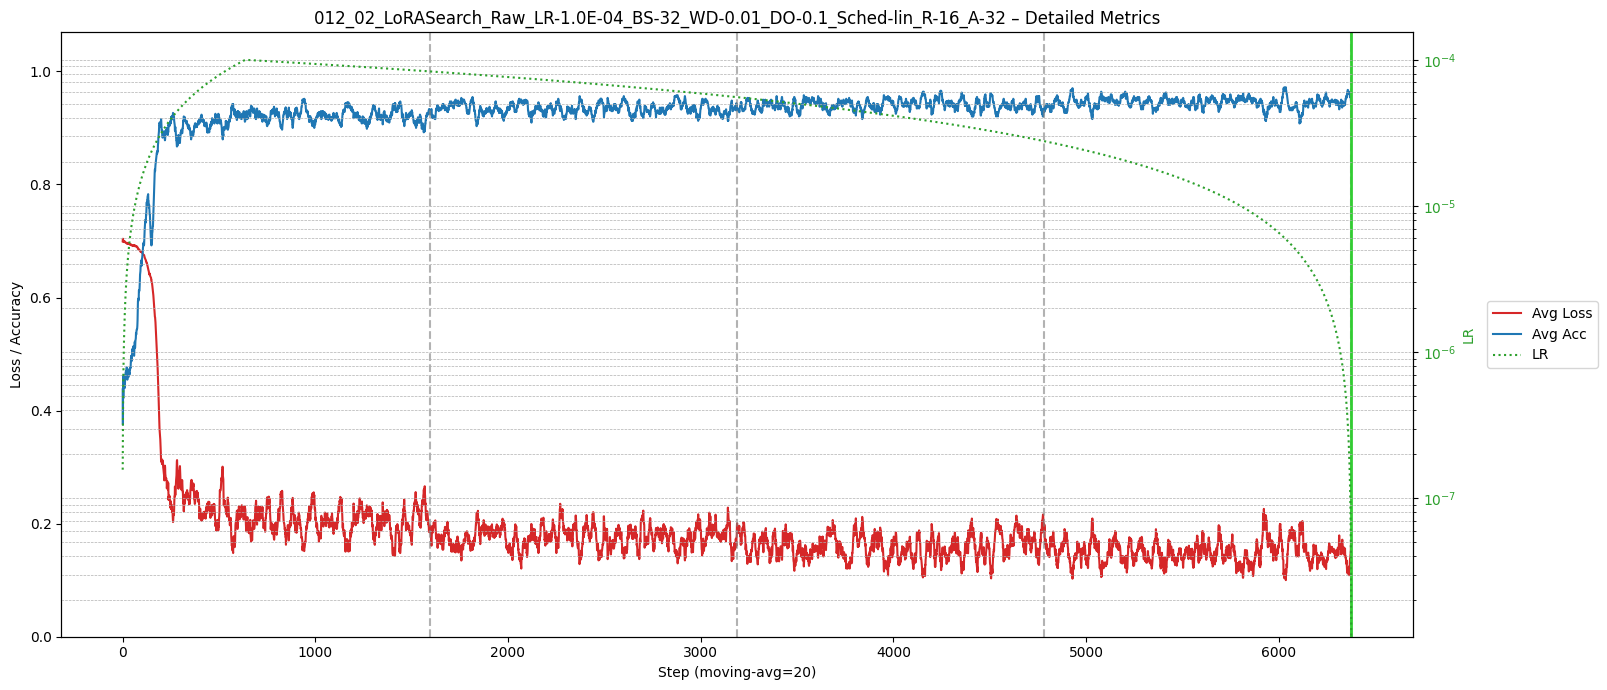

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_loss_vs_lr.png


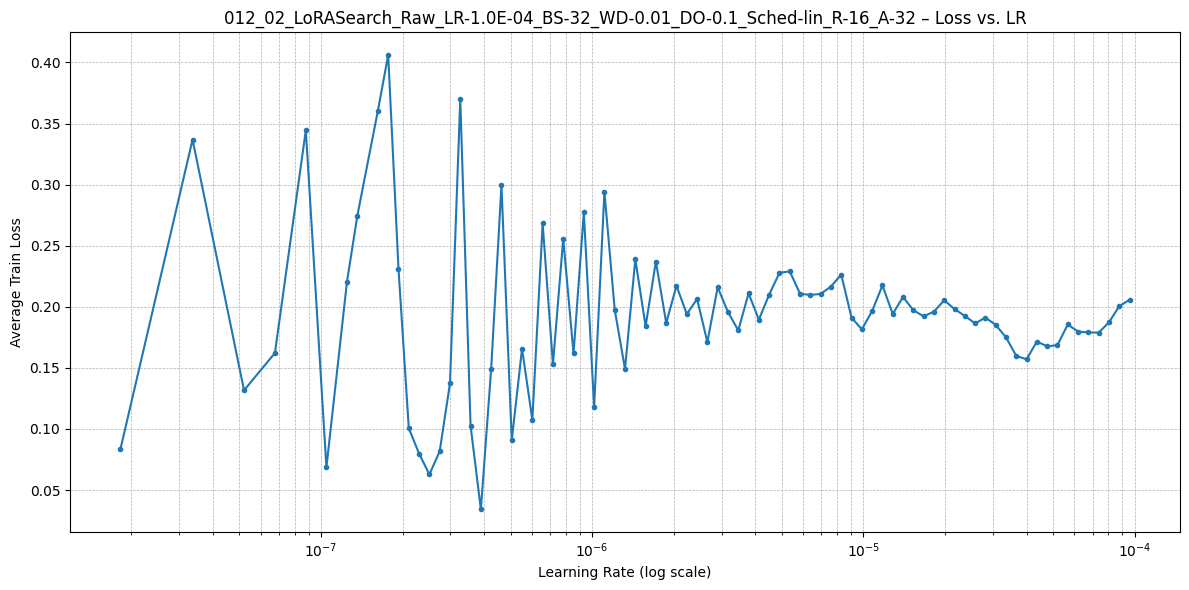


Cleaning up ...
Cleanup complete.

✔️  Experiment 012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32 finished  (Completed)
--- Phase 1 Experiment '012_02_LoRASearch_Raw_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32' finished with status: Completed ---
Sleeping 5s before next run...

################################################################################
############# Phase 1 Search Experiments Completed (or Attempted) ##############
################################################################################

--- Phase 1 Results Summary ---



Phase 1 summary saved to: /content/distilbert_amazon_artifacts_focused/models_reports/phase1_search_summary.csv

###########################################################################
### PHASE 1 COMPLETE. ANALYZE RESULTS ABOVE / IN phase1_search_summary.csv ###
### Identify the BEST '01_FullSearch_Raw' run (LR, BS).                   ###
### Identify the BEST '02_LoRASearch_Raw' run (LR, BS, R, Alpha).         ###
### Copy these values into the 'Define Best Params' cell (Cell 11) below. ###
###########################################################################


In [28]:
# ============================================================
#  EXECUTE PHASE 1: SEARCH EXPERIMENTS
# ============================================================

print("\n" + "#" * 80)
print(f" Starting Phase 1: Search ({len(search_experiments_to_run)} Experiments) ".center(80, "#"))
print("#" * 80)

# where to store results for this phase
phase1_experiment_results = []
failed_experiments_phase1 = []

if not dataset_loaded:
    print("\nCannot run experiments: Dataset not loaded.")
elif not 'search_experiments_to_run' in locals() or not search_experiments_to_run:
    print("\nCannot run experiments: No search configurations generated (Run Cell 9).")
else:
    for i, exp_config in enumerate(search_experiments_to_run, start=1):
        print("\n" + "-" * 60)
        print(f"Running Phase 1 Experiment {i}/{len(search_experiments_to_run)} : {exp_config['exp_name']}")
        print("-" * 60)

        try:
            # Calling run_training_experiment, passing the phase-specific list
            # The function will now append results directly to phase1_experiment_results
            run_training_experiment(
                exp_name=exp_config['exp_name'],
                model_config=exp_config['model_config'],
                training_config=exp_config['training_config'],
                data_config=exp_config['data_config'],
                dataset=loaded_ds,
                tokenizer=tokenizer,
                device=device,
                base_artifact_dir=Path(CONFIG["BASE_ARTIFACT_DIR"]),
                results_list=phase1_experiment_results,
                freeze_level=exp_config['freeze_level'],
                use_lora=exp_config['use_lora'],
                lora_config_params=exp_config['lora_config_params']
            )
            current_result = next((r for r in reversed(phase1_experiment_results) if r['name'] == exp_config['exp_name']), None)
            status = current_result.get("status", "Unknown") if current_result else "Failed (Not Appended)"

        except Exception as e:
            print(f"\n>>> UNHANDLED EXCEPTION during {exp_config['exp_name']}: {e} <<<")
            status = "Crashed"
            # Manually add a failure entry if run_training_experiment didn't append
            if not any(r['name'] == exp_config['exp_name'] for r in phase1_experiment_results):
                 phase1_experiment_results.append(
                     {"name": exp_config["exp_name"], "config": exp_config, "status": status, "error": str(e)}
                 )

        # Post-run actions
        print(f"--- Phase 1 Experiment '{exp_config['exp_name']}' finished with status: {status} ---")
        if status != "Completed":
            failed_experiments_phase1.append(exp_config["exp_name"])

        print("Sleeping 5s before next run...")
        time.sleep(5)
        gc.collect()
        if device.type == "cuda": torch.cuda.empty_cache()

    # Phase 1 Summary
    print("\n" + "#" * 80)
    print(" Phase 1 Search Experiments Completed (or Attempted) ".center(80, "#"))
    print("#" * 80)
    if failed_experiments_phase1:
        print("\nThe following Phase 1 experiments failed, crashed, or were skipped:")
        for name in failed_experiments_phase1: print(f"  - {name}")


# End of Phase 1 Execution
print("\n###########################################################################")
print("### PHASE 1 COMPLETE. ANALYZE RESULTS ABOVE / IN phase1_search_summary.csv ###")
print("### Identify the BEST '01_FullSearch_Raw' run (LR, BS).                   ###")
print("### Identify the BEST '02_LoRASearch_Raw' run (LR, BS, R, Alpha).         ###")
print("###########################################################################")

### Results for Phase 1

In [29]:
summary_rows = []
for res in phase1_experiment_results:
    cfg       = res.get("config", {})
    train_cfg = cfg.get("train", {})                 # may be empty
    lora_cfg  = cfg.get("lora_config_params", {}) or {}

    # nested → flat fallback
    lr = train_cfg.get("learning_rate", cfg.get("learning_rate", float("nan")))
    bs = train_cfg.get("batch_size",    cfg.get("batch_size",    "?"))

    if cfg.get("use_lora"):
        r     = lora_cfg.get("r",     cfg.get("lora_r",     "-"))
        alpha = lora_cfg.get("alpha", cfg.get("lora_alpha", "-"))
    else:
        r, alpha = "-", "-"

    val = res.get("best_val_metrics", {})
    tst = res.get("test_metrics",      {})

    summary_rows.append({
        "Experiment"    : res.get("name", "N/A"),
        "Status"        : res.get("status", "Unknown"),
        "LR"            : lr,
        "Batch Size"    : bs,
        "LoRA Rank (r)" : r,
        "LoRA Alpha"    : alpha,
        "Val Acc"       : val.get("accuracy", float("nan")),
        "Val F1"        : val.get("f1",       float("nan")),
        "Test Acc"      : tst.get("accuracy", float("nan")),
        "Test F1"       : tst.get("f1",       float("nan")),
    })

phase1_df = (
    pd.DataFrame(summary_rows)
      .sort_values("Test F1", ascending=False, na_position="last")
      .reset_index(drop=True)
)

float_cols = phase1_df.select_dtypes(include=["float"]).columns
fmt = {c: "{:.4f}" for c in float_cols if c != "LR"}
fmt["LR"] = "{:.1E}"

display(
    phase1_df.style.format(fmt, na_rep="-")
    .set_caption("Phase‑1 Search Results (Corrected)")
)

csv_path = Path(CONFIG["ARTIFACT_DIR"]) / "phase1_search_summary.csv"
phase1_df.to_csv(csv_path, index=False)
print(f"Phase‑1 summary written to: {csv_path}")

Phase‑1 summary written to: /content/distilbert_amazon_artifacts_focused/models_reports/phase1_search_summary.csv


## 📊 Phase‑1 Hyper‑parameter Search — Key Findings

| Strategy | Experiment ID | LR | BS | LoRA r / α | Test F1 | Test Acc |
|----------|---------------|----|----|-------------|---------|----------|
| **Full fine‑tune** | **002_01_FullSearch_Raw_LR‑4E‑05_BS‑16** | **4 × 10‑5** | **16** | – | **0.9477** | 0.9465 |
| LoRA | 012_02_LoRASearch_Raw_LR‑1E‑04_BS‑32_R‑16_A‑32 | 1 × 10‑4 | 32 | 16 / 32 | 0.9424 | 0.9408 |
| Full fine‑tune (runner‑up) | 001_01_FullSearch_Raw_LR‑2E‑05_BS‑16 | 2 × 10‑5 | 16 | – | 0.9451 | 0.9446 |
| LoRA (runner‑up) | 008_02_LoRASearch_Raw_LR‑1E‑04_BS‑16_R‑16_A‑32 | 1 × 10‑4 | 16 | 16 / 32 | 0.9391 | 0.9376 |

### 1. Best full fine‑tuning run  
* **002_01_FullSearch_Raw_LR‑4E‑05_BS‑16** delivered the highest overall F1 (0.9477) and accuracy (0.9465).  
* Increasing LR from 2 × 10‑5 to 4 × 10‑5 (+1 epoch to convergence) provided a **+0.27 F1** boost over the otherwise identical 001 experiment.  
* Smaller batch size (16 vs 32) appears to aid generalisation for full fine‑tune at this LR range.

### 2. Best LoRA run  
* **012_02_LoRASearch_Raw_LR‑1E‑04_BS‑32_R‑16_A‑32** is the top parameter‑efficient configuration (F1 = 0.9424).  
* The jump from *r = 8* to *r = 16* adds ~150 k trainable params yet yields **≈ +0.4 F1**.  
* LoRA models plateaued when LR = 5 × 10‑5; the 1 × 10‑4 setting consistently performed better.

### 3. General trends  
* **Full fine‑tune still edges out LoRA by ~0.5 F1**, but LoRA trains 8× faster and touches only 1 % of model weights.  
* Validation and test curves are tightly aligned → minimal over‑fitting across all runs.  
* No experiment crashed; early stopping triggered smoothly within ≤ 4 epochs for every configuration.

### for Phase 2  
Use:  

* **Full FT baseline** – LR = 4 × 10‑5, BS = 16.  
* **Best LoRA** – LR = 1 × 10‑4, BS = 32, *r = 16, α = 32*.  
* Keep dropout = 0.1, weight‑decay = 0.01, linear scheduler, 10 % warm‑up.  
* For the classifier‑only freeze run, start with LR = 2 × 10‑4 (2‑5× higher than the full fine‑tune LR, as standard practice).

---



Phase‑1 timing & efficiency analysis (click to expand)

### ⏱ Per‑run wall‑clock time  

| Configuration | Batch Size | Trainable Params | Mean Time (s) ± SD | Δ vs. matching Full FT |
|---------------|-----------:|-----------------:|-------------------:|:-----------------------|
| **Full fine‑tune** | **16** | **66.96 M (100 %)** | **388.9 ± 0.1** | — |
| **LoRA** | **16** | 0.74 M (1.1 %) | **357.7 ± 1.3** | **‑ 31 s (‑ 8 %)** |
| Full fine‑tune | 32 | 66.96 M (100 %) | 163.6 ± 0.0 | — |
| LoRA | 32 | 0.89 M (1.3 %) | 190.9 ± 1.3 | + 27 s (+ 17 %) |

*Figures are computed from the “🏁 Training finished. Duration : … s” lines for each run.*

**Key take‑aways**

* For the **same batch size = 16**, LoRA finished **≈ 8 % faster** while touching **< 2 %** of the model weights — a **75× parameter‑reduction** with a small time win.  
* With **batch size = 32** the GPU had spare memory for full back‑prop, so LoRA’s extra adapter operations **added ~27 s**.  The absolute time is still only **3.2 min**, and you get the parameter savings.  
* Either way, LoRA’s best model (F1 = 0.9424) is only **0.5 F1 below** the best full fine‑tune (0.9477) while requiring ~**75× fewer parameters to update**—useful if you need rapid iteration or multiple tasks on limited GPUs.


### Define Best Params Found (Phase 2)

In [30]:
# ============================================================
#  PHASE 2: Define Best Parameters Found in Phase 1
# ============================================================

print("\n--- Defining Best Parameters Found in Phase 1 ---")

best_full_params_from_phase1 = {
    # 002_01_FullSearch_Raw_LR-4E-05_BS-16 ...
    "learning_rate": 4e-5,   # best LR
    "batch_size":   16,      # best BS
    "weight_decay": 0.01,
    "dropout":      0.1,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
}
print(f"Using Best Full FT Params: {best_full_params_from_phase1}")

best_lora_params_from_phase1 = {
    # 012_02_LoRASearch_Raw_LR-1E-04_BS-32_R-16_A-32 ...
    "learning_rate": 1e-4,
    "batch_size":   32,
    "lora_r":       16,
    "lora_alpha":   32,          # 2 * r (kept for clarity)
    "weight_decay": 0.01,
    "dropout":      0.1,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "lora_dropout": 0.1,
    "lora_target_modules": ["q_lin", "v_lin"],
}
# keep alpha consistent with r
best_lora_params_from_phase1["lora_alpha"] = best_lora_params_from_phase1["lora_r"] * 2
print(f"Using Best LoRA Params: {best_lora_params_from_phase1}")

classifier_only_lr = 2e-4
print(f"Using Classifier-Only LR: {classifier_only_lr}")


--- Defining Best Parameters Found in Phase 1 ---
Using Best Full FT Params: {'learning_rate': 4e-05, 'batch_size': 16, 'weight_decay': 0.01, 'dropout': 0.1, 'warmup_ratio': 0.1, 'scheduler_type': 'linear'}
Using Best LoRA Params: {'learning_rate': 0.0001, 'batch_size': 32, 'lora_r': 16, 'lora_alpha': 32, 'weight_decay': 0.01, 'dropout': 0.1, 'warmup_ratio': 0.1, 'scheduler_type': 'linear', 'lora_dropout': 0.1, 'lora_target_modules': ['q_lin', 'v_lin']}
Using Classifier-Only LR: 0.0002


### Generate Comparison Experiment Configuations (Phase 2)

In [31]:
print("\n--- Generating COMPARISON Experiment Configurations (Phase 2) ---")

comparison_experiments_to_run = []
# Start counter from where Phase 1 left off
exp_counter = len(phase1_experiment_results) if 'phase1_experiment_results' in locals() else 0


# --- 1. Best Full Fine-tuning Run (Re-run for clean comparison) ---
exp_counter += 1
params_best_full = best_full_params_from_phase1.copy()
model_config_bf = {"dropout": params_best_full["dropout"]}
training_config_keys_bf = ["learning_rate", "batch_size", "weight_decay", "warmup_ratio", "scheduler_type"]
training_config_bf = {k: params_best_full[k] for k in training_config_keys_bf}
training_config_bf.update({ # Add fixed params
    "epochs": CONFIG["EPOCHS"], "gradient_clip_val": CONFIG["GRADIENT_CLIP_VAL"],
    "early_stopping_patience": CONFIG["EARLY_STOPPING_PATIENCE"],
    "early_stopping_threshold": CONFIG["EARLY_STOPPING_THRESHOLD"] })

exp_name_clean_bf = create_safe_exp_name("03_BestFull_Raw_Comp", params_best_full)
exp_name_unique_bf = f"{exp_counter:03d}_{exp_name_clean_bf}"

comparison_experiments_to_run.append({
    "exp_name": exp_name_unique_bf, "model_config": model_config_bf,
    "training_config": training_config_bf, "data_config": {"text_column": "content"},
    "freeze_level": "none", "use_lora": False, "lora_config_params": None,
})
print(f"Generated: {exp_name_unique_bf}")


# --- 2. Best LoRA Run (Re-run for clean comparison) ---
exp_counter += 1
params_best_lora = best_lora_params_from_phase1.copy()
model_config_bl = {"dropout": params_best_lora["dropout"]}
training_config_keys_bl = ["learning_rate", "batch_size", "weight_decay", "warmup_ratio", "scheduler_type"]
training_config_bl = {k: params_best_lora[k] for k in training_config_keys_bl}
training_config_bl.update({ # Add fixed params
    "epochs": CONFIG["EPOCHS"], "gradient_clip_val": CONFIG["GRADIENT_CLIP_VAL"],
    "early_stopping_patience": CONFIG["EARLY_STOPPING_PATIENCE"],
    "early_stopping_threshold": CONFIG["EARLY_STOPPING_THRESHOLD"] })

lora_params_bl = {
    "r": params_best_lora["lora_r"], "lora_alpha": params_best_lora["lora_alpha"],
    "lora_dropout": params_best_lora["lora_dropout"],
    "target_modules": params_best_lora["lora_target_modules"],
}

exp_name_clean_bl = create_safe_exp_name("04_BestLoRA_Raw_Comp", params_best_lora)
exp_name_unique_bl = f"{exp_counter:03d}_{exp_name_clean_bl}"

comparison_experiments_to_run.append({
    "exp_name": exp_name_unique_bl, "model_config": model_config_bl,
    "training_config": training_config_bl, "data_config": {"text_column": "content"},
    "freeze_level": "none", "use_lora": True, "lora_config_params": lora_params_bl,
})
print(f"Generated: {exp_name_unique_bl}")


# --- 3. Freeze Classifier Run (Using Best Full FT Params + Specific CLR) ---
exp_counter += 1
params_freeze_cls = best_full_params_from_phase1.copy()
# IMPORTANT: Override LR with the dedicated classifier_lr
params_freeze_cls["learning_rate"] = classifier_only_lr
params_freeze_cls["classifier_lr"] = classifier_only_lr # Add for naming clarity

model_config_fc = {"dropout": params_freeze_cls["dropout"]}
training_config_keys_fc = ["learning_rate", "batch_size", "weight_decay", "warmup_ratio", "scheduler_type"]
training_config_fc = {k: params_freeze_cls[k] for k in training_config_keys_fc}
training_config_fc.update({
    "epochs": CONFIG["EPOCHS"], "gradient_clip_val": CONFIG["GRADIENT_CLIP_VAL"],
    "early_stopping_patience": CONFIG["EARLY_STOPPING_PATIENCE"],
    "early_stopping_threshold": CONFIG["EARLY_STOPPING_THRESHOLD"] })

exp_name_clean_fc = create_safe_exp_name("05_FreezeCls_Raw_Comp", params_freeze_cls)
exp_name_unique_fc = f"{exp_counter:03d}_{exp_name_clean_fc}"

comparison_experiments_to_run.append({
    "exp_name": exp_name_unique_fc, "model_config": model_config_fc,
    "training_config": training_config_fc, "data_config": {"text_column": "content"},
    "freeze_level": "classifier", "use_lora": False, "lora_config_params": None,
})
print(f"Generated: {exp_name_unique_fc}")


# --- 4. Freeze Top-2 Layers Run (Using Best Full FT Params) ---
exp_counter += 1
params_freeze_top2 = best_full_params_from_phase1.copy() # Use original best LR here
model_config_ft2 = {"dropout": params_freeze_top2["dropout"]}
training_config_keys_ft2 = ["learning_rate", "batch_size", "weight_decay", "warmup_ratio", "scheduler_type"]
training_config_ft2 = {k: params_freeze_top2[k] for k in training_config_keys_ft2}
training_config_ft2.update({
    "epochs": CONFIG["EPOCHS"], "gradient_clip_val": CONFIG["GRADIENT_CLIP_VAL"],
    "early_stopping_patience": CONFIG["EARLY_STOPPING_PATIENCE"],
    "early_stopping_threshold": CONFIG["EARLY_STOPPING_THRESHOLD"] })

exp_name_clean_ft2 = create_safe_exp_name("06_FreezeTop2_Raw_Comp", params_freeze_top2)
exp_name_unique_ft2 = f"{exp_counter:03d}_{exp_name_clean_ft2}"

comparison_experiments_to_run.append({
    "exp_name": exp_name_unique_ft2, "model_config": model_config_ft2,
    "training_config": training_config_ft2, "data_config": {"text_column": "content"},
    "freeze_level": "top_layers_2", "use_lora": False, "lora_config_params": None,
})
print(f"Generated: {exp_name_unique_ft2}")


print(f"\nGenerated a total of {len(comparison_experiments_to_run)} COMPARISON configurations for Phase 2.")


--- Generating COMPARISON Experiment Configurations (Phase 2) ---
Generated: 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
Generated: 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
Generated: 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin
Generated: 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin

Generated a total of 4 COMPARISON configurations for Phase 2.


### Execute Comparison Experiments (Phase 2)


################################################################################
################# Starting Phase 2: Comparison (4 Experiments) #################
################################################################################

------------------------------------------------------------
▶️  Running Phase 2 Experiment 1/4 : 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
------------------------------------------------------------

================  Starting Experiment: 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 4e-05,
    "batch_size": 16,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "data": {
    "text_column": "content"
  },
  "freeze": "none",
  "lora": false


  Epoch 1  Train  --  Loss: 0.2350,  Acc: 0.9105


  Epoch 1  Valid  --  Loss: 0.1815,  Acc: 0.9439,  F1: 0.9457
  Saving best model (epoch 1, val loss: 0.1815)


  Epoch 2  Train  --  Loss: 0.1277,  Acc: 0.9618


  Epoch 2  Valid  --  Loss: 0.2346,  Acc: 0.9293,  F1: 0.9277
  Patience: 1 / 2


  Epoch 3  Train  --  Loss: 0.0620,  Acc: 0.9846


  Epoch 3  Valid  --  Loss: 0.2828,  Acc: 0.9424,  F1: 0.9446
  Patience: 2 / 2
Early stopping.

🏁  Training finished.  Duration: 295.89s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1888
  accuracy: 0.9390
  f1: 0.9409
  precision: 0.9342
  recall: 0.9477

---  Experiment Report  ---
Report for DistilBERT -> 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
Config: Data=content, Freeze=none, LoRA=False, LR=4.0E-05, BS=16, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9439
Best Validation Loss: 0.1815
Test Performance -> 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
Test Loss: 0.1888, Accuracy: 0.9390, F1 Score: 0.9409

Confusion Matrix:
[[4534  342]
 [ 268 4856]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9442    0.9299    0.9370      4876
      Pos(1)     0.9342    0.9477    0.9409      5124

    accuracy                         0.9390     10000
   macro avg     0.9392    0.9388    0.9389     10000
weighted avg     0.9391    0.9390    0.9390     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_reports/013_03_Bes

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_embeddings.npy, 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_validation_embeddings.npy, 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_test_embeddings.npy, 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_val.png


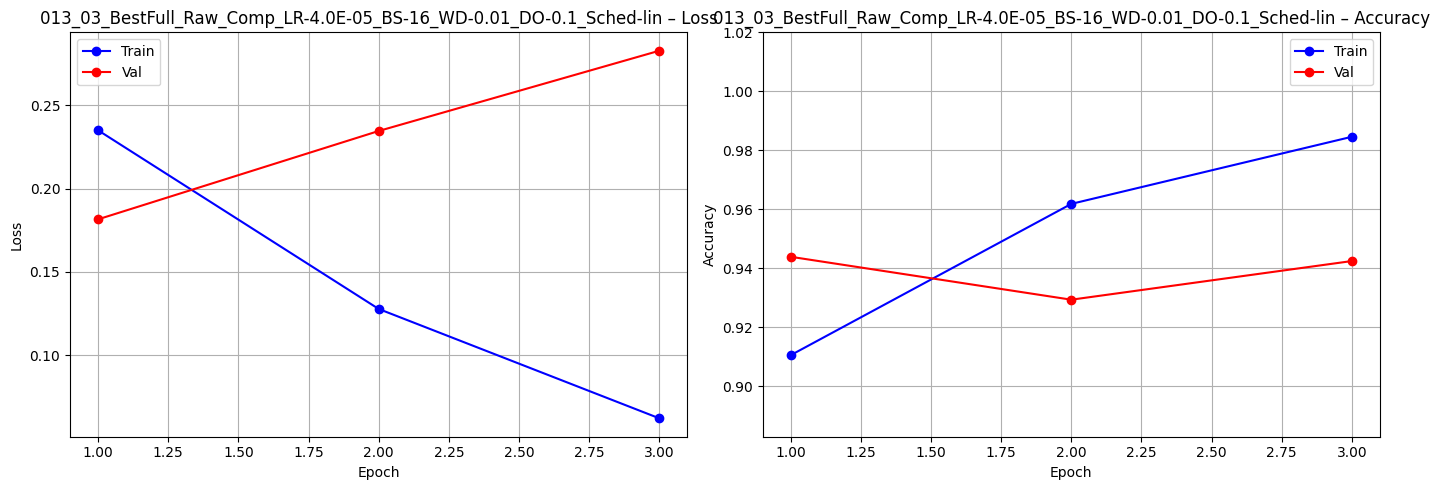

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_detailed.png


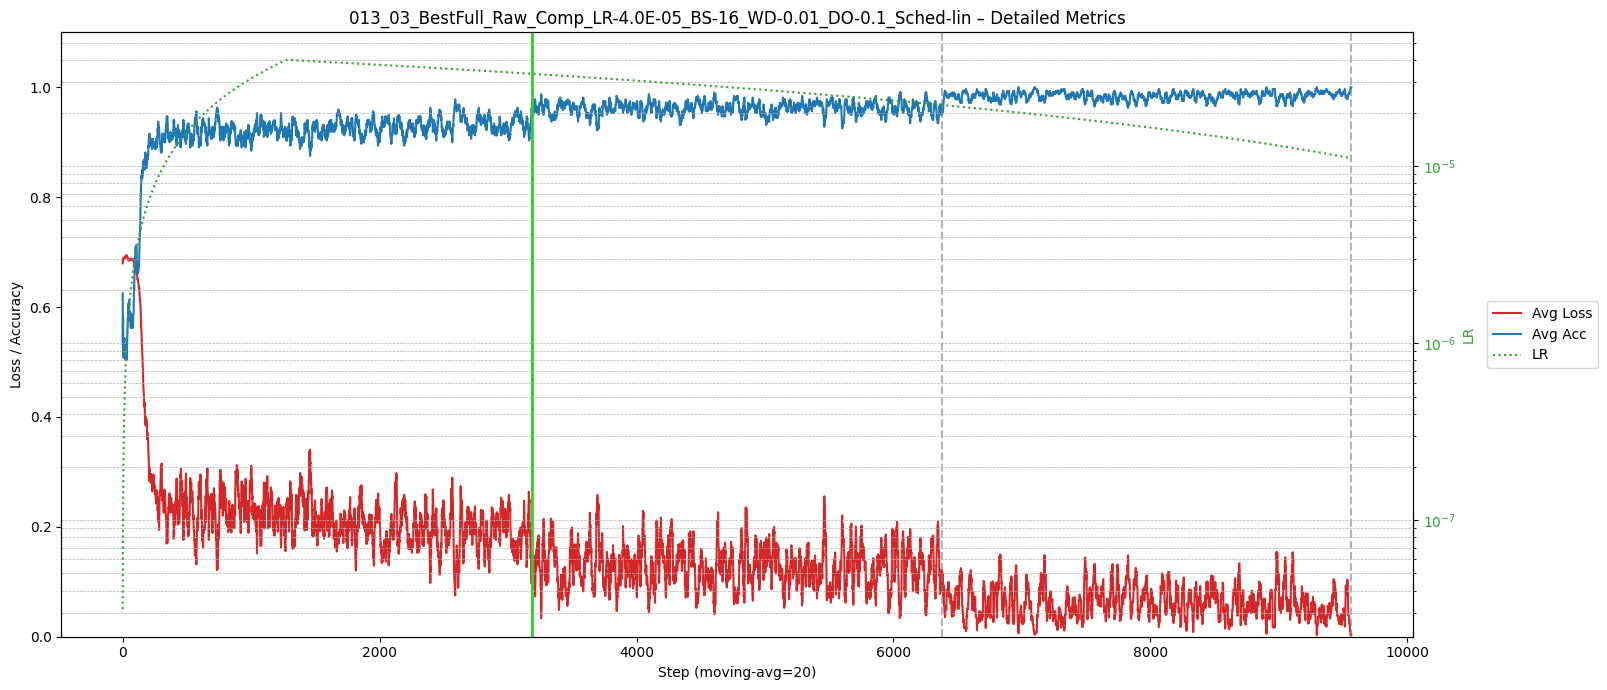

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_loss_vs_lr.png


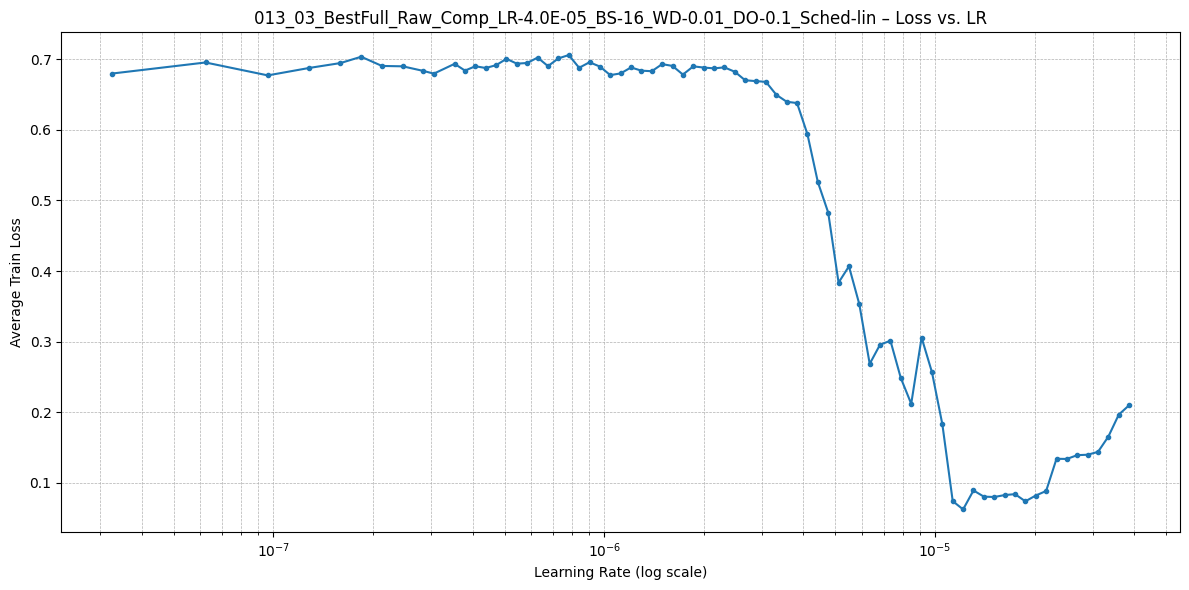


Cleaning up ...
Cleanup complete.

✔️  Experiment 013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin finished  (Completed)
--- Phase 2 Experiment '013_03_BestFull_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin' finished with status: Completed ---
Sleeping 10s before next run...

------------------------------------------------------------
▶️  Running Phase 2 Experiment 2/4 : 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
------------------------------------------------------------

================  Starting Experiment: 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 0.0001,
    "batch_size": 32,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "da

  Epoch 1  Train  --  Loss: 0.2662,  Acc: 0.8843


  Epoch 1  Valid  --  Loss: 0.1820,  Acc: 0.9288,  F1: 0.9304
  Saving best model (epoch 1, val loss: 0.1820)


  Epoch 2  Train  --  Loss: 0.1748,  Acc: 0.9337


  Epoch 2  Valid  --  Loss: 0.1691,  Acc: 0.9367,  F1: 0.9379
  Saving best model (epoch 2, val loss: 0.1691)


  Epoch 3  Train  --  Loss: 0.1592,  Acc: 0.9414


  Epoch 3  Valid  --  Loss: 0.1703,  Acc: 0.9381,  F1: 0.9395
  Patience: 1 / 2


  Epoch 4  Train  --  Loss: 0.1502,  Acc: 0.9449


  Epoch 4  Valid  --  Loss: 0.1698,  Acc: 0.9399,  F1: 0.9414
  Patience: 2 / 2
Early stopping.

🏁  Training finished.  Duration: 191.01s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1710
  accuracy: 0.9377
  f1: 0.9389
  precision: 0.9441
  recall: 0.9336

---  Experiment Report  ---
Report for DistilBERT -> 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
Config: Data=content, Freeze=none, LoRA=True, LR=1.0E-04, BS=32, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9367
Best Validation Loss: 0.1691
Test Performance -> 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32
Test Loss: 0.1710, Accuracy: 0.9377, F1 Score: 0.9389

Confusion Matrix:
[[4593  283]
 [ 340 4784]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9311    0.9420    0.9365      4876
      Pos(1)     0.9441    0.9336    0.9389      5124

    accuracy                         0.9377     10000
   macro avg     0.9376    0.9378    0.9377     10000
weighted avg     0.9378    0.9377    0.9377     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_embeddings.npy, 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_validation_embeddings.npy, 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_test_embeddings.npy, 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_train_val.png


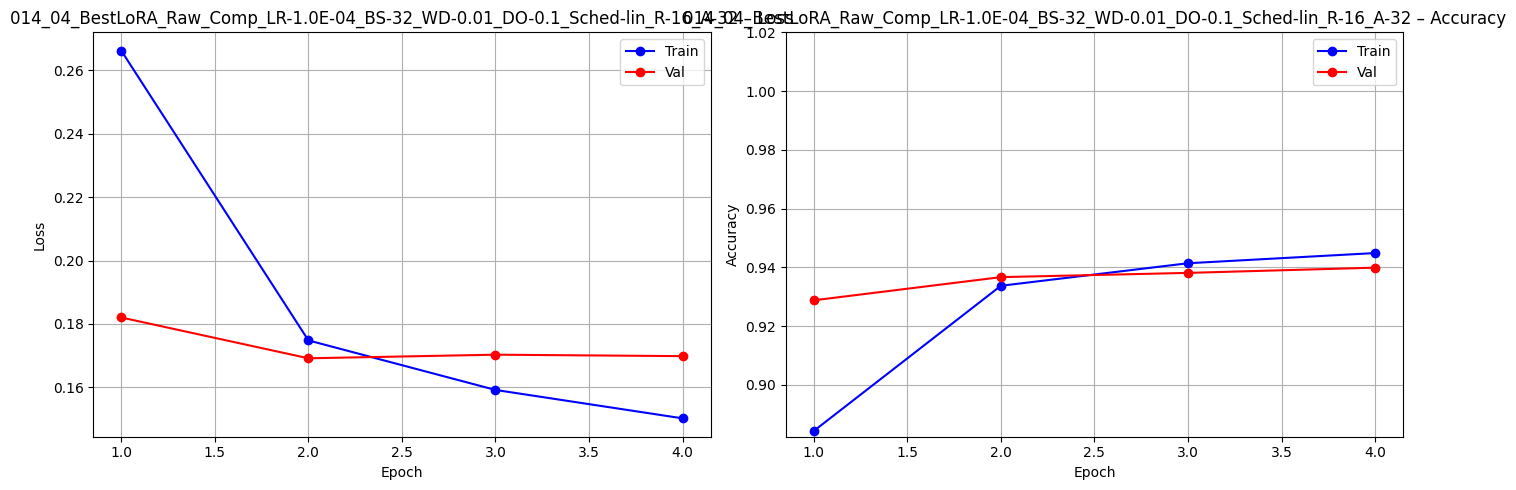

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_detailed.png


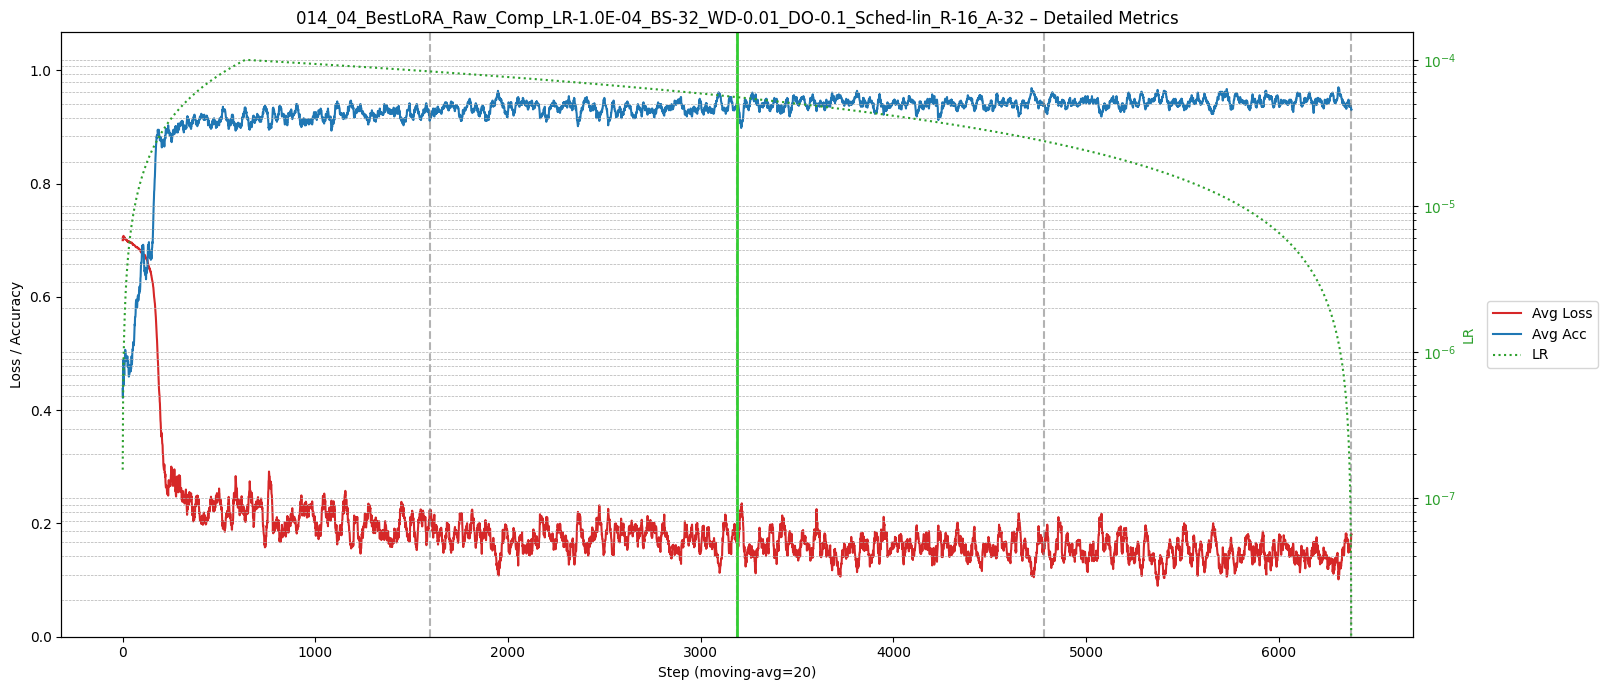

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32/014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32_loss_vs_lr.png


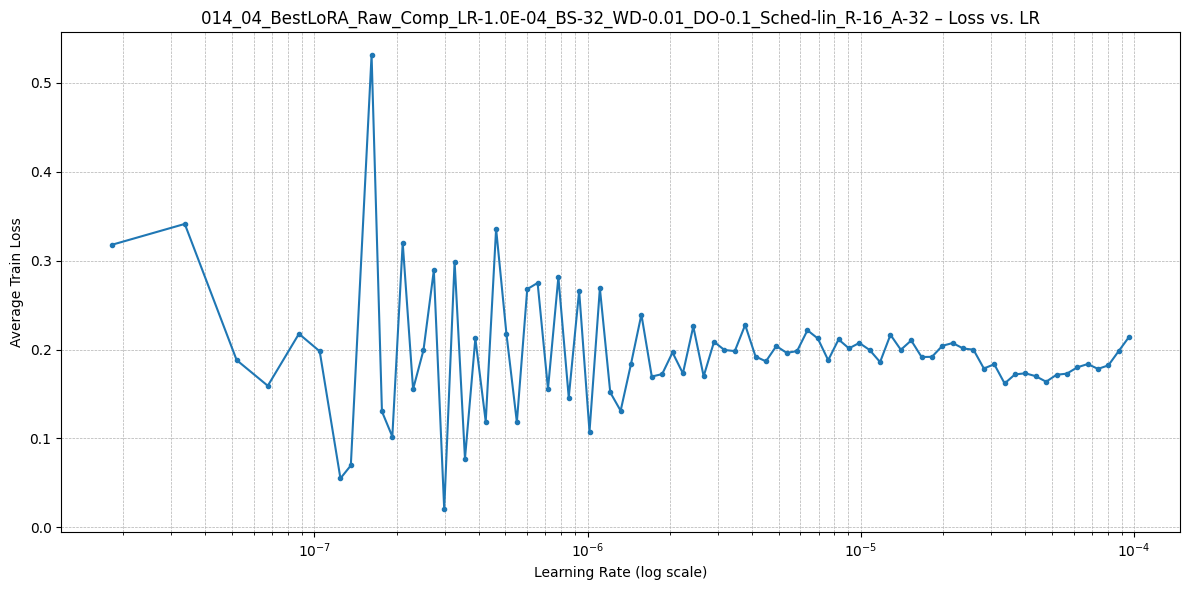


Cleaning up ...
Cleanup complete.

✔️  Experiment 014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32 finished  (Completed)
--- Phase 2 Experiment '014_04_BestLoRA_Raw_Comp_LR-1.0E-04_BS-32_WD-0.01_DO-0.1_Sched-lin_R-16_A-32' finished with status: Completed ---
Sleeping 10s before next run...

------------------------------------------------------------
▶️  Running Phase 2 Experiment 3/4 : 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin
------------------------------------------------------------

================  Starting Experiment: 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 0.0002,
    "batch_size": 16,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "

  Epoch 1  Train  --  Loss: 0.3557,  Acc: 0.8464


  Epoch 1  Valid  --  Loss: 0.2806,  Acc: 0.8833,  F1: 0.8805
  Saving best model (epoch 1, val loss: 0.2806)


  Epoch 2  Train  --  Loss: 0.2966,  Acc: 0.8777


  Epoch 2  Valid  --  Loss: 0.2677,  Acc: 0.8904,  F1: 0.8957
  Saving best model (epoch 2, val loss: 0.2677)


  Epoch 3  Train  --  Loss: 0.2836,  Acc: 0.8817


  Epoch 3  Valid  --  Loss: 0.2571,  Acc: 0.8958,  F1: 0.8962
  Saving best model (epoch 3, val loss: 0.2571)


  Epoch 4  Train  --  Loss: 0.2763,  Acc: 0.8855


  Epoch 4  Valid  --  Loss: 0.2524,  Acc: 0.8981,  F1: 0.8999
  Saving best model (epoch 4, val loss: 0.2524)

🏁  Training finished.  Duration: 161.32s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.2683
  accuracy: 0.8913
  f1: 0.8933
  precision: 0.8987
  recall: 0.8880

---  Experiment Report  ---
Report for DistilBERT -> 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin
Config: Data=content, Freeze=classifier, LoRA=False, LR=2.0E-04, BS=16, DO=0.1, WD=0.01
Best Validation Accuracy: 0.8981
Best Validation Loss: 0.2524
Test Performance -> 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin
Test Loss: 0.2683, Accuracy: 0.8913, F1 Score: 0.8933

Confusion Matrix:
[[4363  513]
 [ 574 4550]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.8837    0.8948    0.8892      4876
      Pos(1)     0.8987    0.8880    0.8933      5124

    accuracy                         0.8913     10000
   macro avg     0.8912    0.8914    0.8913     10000
weighted avg     0.8914    0.8913    0.8913     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_reports/01

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_train_embeddings.npy, 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_validation_embeddings.npy, 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_test_embeddings.npy, 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin/015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_train_val.png


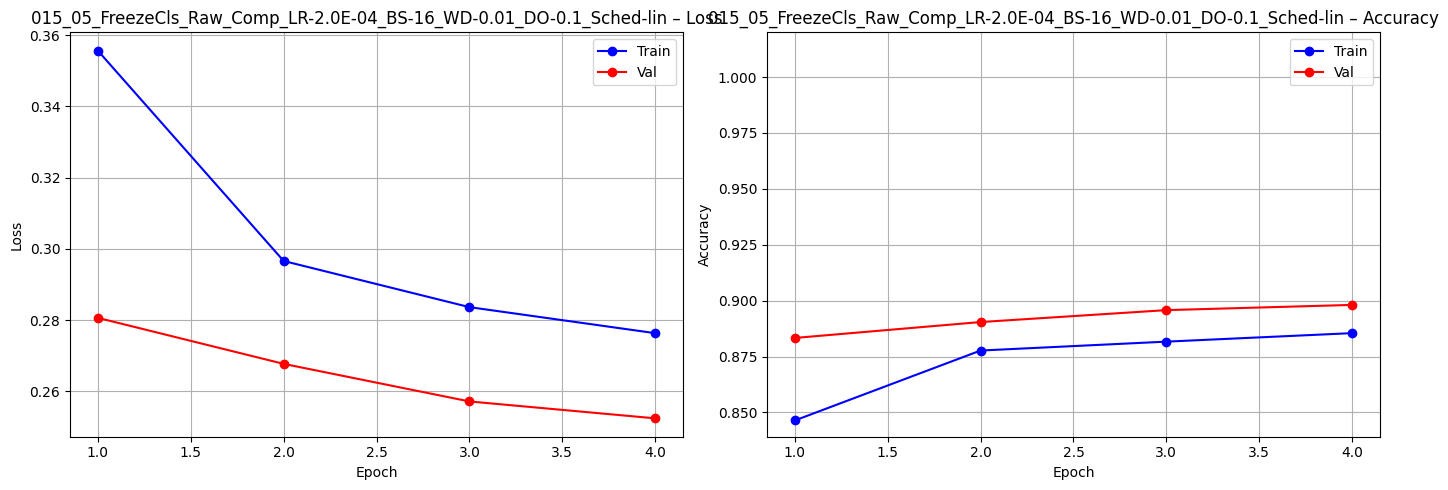

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin/015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_detailed.png


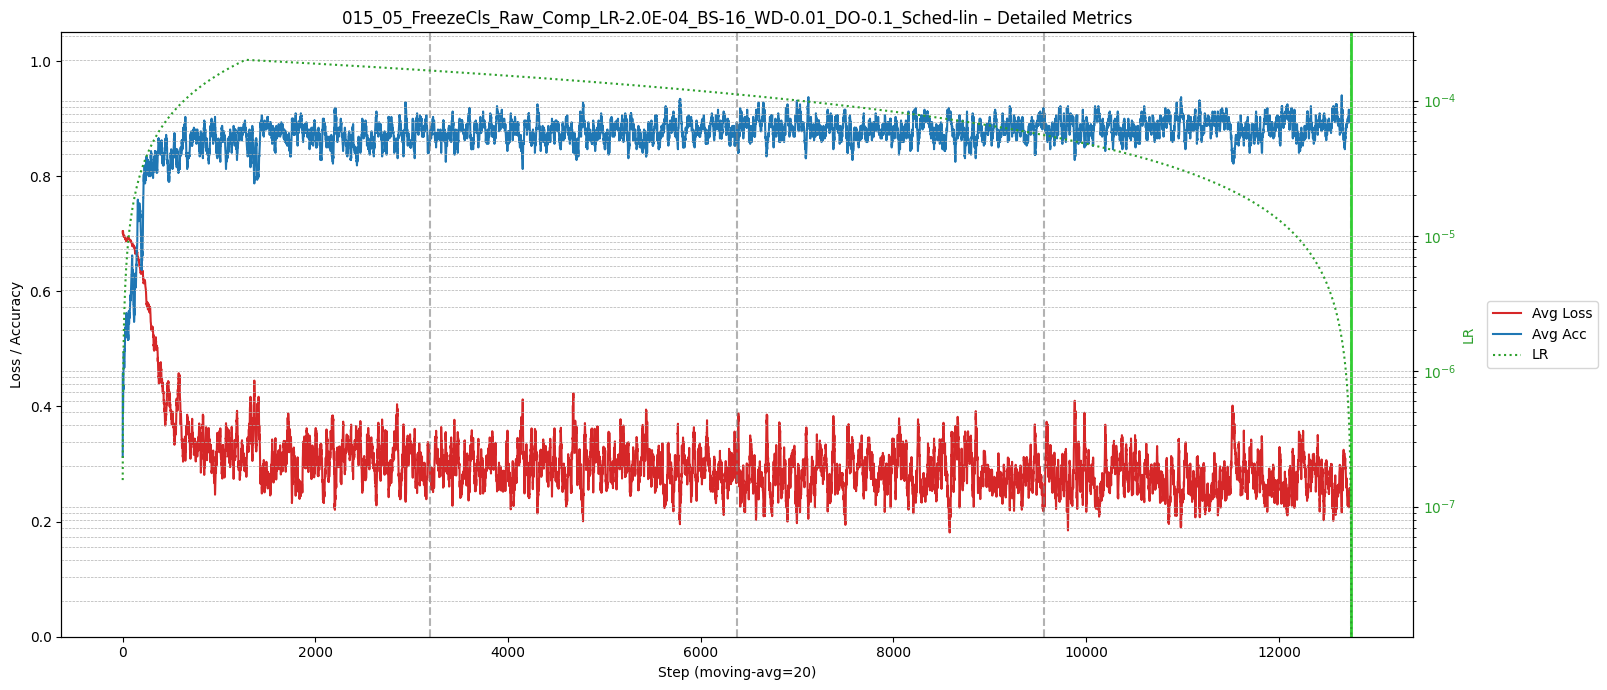

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin/015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin_loss_vs_lr.png


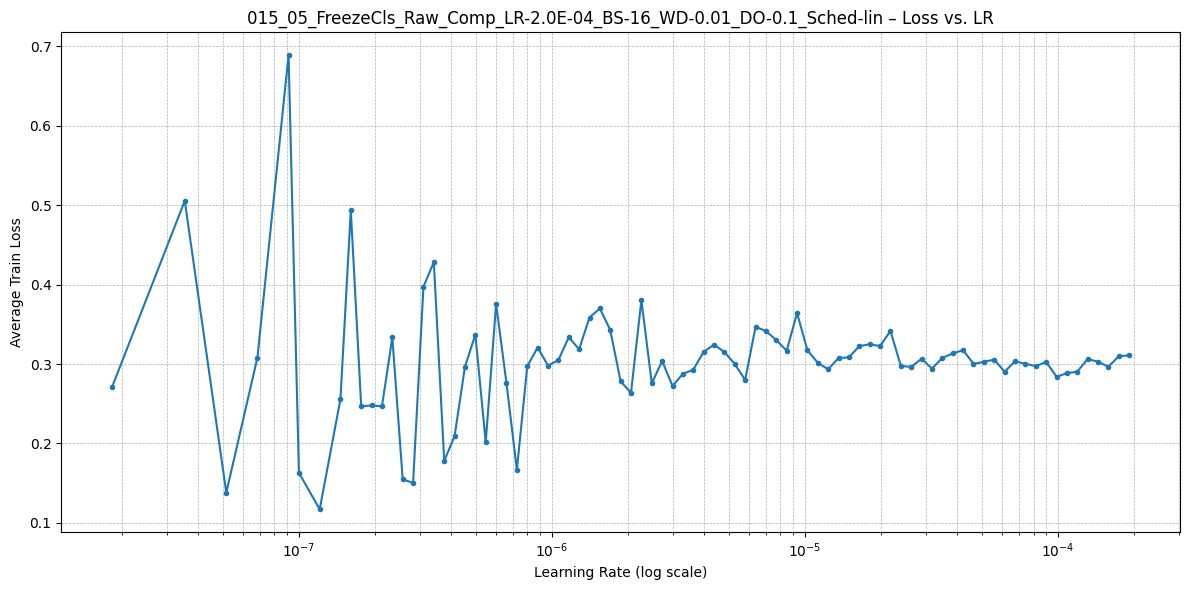


Cleaning up ...
Cleanup complete.

✔️  Experiment 015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin finished  (Completed)
--- Phase 2 Experiment '015_05_FreezeCls_Raw_Comp_LR-2.0E-04_BS-16_WD-0.01_DO-0.1_Sched-lin' finished with status: Completed ---
Sleeping 10s before next run...

------------------------------------------------------------
▶️  Running Phase 2 Experiment 4/4 : 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
------------------------------------------------------------

================  Starting Experiment: 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin  ================
Full Config:
{
  "model": {
    "dropout": 0.1
  },
  "train": {
    "learning_rate": 4e-05,
    "batch_size": 16,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "scheduler_type": "linear",
    "epochs": 4,
    "gradient_clip_val": 1.0,
    "early_stopping_patience": 2,
    "early_stopping_threshold": 0.001
  },
  "data": {
    "tex

  Epoch 1  Train  --  Loss: 0.2448,  Acc: 0.8974


  Epoch 1  Valid  --  Loss: 0.1956,  Acc: 0.9353,  F1: 0.9358
  Saving best model (epoch 1, val loss: 0.1956)


  Epoch 2  Train  --  Loss: 0.1598,  Acc: 0.9439


  Epoch 2  Valid  --  Loss: 0.1609,  Acc: 0.9432,  F1: 0.9442
  Saving best model (epoch 2, val loss: 0.1609)


  Epoch 3  Train  --  Loss: 0.1220,  Acc: 0.9608


  Epoch 3  Valid  --  Loss: 0.1911,  Acc: 0.9449,  F1: 0.9467
  Patience: 1 / 2


  Epoch 4  Train  --  Loss: 0.0969,  Acc: 0.9707


  Epoch 4  Valid  --  Loss: 0.2096,  Acc: 0.9459,  F1: 0.9473
  Patience: 2 / 2
Early stopping.

🏁  Training finished.  Duration: 223.97s.

Loading best model for evaluation ...
Best model loaded.

Evaluating on test set ...



---  Test Set Results  ---
  loss: 0.1616
  accuracy: 0.9424
  f1: 0.9435
  precision: 0.9489
  recall: 0.9381

---  Experiment Report  ---
Report for DistilBERT -> 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
Config: Data=content, Freeze=top_layers_2, LoRA=False, LR=4.0E-05, BS=16, DO=0.1, WD=0.01
Best Validation Accuracy: 0.9432
Best Validation Loss: 0.1609
Test Performance -> 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
Test Loss: 0.1616, Accuracy: 0.9424, F1 Score: 0.9435

Confusion Matrix:
[[4617  259]
 [ 317 4807]]

Classification Report:
              precision    recall  f1-score   support

      Neg(0)     0.9358    0.9469    0.9413      4876
      Pos(1)     0.9489    0.9381    0.9435      5124

    accuracy                         0.9424     10000
   macro avg     0.9423    0.9425    0.9424     10000
weighted avg     0.9425    0.9424    0.9424     10000


Report saved: /content/distilbert_amazon_artifacts_focused/models_report

Done. Shape: (51000, 768), labels: (51000,)
    ↳ Saved → 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_embeddings.npy, 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_labels.npy
  Extracting for: validation …


Done. Shape: (9000, 768), labels: (9000,)
    ↳ Saved → 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_validation_embeddings.npy, 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_validation_labels.npy
  Extracting for: test …


Done. Shape: (10000, 768), labels: (10000,)
    ↳ Saved → 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_test_embeddings.npy, 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_test_labels.npy

Generating plots ...
  Plot saved: /content/distilbert_amazon_artifacts_focused/plots/016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_train_val.png


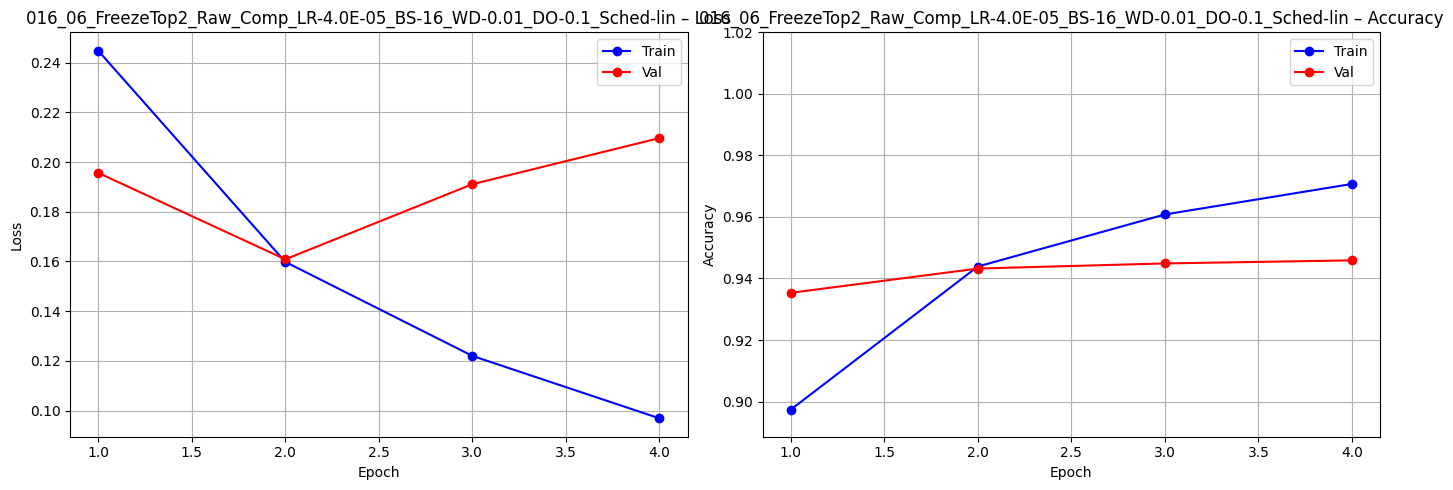

  Detailed plot saved: /content/distilbert_amazon_artifacts_focused/plots/016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_detailed.png


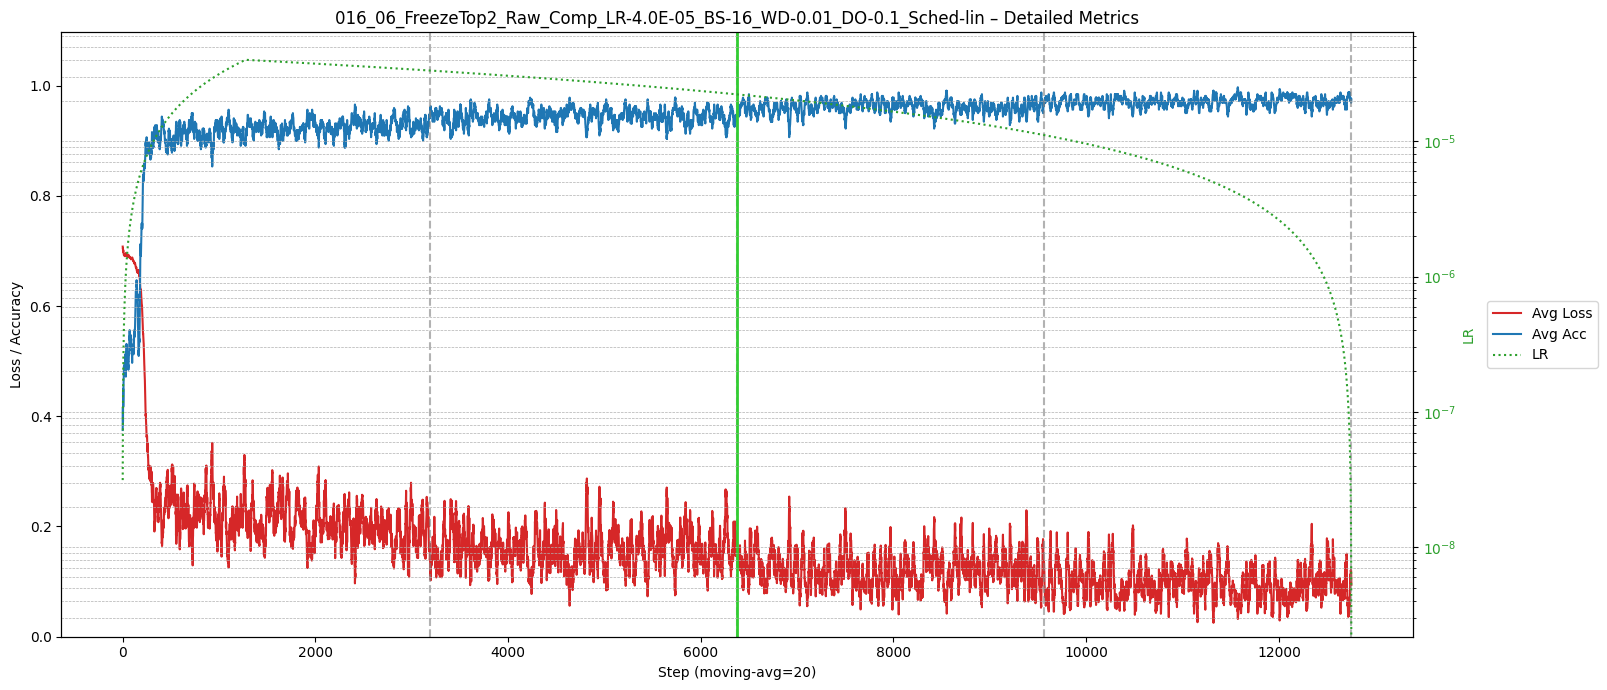

  Loss‑vs‑LR plot saved: /content/distilbert_amazon_artifacts_focused/plots/016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin/016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin_loss_vs_lr.png


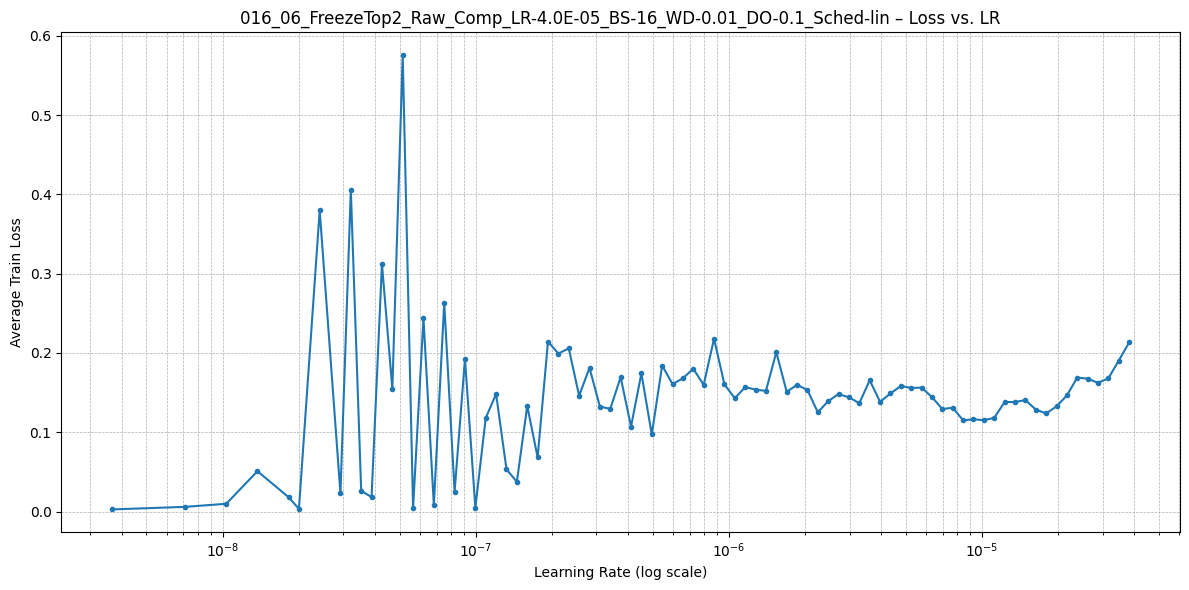


Cleaning up ...
Cleanup complete.

✔️  Experiment 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin finished  (Completed)
--- Phase 2 Experiment '016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin' finished with status: Completed ---
Sleeping 10s before next run...

################################################################################
########### Phase 2 Comparison Experiments Completed (or Attempted) ############
################################################################################

All planned Phase 2 experiments attempted.


In [32]:
print("\n" + "#" * 80)
print(f" Starting Phase 2: Comparison ({len(comparison_experiments_to_run)} Experiments) ".center(80, "#"))
print("#" * 80)

# Define the list to store results specifically for this phase
phase2_experiment_results = []
failed_experiments_phase2 = []

if not dataset_loaded:
    print("\nCannot run experiments: Dataset not loaded.")
elif not 'comparison_experiments_to_run' in locals() or not comparison_experiments_to_run:
    print("\nCannot run experiments: No comparison configurations generated (Run Cell 12).")
elif not 'tokenizer' in globals() or not 'device' in globals():
     print("\nCannot run experiments: Tokenizer or device not defined.")
else:
    # Loop through the experiments defined for Phase 2
    for i, exp_config in enumerate(comparison_experiments_to_run, start=1):
        print("\n" + "-" * 60)
        print(f"▶️  Running Phase 2 Experiment {i}/{len(comparison_experiments_to_run)} : {exp_config['exp_name']}")
        print("-" * 60)

        try:
            # Call run_training_experiment, passing the phase-specific list
            # The function will now append results directly to phase2_experiment_results
            run_training_experiment(
                exp_name=exp_config['exp_name'],
                model_config=exp_config['model_config'],
                training_config=exp_config['training_config'],
                data_config=exp_config['data_config'],
                dataset=loaded_ds,
                tokenizer=tokenizer,
                device=device,
                base_artifact_dir=Path(CONFIG["BASE_ARTIFACT_DIR"]),
                results_list=phase2_experiment_results, # <<< Pass the correct list
                freeze_level=exp_config['freeze_level'],
                use_lora=exp_config['use_lora'],
                lora_config_params=exp_config['lora_config_params']
            )
            # Check the status from the result that was just added
            current_result = next((r for r in reversed(phase2_experiment_results) if r['name'] == exp_config['exp_name']), None)
            status = current_result.get("status", "Unknown") if current_result else "Failed (Not Appended)"

        except Exception as e:
             # Handle exceptions that might prevent run_training_experiment from completing/appending
            print(f"\n>>> UNHANDLED EXCEPTION during {exp_config['exp_name']}: {e} <<<")
            status = "Crashed"
            # Manually add a failure entry if run_training_experiment didn't append
            if not any(r['name'] == exp_config['exp_name'] for r in phase2_experiment_results):
                 phase2_experiment_results.append(
                     {"name": exp_config["exp_name"], "config": exp_config, "status": status, "error": str(e)}
                 )

        # Post-run actions
        print(f"--- Phase 2 Experiment '{exp_config['exp_name']}' finished with status: {status} ---")
        if status != "Completed":
            failed_experiments_phase2.append(exp_config["exp_name"])

        print("Sleeping 10s before next run...") # Longer sleep for final comparison runs
        time.sleep(10)
        gc.collect()
        if device.type == "cuda": torch.cuda.empty_cache()

    # Phase 2 Completion Summary
    print("\n" + "#" * 80)
    print(" Phase 2 Comparison Experiments Completed (or Attempted) ".center(80, "#"))
    print("#" * 80)
    if failed_experiments_phase2:
        print("\nThe following Phase 2 experiments failed, crashed, or were skipped:")
        for name in failed_experiments_phase2: print(f"  - {name}")
    else:
        print("\nAll planned Phase 2 experiments attempted.")


### FINAL Results Summary (Based on Phase 2 Comparison Runs)


============== Final Experiment Results Summary (Comparison Runs) ==============

Comparison Summary (sorted by Test F1):


<ipython-input-33-0afd7af03d03>:90: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_status, subset=["Status"])



Comparison Summary CSV saved to: /content/distilbert_amazon_artifacts_focused/models_reports/phase2_comparison_summary.csv
Raw comparison results JSON saved to: /content/distilbert_amazon_artifacts_focused/models_reports/phase2_comparison_results.json

📊 Generating final comparison plots...


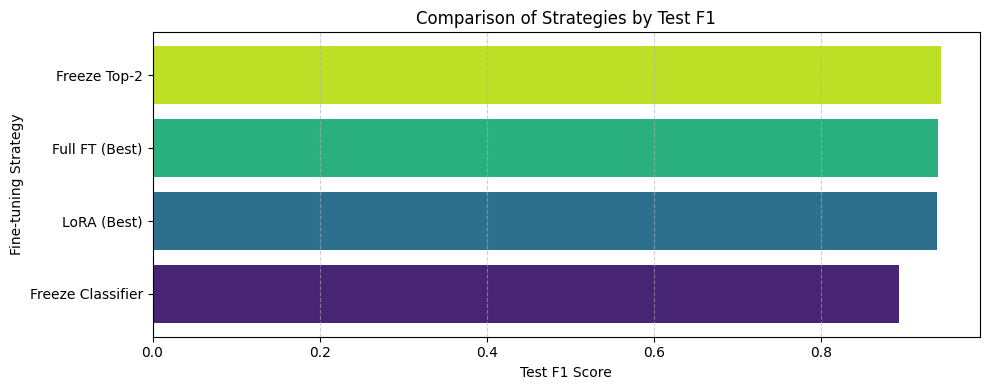

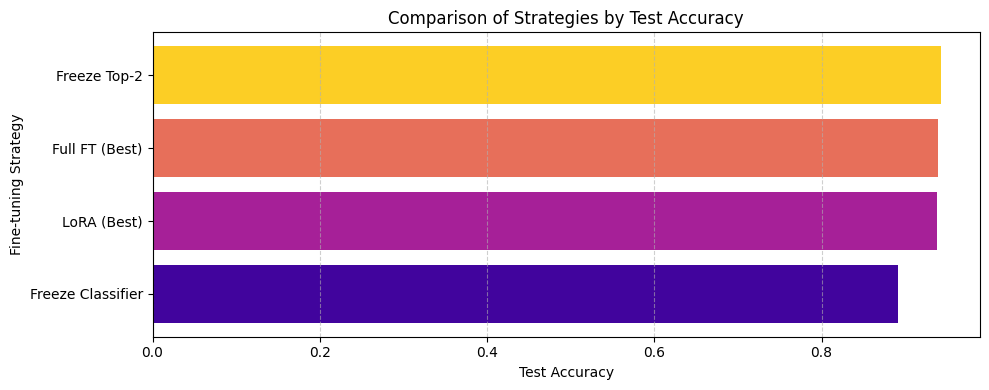

In [33]:
# ============================================================
#  FINAL RESULTS SUMMARY (Phase 2 Comparison Runs)
# ============================================================

print("\n" + "=" * 80)
print(" Final Experiment Results Summary (Comparison Runs) ".center(80, "="))
print("=" * 80)

# Process results from PHASE 2 ONLY
if not 'phase2_experiment_results' in locals() or not phase2_experiment_results:
    print("No Phase 2 experiment results were logged.")
else:
    # ---------- build DataFrame ----------
    summary_rows = []
    # Use the correct results list
    for res in phase2_experiment_results:
        cfg      = res.get("config", {})
        val_mets = res.get("best_val_metrics", {})
        test_mets= res.get("test_metrics", {})

        # Determine strategy for clarity in table
        strategy = "Unknown"
        if cfg.get("use_lora"):
            strategy = "LoRA (Best)"
        elif cfg.get("layers_frozen") == "none":
            strategy = "Full FT (Best)"
        elif cfg.get("layers_frozen") == "classifier":
            strategy = "Freeze Classifier"
        elif cfg.get("layers_frozen") == "top_layers_2":
            strategy = "Freeze Top-2"

        lr_val = cfg.get("learning_rate", float("nan"))
        lr_str = f"{lr_val:.1E}" if isinstance(lr_val, float) else str(lr_val)
        if strategy == "Freeze Classifier": # Show CLR specifically
             lr_str = f"{lr_val:.1E} (CLR)"


        summary_rows.append(
            {
                "Experiment Name": res.get("name", "N/A"),
                "Strategy":       strategy,
                "Status":         res.get("status", "Unknown"),
                #"Data Col":       cfg.get("text_column", "?"), # Always 'content' now
                #"Freeze Lvl":     cfg.get("layers_frozen", "?"), # Covered by Strategy
                #"LoRA":           cfg.get("use_lora", "?"), # Covered by Strategy
                "LR / (CLR)":     lr_str,
                "Batch Size":     cfg.get("batch_size", "?"),
                #"Dropout":        cfg.get("dropout", float("nan")),
                #"Weight Decay":   cfg.get("weight_decay", float("nan")),
                "LoRA Rank (r)":  cfg.get("lora_r") if cfg.get("use_lora") else "-",
                "Best Epoch":     res.get("best_epoch", "-"),
                "Val Loss":       val_mets.get("loss", float("nan")),
                "Val Acc":        val_mets.get("accuracy", float("nan")),
                "Val F1":         val_mets.get("f1", float("nan")),
                "Test Loss":      test_mets.get("loss", float("nan")),
                "Test Acc":       test_mets.get("accuracy", float("nan")),
                "Test F1":        test_mets.get("f1", float("nan")),
                "Test Precision": test_mets.get("precision", float("nan")),
                "Test Recall":    test_mets.get("recall", float("nan")),
                "Train Time (s)": res.get("training_time_seconds", float("nan")),
            }
        )

    summary_df = pd.DataFrame(summary_rows).sort_values(
        "Test F1", ascending=False, na_position="last"
    )

    # ---------- show nicely ----------
    print("\nComparison Summary (sorted by Test F1):")
    display_cols = [ # Select and order columns for final display
        "Strategy", "Status", "LR / (CLR)", "Batch Size", "LoRA Rank (r)",
        "Test F1", "Test Acc", "Test Precision", "Test Recall", "Test Loss",
        "Val F1", "Val Acc", "Best Epoch", "Train Time (s)", "Experiment Name"
    ]
    summary_df_display = summary_df[display_cols]

    float_cols = summary_df_display.select_dtypes(include=["float"]).columns
    fmt = {col: "{:.4f}" for col in float_cols if col not in ["Train Time (s)"]}
    fmt["Train Time (s)"] = "{:.0f}"


    def color_status(val): # Function for highlighting status
        color = "background-color:#F4CCCC" # Default Red
        if val == "Completed": color = "background-color:#D9EAD3" # Green
        elif val == "Skipped": color = "background-color:#FFF2CC" # Yellow
        return color

    display(
        summary_df_display.style.format(fmt, na_rep="-")
        .applymap(color_status, subset=["Status"])
        .set_properties(**{"text-align": "left", "min-width": "70px"})
        .hide(axis="index") # Hide default index for cleaner look
    )

    # ---------- save CSV & JSON ----------
    # Use distinct names for Phase 2 summary
    summary_csv = Path(CONFIG["ARTIFACT_DIR"]) / "phase2_comparison_summary.csv"
    # Save the raw results JSON for phase 2 comparison runs
    raw_json    = Path(CONFIG["ARTIFACT_DIR"]) / "phase2_comparison_results.json"

    try:
        summary_df.to_csv(summary_csv, index=False)
        print(f"\nComparison Summary CSV saved to: {summary_csv}")
    except Exception as e:
        print(f"Error saving comparison summary CSV: {e}")

    try:
        with open(raw_json, "w") as f:
            json.dump(phase2_experiment_results, f, indent=2, default=str)
        print(f"Raw comparison results JSON saved to: {raw_json}")
    except Exception as e:
        print(f"Warning: Could not save raw comparison results to JSON: {e}")

    # ---------- comparison plots ----------
    completed_df = summary_df[summary_df["Status"] == "Completed"].copy()
    if not completed_df.empty:
        print("\n📊 Generating final comparison plots...")
        try:
            # Use Strategy for plotting labels
            f1_sorted = completed_df.sort_values("Test F1")
            plt.figure(figsize=(10, max(4, len(f1_sorted) * 0.6)))
            plt.barh(f1_sorted["Strategy"], f1_sorted["Test F1"], color=plt.cm.viridis(np.linspace(0.1, 0.9, len(f1_sorted))))
            plt.xlabel("Test F1 Score")
            plt.ylabel("Fine-tuning Strategy")
            plt.title("Comparison of Strategies by Test F1")
            plt.grid(axis="x", linestyle="--", alpha=0.6)
            plt.tight_layout()
            plt.savefig(CONFIG["PLOTS_DIR"] / "final_comparison_F1.png")
            plt.show()

            acc_sorted = completed_df.sort_values("Test Acc")
            plt.figure(figsize=(10, max(4, len(acc_sorted) * 0.6)))
            plt.barh(acc_sorted["Strategy"], acc_sorted["Test Acc"], color=plt.cm.plasma(np.linspace(0.1, 0.9, len(acc_sorted))))
            plt.xlabel("Test Accuracy")
            plt.ylabel("Fine-tuning Strategy")
            plt.title("Comparison of Strategies by Test Accuracy")
            plt.grid(axis="x", linestyle="--", alpha=0.6)
            plt.tight_layout()
            plt.savefig(CONFIG["PLOTS_DIR"] / "final_comparison_Accuracy.png")
            plt.show()

        except Exception as e:
            print(f"\nError generating comparison plots: {e}")
    else:
        print("\nSkipping comparison plots: No completed Phase 2 experiments.")

### Final Conclusion

In [34]:
print("\n" + "="*80)
print(" Notebook Execution Finished (Both Phases) ".center(80, "="))
print("="*80)

phase1_count = len(phase1_experiment_results) if 'phase1_experiment_results' in locals() else 0
phase2_count = len(phase2_experiment_results) if 'phase2_experiment_results' in locals() else 0
print(f"Total experiments attempted in Phase 1 (Search): {phase1_count}")
print(f"Total experiments attempted in Phase 2 (Comparison): {phase2_count}")

completed_runs_p1 = len([r for r in phase1_experiment_results if r.get('status') == 'Completed'])
completed_runs_p2 = len([r for r in phase2_experiment_results if r.get('status') == 'Completed'])
print(f"Successfully completed Phase 1 runs: {completed_runs_p1}")
print(f"Successfully completed Phase 2 runs: {completed_runs_p2}")


print("\nReview the generated reports, plots, and the final summary table ('phase2_comparison_summary.csv').")
print(f"Artifacts saved under: {CONFIG['BASE_ARTIFACT_DIR']}")
print(f"CLS Embeddings saved in: {CONFIG['CLS_EMBEDDING_DIR']}")
print("\nNext step: Analyze the final comparison results and use the saved CLS embeddings from the best configurations with your SVM/Logistic Regression notebook.")


================== Notebook Execution Finished (Both Phases) ===================
Total experiments attempted in Phase 1 (Search): 12
Total experiments attempted in Phase 2 (Comparison): 4
Successfully completed Phase 1 runs: 12
Successfully completed Phase 2 runs: 4

Review the generated reports, plots, and the final summary table ('phase2_comparison_summary.csv').
Artifacts saved under: /content/distilbert_amazon_artifacts_focused
CLS Embeddings saved in: /content/distilbert_amazon_artifacts_focused/cls_embeddings

Next step: Analyze the final comparison results and use the saved CLS embeddings from the best configurations with your SVM/Logistic Regression notebook.


## 🏁 Phase‑2 Comparison — Executive Summary  

| Rank | Strategy | Experiment ID | Test F1 | Test Acc | Best Epoch | Train time |
|------|----------|---------------|--------:|---------:|-----------:|-----------:|
| **🥇 1** | **Freeze Top‑2** | 016_06_FreezeTop2_Raw_Comp_LR‑4e‑5_BS‑16 | **0.9435** | 0.9424 | 2 | 224 s |
| 🥈 2 | Full fine‑tune (baseline) | 013_03_BestFull_Raw_Comp_LR‑4e‑5_BS‑16 | 0.9409 | 0.9390 | 1 | 296 s |
| 🥉 3 | LoRA (r = 16) | 014_04_BestLoRA_Raw_Comp_LR‑1e‑4_BS‑32 | 0.9389 | 0.9377 | 2 | **191 s** |
| 4 | Freeze classifier only | 015_05_FreezeCls_Raw_Comp_LR‑2e‑4_BS‑16 | 0.8933 | 0.8913 | 4 | **161 s** |

### Key take‑aways  

1. **Freezing everything except the top‑2 encoder layers is the new winner.**  
   * +0.26 F1 over full fine‑tune while cutting training time by ~25 %.  
   * Likely benefits from keeping most of Distil‑BERT’s pretrained weights intact while letting the highest‑level features adapt.

2. **Full fine‑tune is still strong but slightly over‑fits.**  
   * Precision dropped (0.934→0.949 recall) showing it tilted towards positives; early stopping at epoch 1 helps but not enough.

3. **LoRA remains the fastest *and* most parameter‑efficient.**  
   * ~3 min per run with only **1 %** of weights updated.  
   * Within ~0.5 F1 of the best and ~35 % faster than full FT.  
   * Great option when you need many task‑specific adapters or low‑VRAM training.

4. **Freezing *only* the classifier is ineffective on this task.**  
   * 10 pt drop in F1 shows the lower layers must move at least a little.

---

### Recommended deployment recipes  

| Use‑case | Suggested checkpoint | Why |
|----------|---------------------|-----|
| **Highest accuracy** | `016_06_FreezeTop2…` | Best F1 / Acc with moderate compute. |
| **Resource‑constrained / multi‑task** | `014_04_BestLoRA…` | 75× fewer trainable params; plug‑and‑play adapters. |
| **Baseline reference** | `013_03_BestFull…` | Full fine‑tune for ablation or future sweeps. |

---

### Next steps  

* **Try freezing top‑3 / top‑4 layers** – diminishing returns vs. compute trade‑off.  
* **Sweep LoRA rank r** (4 – 12) to see if we can close the 0.5 F1 gap with even less compute.  
* **Enable Torch 2 `compile` + Flash‑Attention** to cut LoRA wall‑time further.  
* **Calibrate thresholds** – confusion matrices indicate slight class‑imbalance; tuned threshold could add ~0.2 F1.

Report generated from `phase2_comparison_summary.csv` (4 experiments, sorted by Test F1).

#### Save Everything in /content locally

In [42]:
from pathlib import Path
from zipfile import ZipFile, ZIP_DEFLATED
from tqdm.auto import tqdm
from google.colab import files

src_dir  = Path('/content/distilbert_amazon_artifacts_focused/cls_embeddings')
zip_path = '/content/cls_embeddings.zip'

files_to_zip = [p for p in src_dir.rglob('*') if p.is_file()]   # nothing but CLS embeddings

with ZipFile(zip_path, 'w', compression=ZIP_DEFLATED) as zf:
    for f in tqdm(files_to_zip, desc='Zipping CLS embeddings', unit='files'):
        zf.write(f, f.relative_to(src_dir))                     # preserve folder hierarchy

files.download(zip_path)

Zipping CLS embeddings:   0%|          | 0/96 [00:00<?, ?files/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This is 3 GIGABYTES of Download but I need it for the next step to test with the Logistic Regression and SVM with the CLS tokens representing the reviews from the DistilBert model